# Comparison of "Random Splitting" and "Same Splitting" in unsupervised-wise FF settings

FF-based learning required both positive data and negative data. To use the dataset for both purposes, each FF-based layer was divided into two halves and the MNIST datasets were split into two sets (A, B). Set A contained five randomly selected digits, and set B contained the rest. The first half layer took set A as positive data, and set B as negative. The second half took set B as positive data, and set A as positive. Two different digit splittings are possible for unsupervised-wise FF: "random splitting" and "same splitting".

The random splitting made sure each layer received different sets of positives and negatives, while the same splitting made sure each layer receives the same sets. 

10 rounds of experiments were done to compare them. In each round, an additional constraint was added to make sure the first layer always received the same set of positives, such that comparisons could be made on how splitting affected the development of deeper layers. For example:

| | same splitting | random splitting |
|---|----|----|
|layer 1|1, 3, 4, 6, 9|1, 3, 4, 6, 9|
|layer 2|1, 3, 4, 6, 9|2, 3, 7, 8, 9|
|layer 3|1, 3, 4, 6, 9|0, 1, 5, 6, 7|
|layer 4|1, 3, 4, 6, 9|1, 2, 6, 7, 8|

Five softmax accuracies were used for evaluations, including the softmax head and four additional softmaxes each connected to a hidden layer. 

For more explanations and discussions, refer to this article.

# 1. Imports

In [1]:
import sys
sys.path.append('../../ffobjects/')

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from data import create_mnist_datasets
from utils import set_seed, plot_training_curves, get_routes
from trainmgr import TrainMgr
from ffobjects import FFPreNorm, FFSoftmax, FFOverlay, FFGoodness, FFRoutedDense

# CONFIGURATION
NUM_CLASS = 10 # Only digits 0 to 4 are positive samples
IMG_SHAPE = (28, 28, )

# 2. Testbed setup

In [2]:
def create_layers_and_train_seq(units, is_supervised_ff, seed, 
                                route_seed, route_split_mode):
    set_seed(seed=seed)
    
    embedding = tf.reshape(
        tf.one_hot(tf.range(NUM_CLASS), tf.reduce_prod(IMG_SHAPE)), 
        (NUM_CLASS, *IMG_SHAPE))
    
    layers = dict(
        # Utilities
        input = tf.keras.layers.InputLayer(name='input'),
        concat = tf.keras.layers.Concatenate(name='concat'),
        flatten = tf.keras.layers.Flatten(name='flatten'),
        preNorm = FFPreNorm(name='preNorm'),
        overlay = FFOverlay(embedding, name='overlay'),

        # FF layers
        b1 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b1'),
        b2 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b2'),
        b3 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b3'),
        b4 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b4'),

        # Classifiers
        softmax    = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax'),
        goodness   = FFGoodness(name=f'goodness'),
        softmax_b1 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b1'),
        softmax_b2 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b2'),
        softmax_b3 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b3'),
        softmax_b4 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b4'),
    )
    
    ff_layer_names = ['b1', 'b2', 'b3', 'b4']
    routes = get_routes(NUM_CLASS, units, len(ff_layer_names), route_seed, route_split_mode)
    for name, route in zip(ff_layer_names, routes):
        if is_supervised_ff:
            layers[name].ff_set_ctu_map(route, route)
        else:
            layers[name].ff_set_ctu_map(route, 1 - route)
    
    def train_seq(X, y, y_ff):
        x = layers['input'](X)
        if is_supervised_ff:
            x = layers['overlay'].ff_do_task((x, y), None)
        x = layers['flatten'](x)
        b1a = layers['b1'].ff_set_classes(y).ff_do_task(x, y_ff)
        b1n = layers['preNorm'](b1a)
        b2a = layers['b2'].ff_set_classes(y).ff_do_task(b1n, y_ff)
        b2n = layers['preNorm'](b2a)
        b3a = layers['b3'].ff_set_classes(y).ff_do_task(b2n, y_ff)
        b3n = layers['preNorm'](b3a)
        b4a = layers['b4'].ff_set_classes(y).ff_do_task(b3n, y_ff)
        b4n = layers['preNorm'](b4a)
        if is_supervised_ff:
            goodness_x = layers['concat']([b2a, b3a, b4a])
            y_pred = layers['goodness'].ff_do_task(goodness_x, y)
        else:
            softmax_x = layers['concat']([b2n, b3n, b4n])
            y_pred = layers['softmax'].ff_do_task(softmax_x, y)

        _ = layers['softmax_b1'].ff_do_task(b1n, y)
        _ = layers['softmax_b2'].ff_do_task(b2n, y)
        _ = layers['softmax_b3'].ff_do_task(b3n, y)
        _ = layers['softmax_b4'].ff_do_task(b4n, y)
        return y_pred
    
    return layers, train_seq

def train_layers(
    units, is_supervised_ff, 
    batch_size, data_shuffle_seed, 
    trainable_layers_list, show_metrics_max,
    route_seed, route_split_mode,
):
    '''
    Refer to the example in the next cell for explanation of arguments.
    '''
    layers, train_seq = create_layers_and_train_seq(
        units=units, 
        seed=300, 
        is_supervised_ff=is_supervised_ff,
        route_seed=route_seed,
        route_split_mode=route_split_mode)
    
    set_seed(seed=300)
    dataset = create_mnist_datasets(
        seed=data_shuffle_seed, 
        batch_size=batch_size, 
        is_supervised_ff=is_supervised_ff)
    train_mgr = TrainMgr(layers, train_seq).ff_train(
        dataset, 
        trainable_layers_list, 
        show_metrics_max=show_metrics_max)
    plot_training_curves(train_mgr)
    
    return train_mgr

# 3. Experiment 1 - `units = 100`

200/200 [==============================] - 1083s 5s/step - b1: 0.0619 - b2: 0.0604 - b3: 0.0781 - b4: 0.1160 - softmax: 0.9255 - softmax_b1: 0.9305 - softmax_b2: 0.9222 - softmax_b3: 0.9149 - softmax_b4: 0.9083 - softmax_b23: 0.9239 - softmax_b34: 0.9133 - softmax_b24: 0.9234 - softmax_b1234: 0.9346 - best_softmax: 0.9267 - best_softmax_b1: 0.9316 - best_softmax_b2: 0.9236 - best_softmax_b3: 0.9151 - best_softmax_b4: 0.9088 - best_softmax_b23: 0.9248 - best_softmax_b34: 0.9149 - best_softmax_b24: 0.9247 - best_softmax_b1234: 0.9361


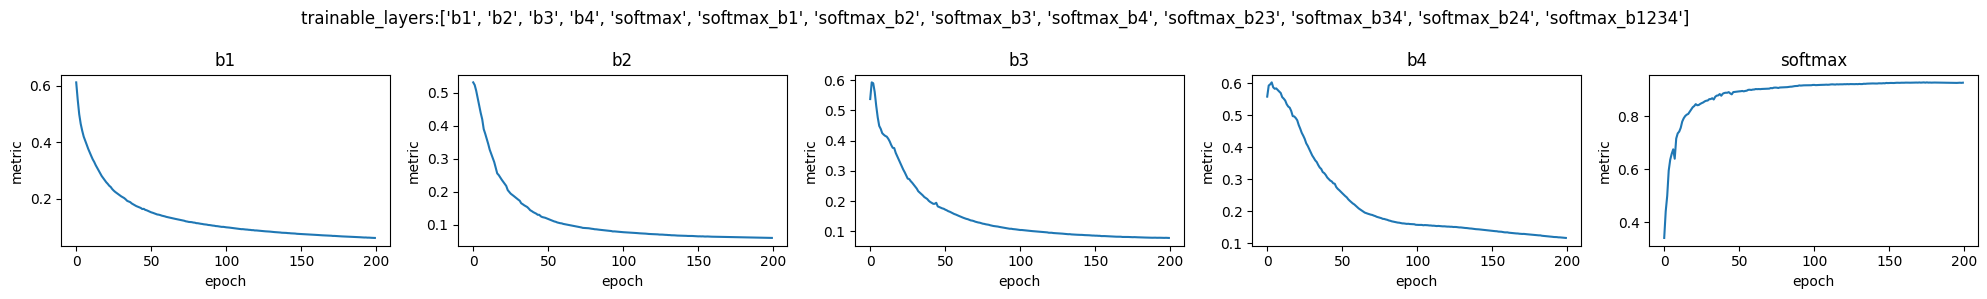

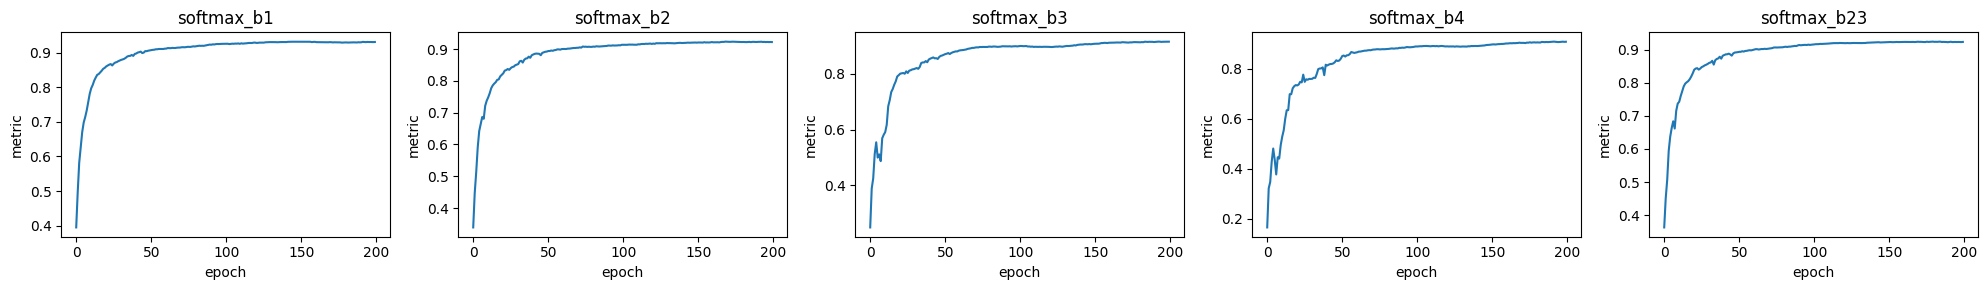

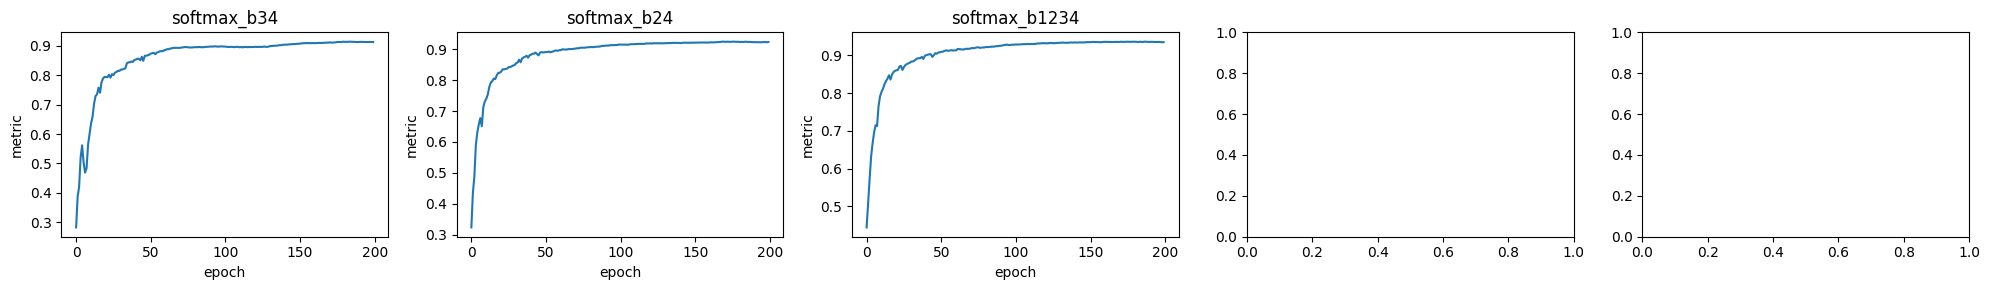

200/200 [==============================] - 1008s 5s/step - b1: 0.0619 - b2: 0.0222 - b3: 0.0250 - b4: 0.0240 - softmax: 0.9040 - softmax_b1: 0.9305 - softmax_b2: 0.9042 - softmax_b3: 0.8401 - softmax_b4: 0.6948 - softmax_b23: 0.9038 - softmax_b34: 0.8397 - softmax_b24: 0.9042 - softmax_b1234: 0.9298 - best_softmax: 0.9076 - best_softmax_b1: 0.9316 - best_softmax_b2: 0.9069 - best_softmax_b3: 0.8407 - best_softmax_b4: 0.7194 - best_softmax_b23: 0.9079 - best_softmax_b34: 0.8418 - best_softmax_b24: 0.9073 - best_softmax_b1234: 0.9321


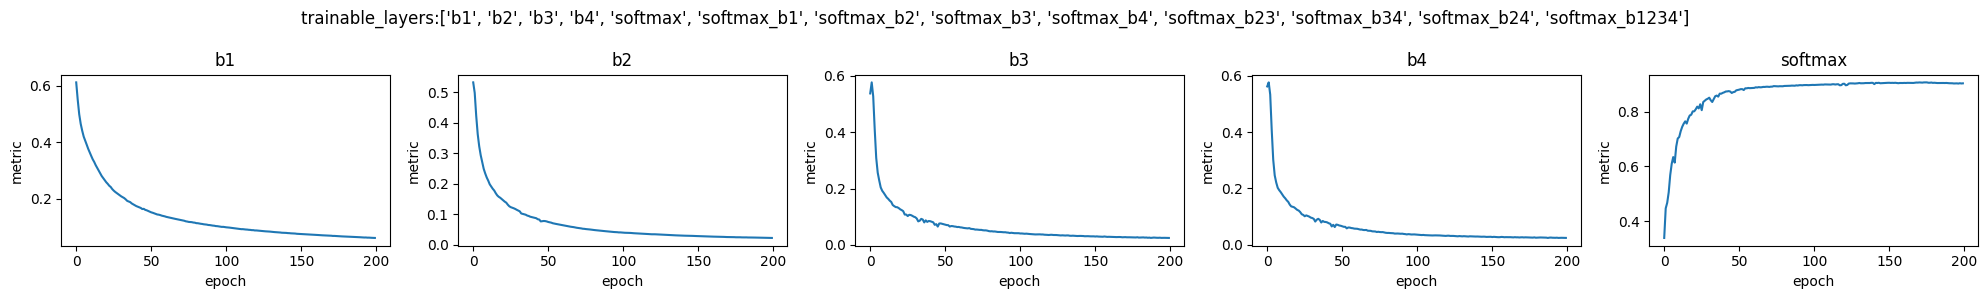

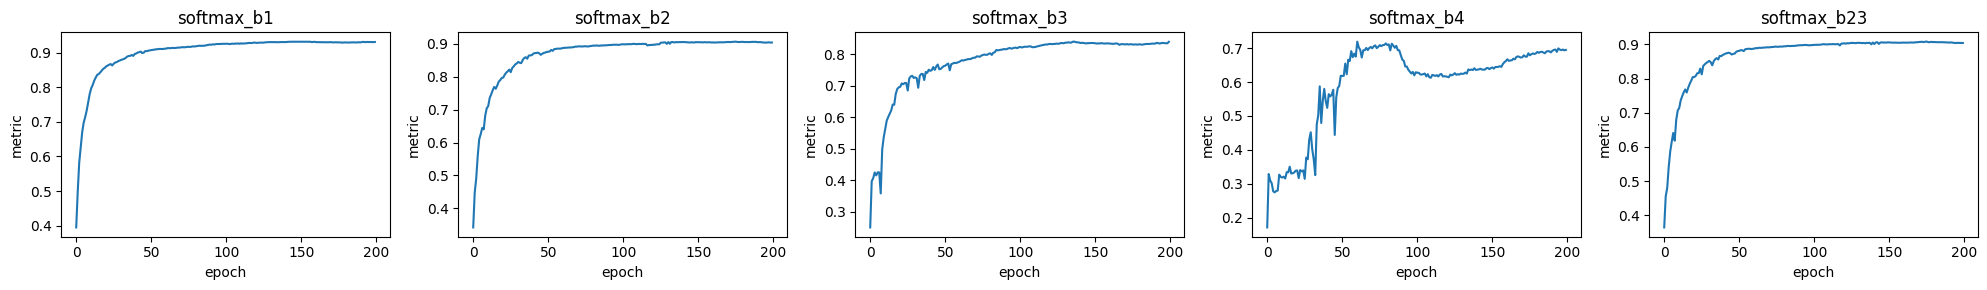

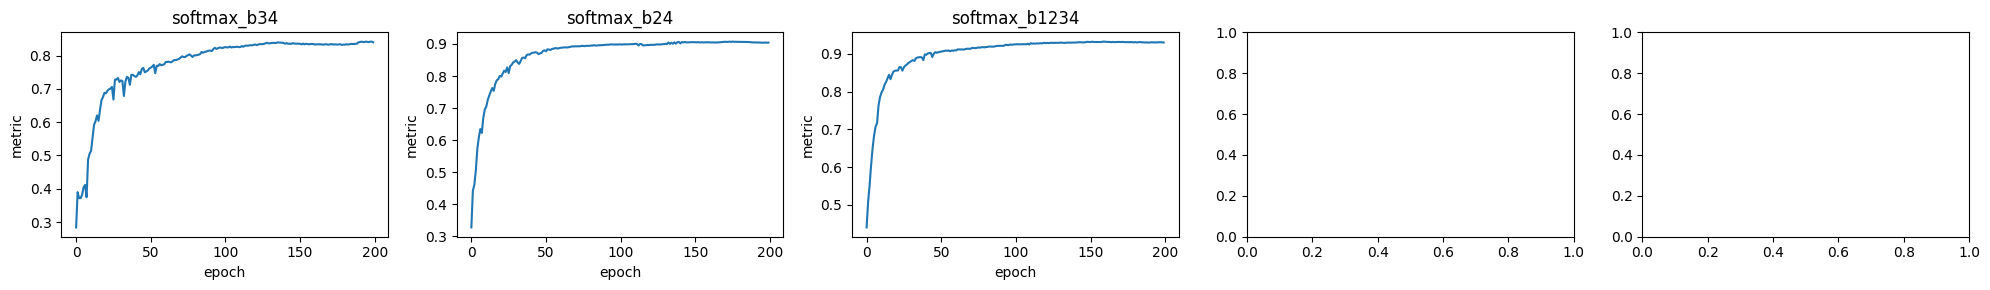

200/200 [==============================] - 931s 5s/step - b1: 0.0386 - b2: 0.0715 - b3: 0.1434 - b4: 0.0977 - softmax: 0.9050 - softmax_b1: 0.9237 - softmax_b2: 0.8955 - softmax_b3: 0.8913 - softmax_b4: 0.8696 - softmax_b23: 0.9025 - softmax_b34: 0.8936 - softmax_b24: 0.9015 - softmax_b1234: 0.9277 - best_softmax: 0.9050 - best_softmax_b1: 0.9237 - best_softmax_b2: 0.8955 - best_softmax_b3: 0.8913 - best_softmax_b4: 0.8706 - best_softmax_b23: 0.9025 - best_softmax_b34: 0.8936 - best_softmax_b24: 0.9015 - best_softmax_b1234: 0.9277


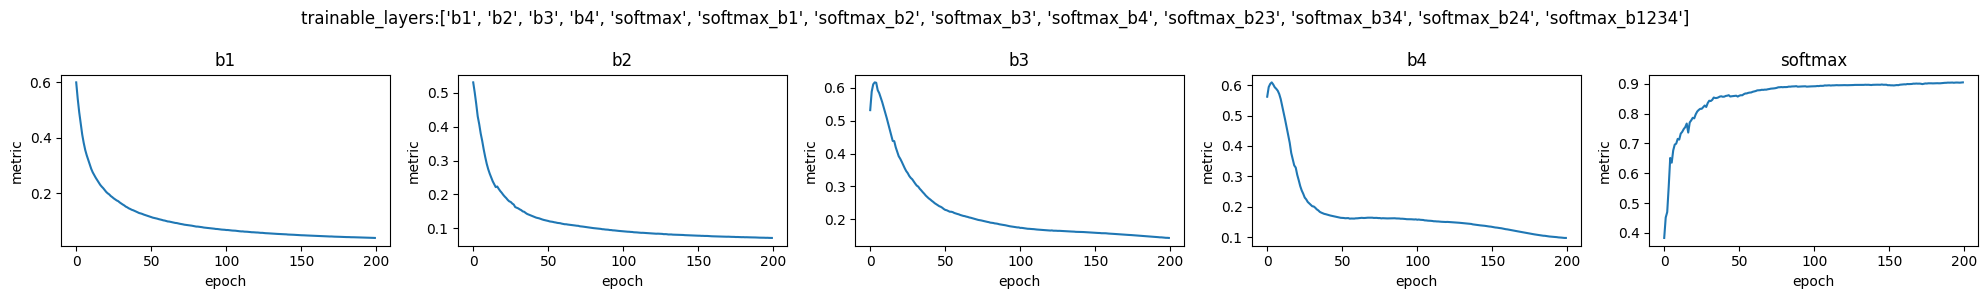

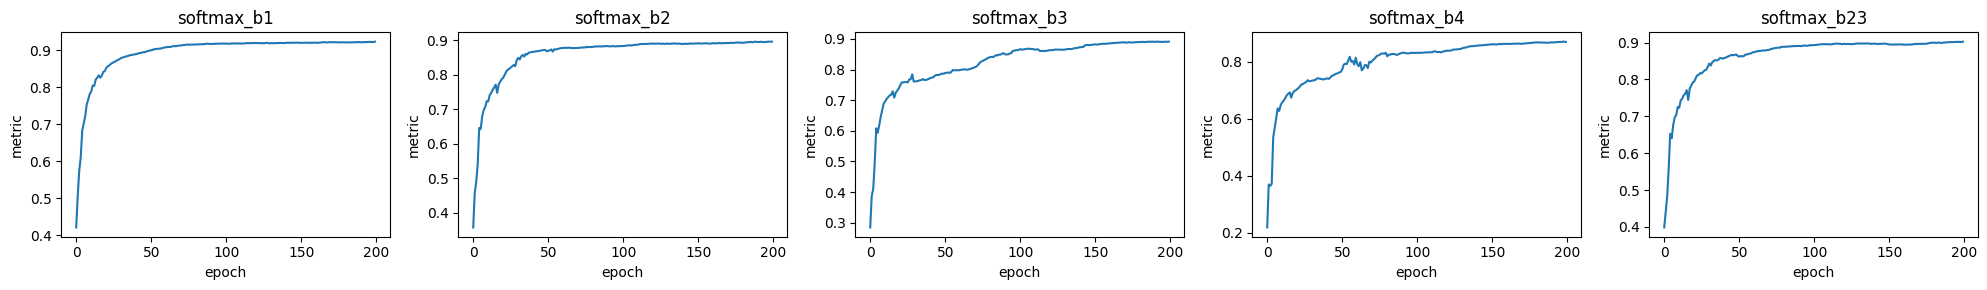

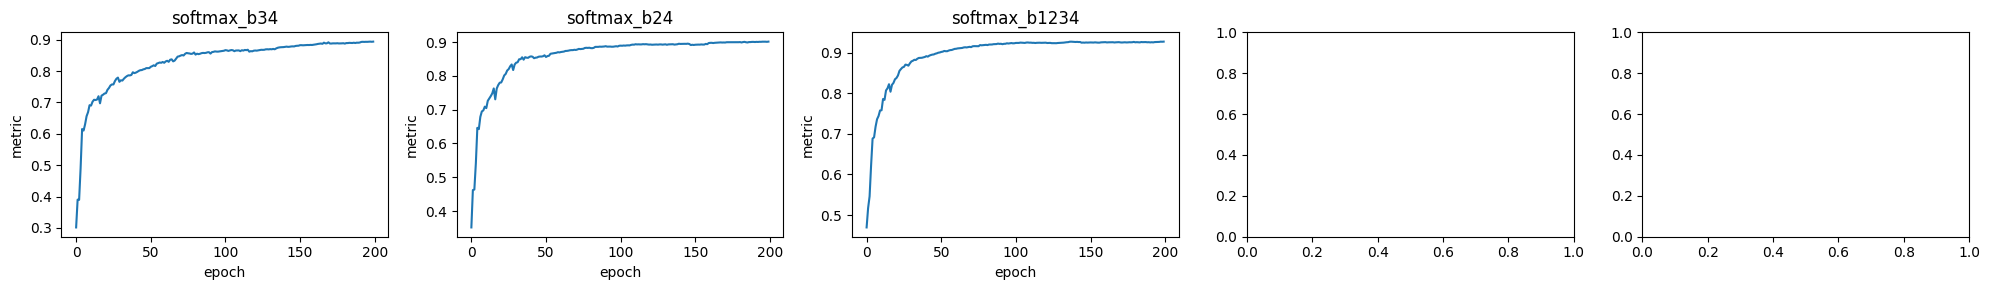

200/200 [==============================] - 558s 3s/step - b1: 0.0386 - b2: 0.0147 - b3: 0.0162 - b4: 0.0148 - softmax: 0.8911 - softmax_b1: 0.9237 - softmax_b2: 0.8897 - softmax_b3: 0.8043 - softmax_b4: 0.6176 - softmax_b23: 0.8913 - softmax_b34: 0.8046 - softmax_b24: 0.8894 - softmax_b1234: 0.9227 - best_softmax: 0.8915 - best_softmax_b1: 0.9237 - best_softmax_b2: 0.8897 - best_softmax_b3: 0.8094 - best_softmax_b4: 0.6354 - best_softmax_b23: 0.8913 - best_softmax_b34: 0.8077 - best_softmax_b24: 0.8902 - best_softmax_b1234: 0.9227


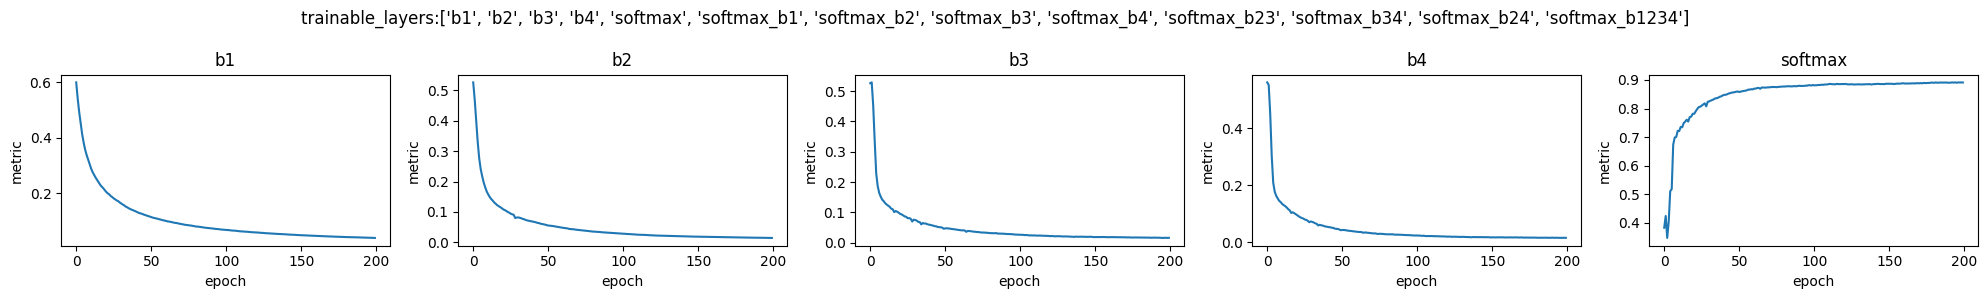

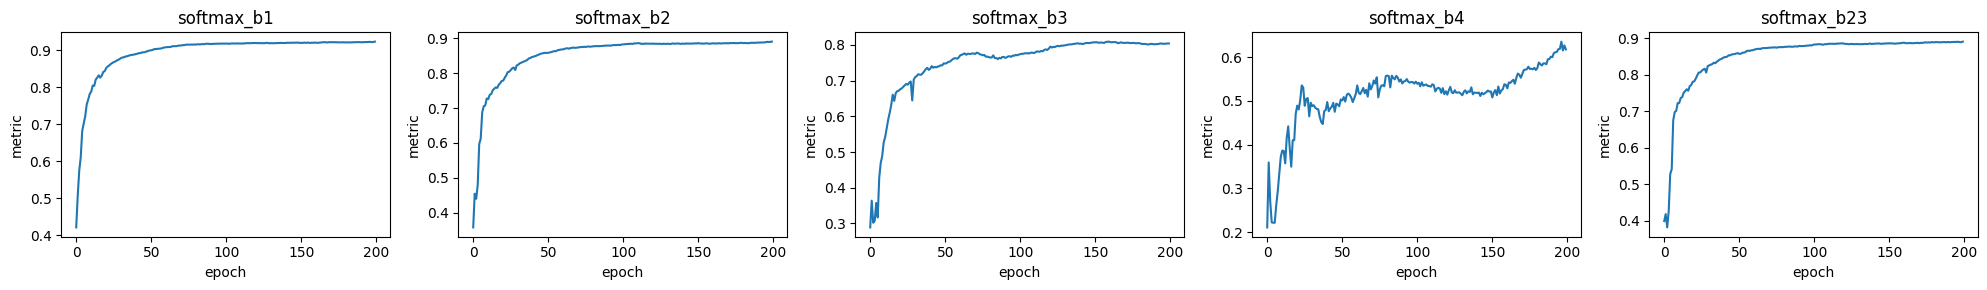

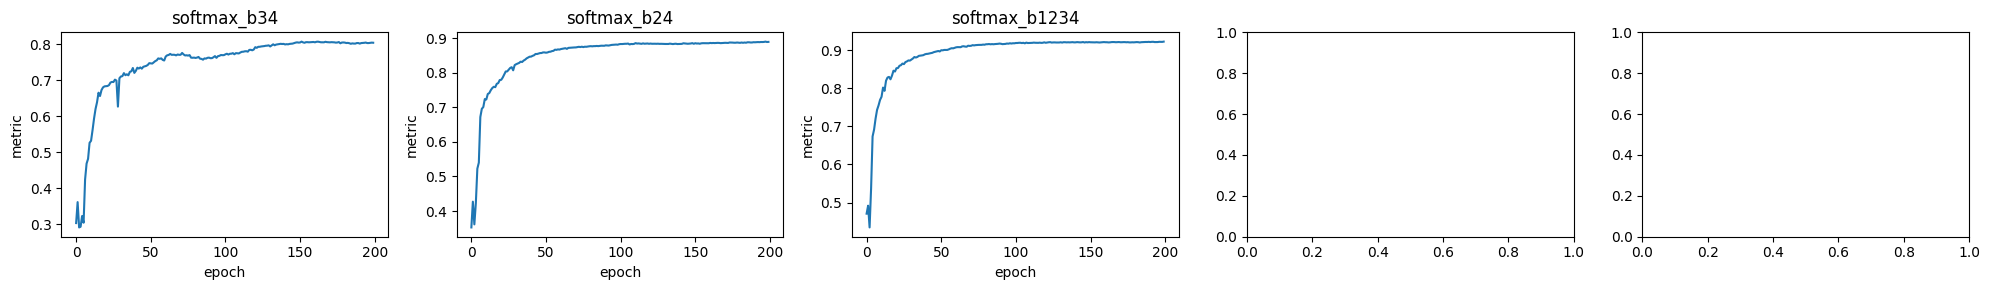

200/200 [==============================] - 566s 3s/step - b1: 0.0618 - b2: 0.0609 - b3: 0.0733 - b4: 0.0608 - softmax: 0.9322 - softmax_b1: 0.9364 - softmax_b2: 0.9323 - softmax_b3: 0.9255 - softmax_b4: 0.9182 - softmax_b23: 0.9331 - softmax_b34: 0.9271 - softmax_b24: 0.9322 - softmax_b1234: 0.9375 - best_softmax: 0.9329 - best_softmax_b1: 0.9368 - best_softmax_b2: 0.9327 - best_softmax_b3: 0.9257 - best_softmax_b4: 0.9195 - best_softmax_b23: 0.9333 - best_softmax_b34: 0.9271 - best_softmax_b24: 0.9340 - best_softmax_b1234: 0.9381


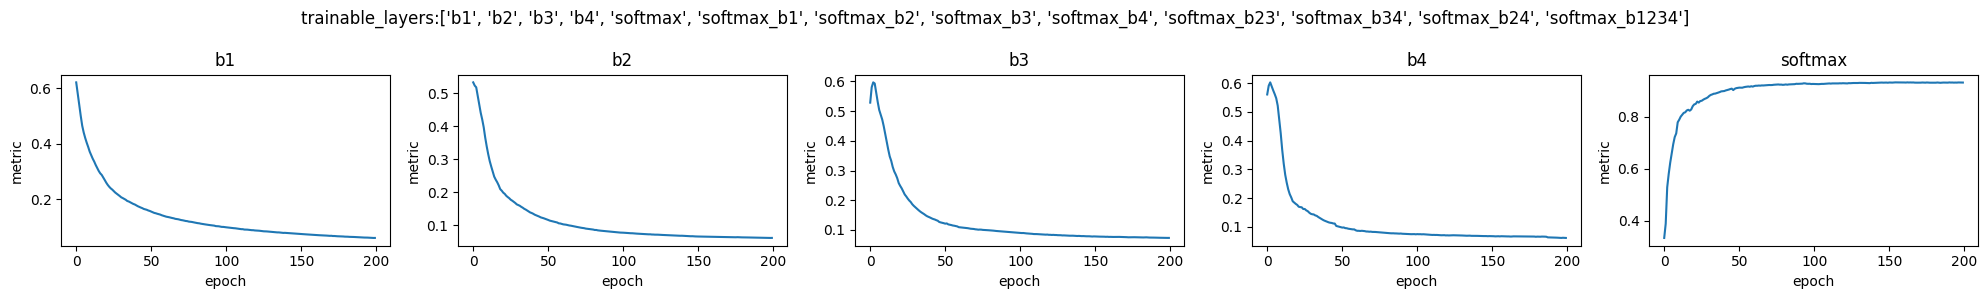

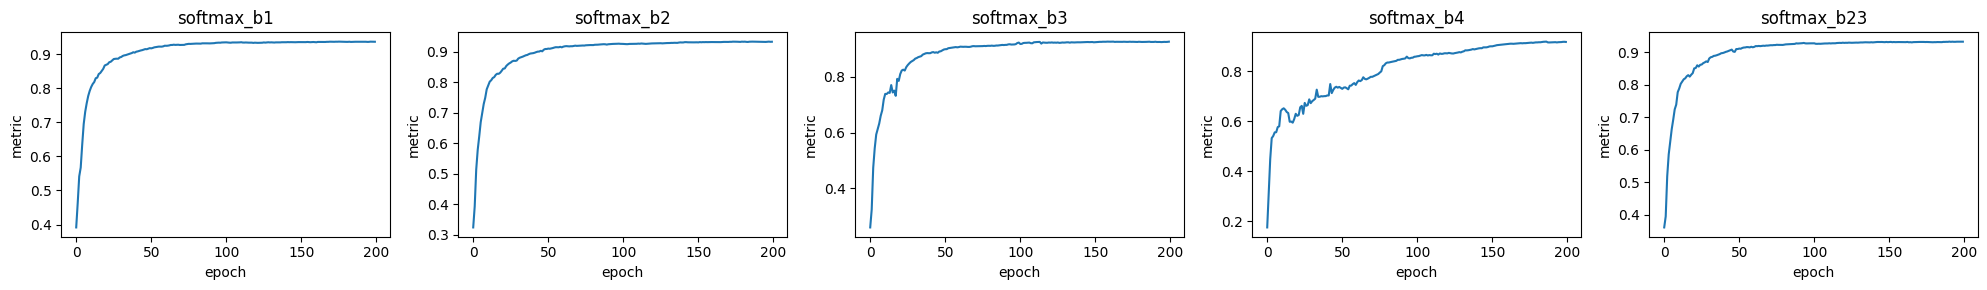

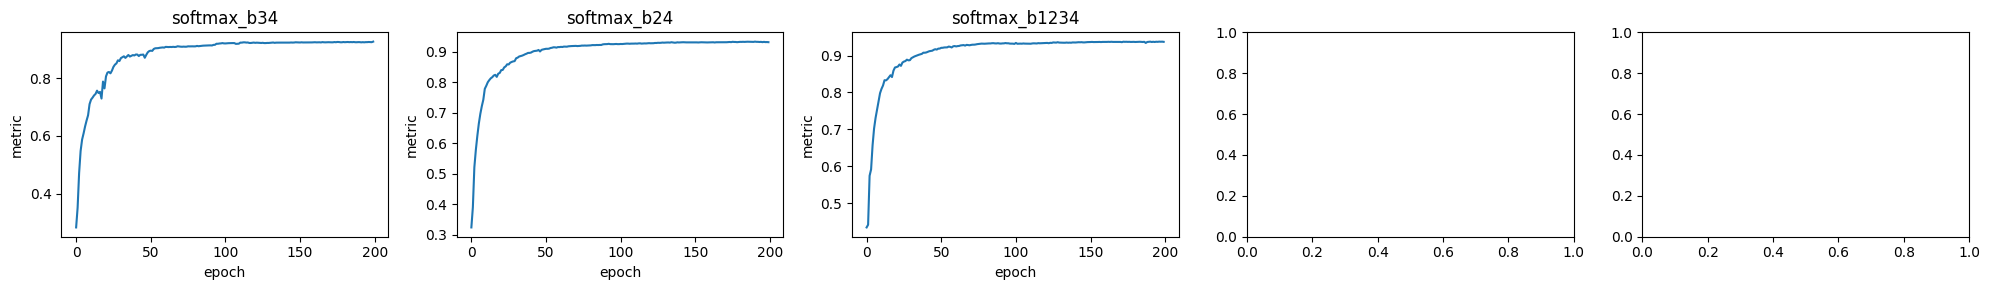

200/200 [==============================] - 567s 3s/step - b1: 0.0618 - b2: 0.0208 - b3: 0.0230 - b4: 0.0223 - softmax: 0.9134 - softmax_b1: 0.9364 - softmax_b2: 0.9147 - softmax_b3: 0.8557 - softmax_b4: 0.6580 - softmax_b23: 0.9146 - softmax_b34: 0.8543 - softmax_b24: 0.9140 - softmax_b1234: 0.9373 - best_softmax: 0.9190 - best_softmax_b1: 0.9368 - best_softmax_b2: 0.9187 - best_softmax_b3: 0.8569 - best_softmax_b4: 0.7774 - best_softmax_b23: 0.9186 - best_softmax_b34: 0.8581 - best_softmax_b24: 0.9186 - best_softmax_b1234: 0.9376


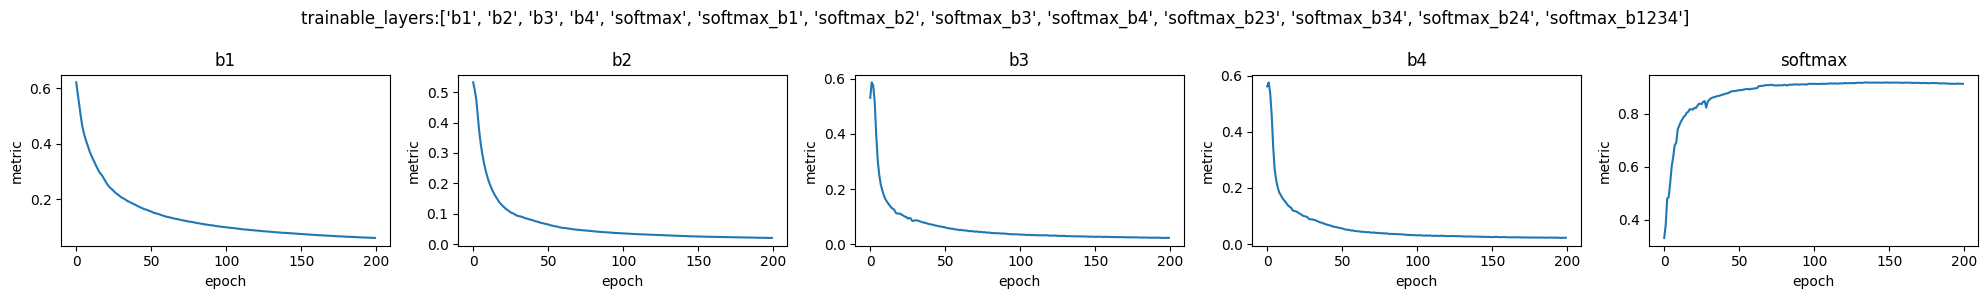

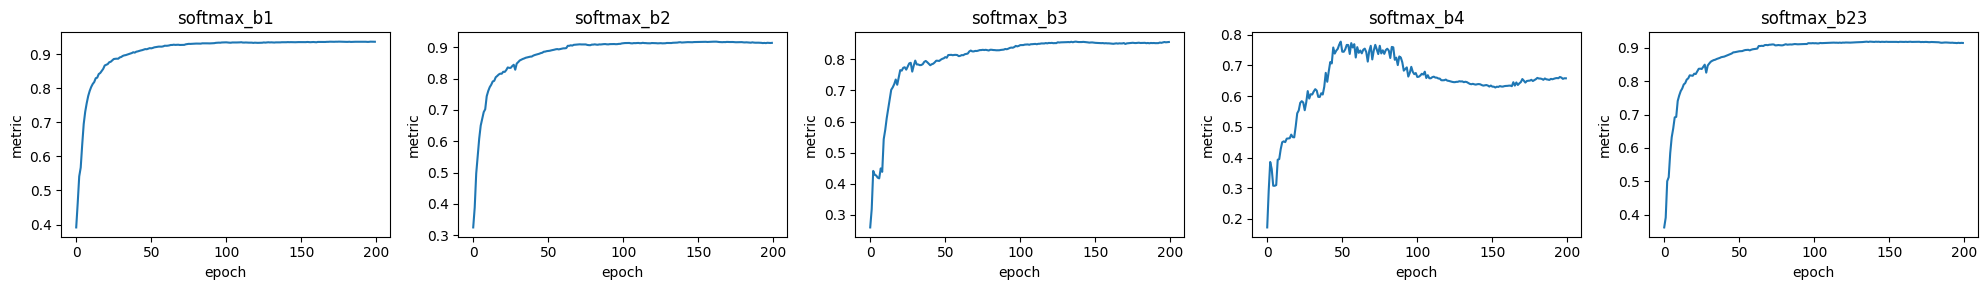

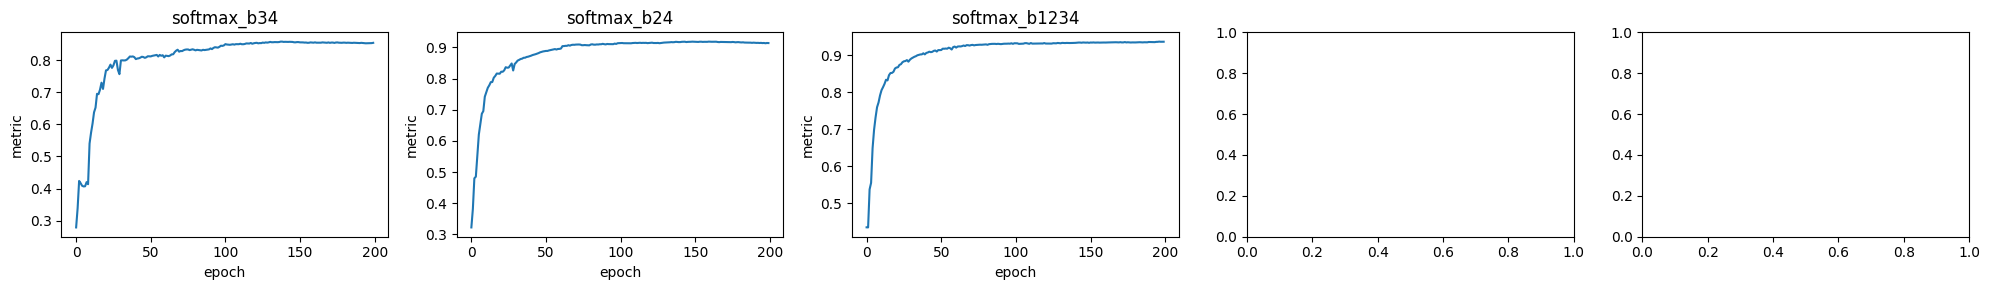

200/200 [==============================] - 572s 3s/step - b1: 0.0619 - b2: 0.0476 - b3: 0.0770 - b4: 0.0952 - softmax: 0.9231 - softmax_b1: 0.9305 - softmax_b2: 0.9212 - softmax_b3: 0.8972 - softmax_b4: 0.8594 - softmax_b23: 0.9235 - softmax_b34: 0.9006 - softmax_b24: 0.9242 - softmax_b1234: 0.9344 - best_softmax: 0.9253 - best_softmax_b1: 0.9316 - best_softmax_b2: 0.9215 - best_softmax_b3: 0.8990 - best_softmax_b4: 0.8594 - best_softmax_b23: 0.9242 - best_softmax_b34: 0.9007 - best_softmax_b24: 0.9257 - best_softmax_b1234: 0.9351


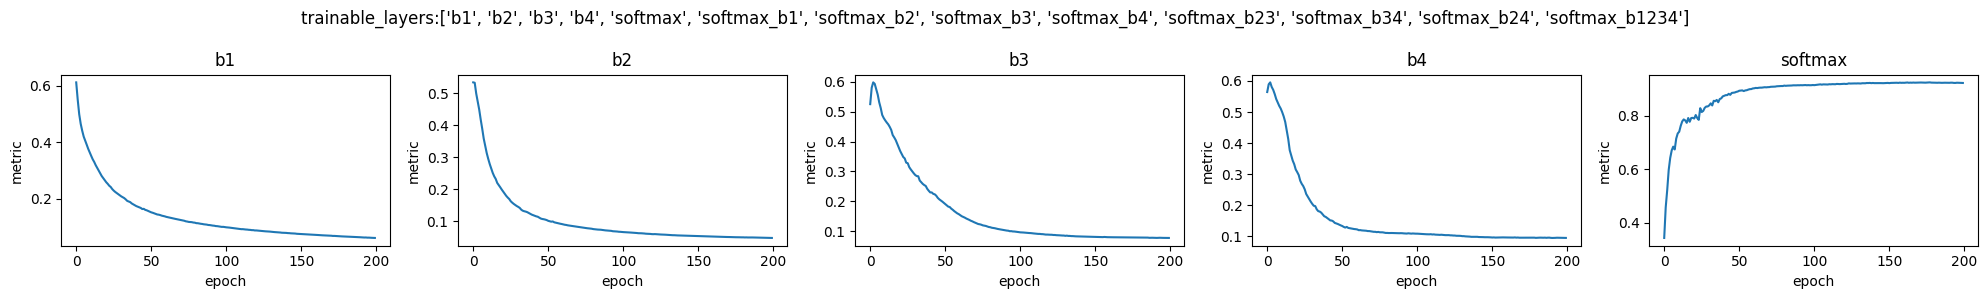

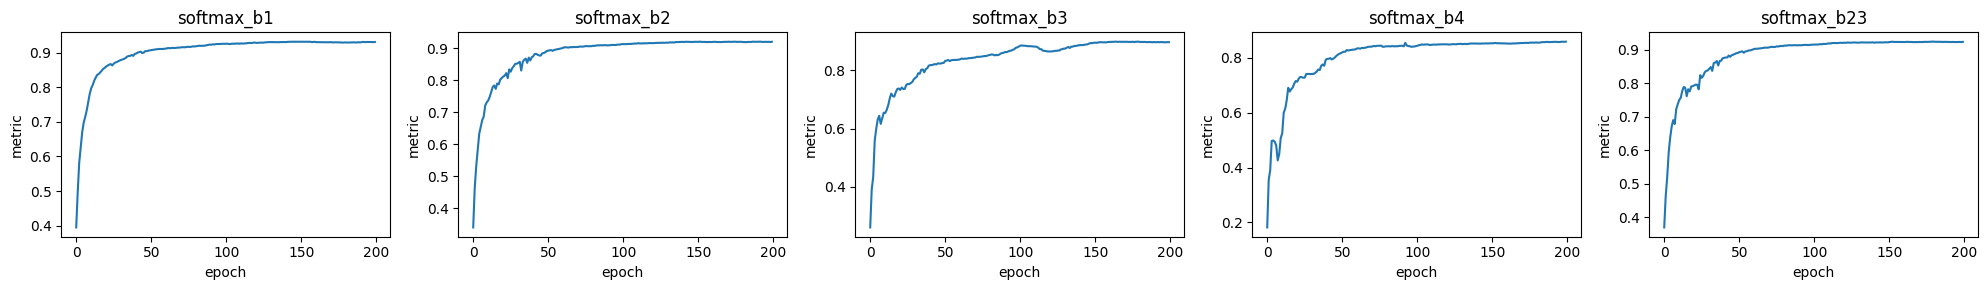

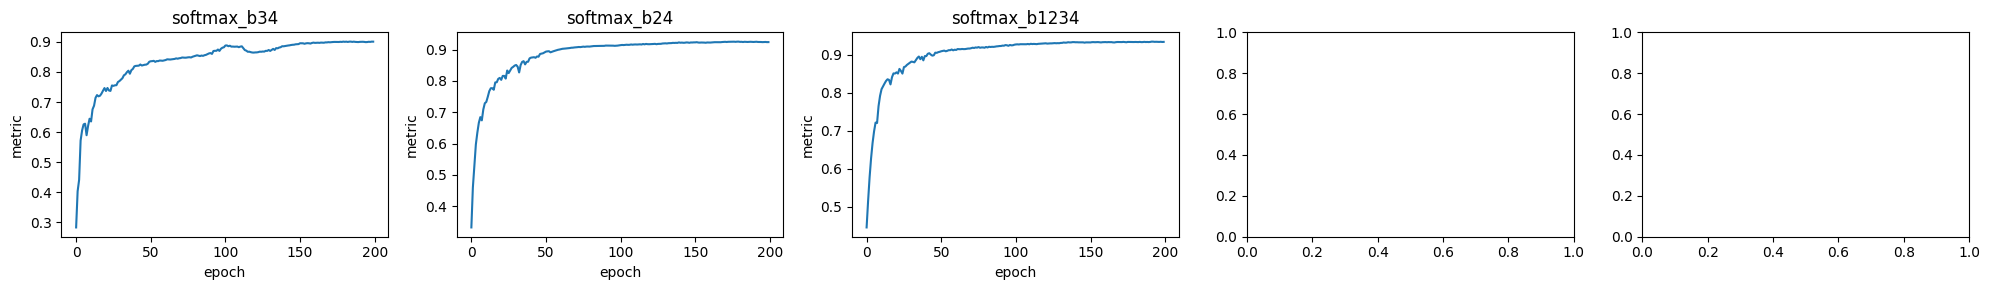

200/200 [==============================] - 564s 3s/step - b1: 0.0619 - b2: 0.0222 - b3: 0.0250 - b4: 0.0240 - softmax: 0.9040 - softmax_b1: 0.9305 - softmax_b2: 0.9042 - softmax_b3: 0.8401 - softmax_b4: 0.6948 - softmax_b23: 0.9038 - softmax_b34: 0.8397 - softmax_b24: 0.9042 - softmax_b1234: 0.9298 - best_softmax: 0.9076 - best_softmax_b1: 0.9316 - best_softmax_b2: 0.9069 - best_softmax_b3: 0.8407 - best_softmax_b4: 0.7194 - best_softmax_b23: 0.9079 - best_softmax_b34: 0.8418 - best_softmax_b24: 0.9073 - best_softmax_b1234: 0.9321


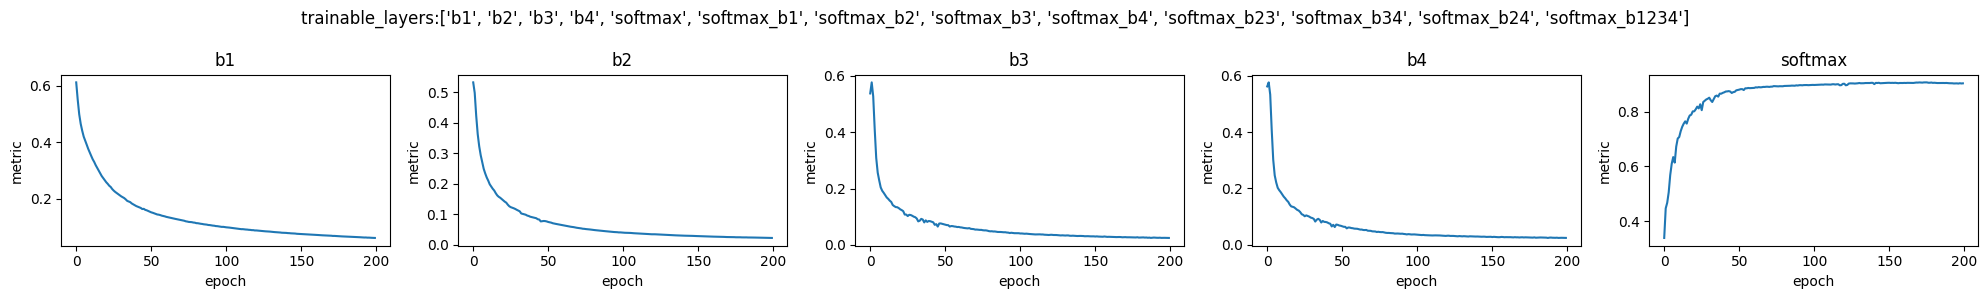

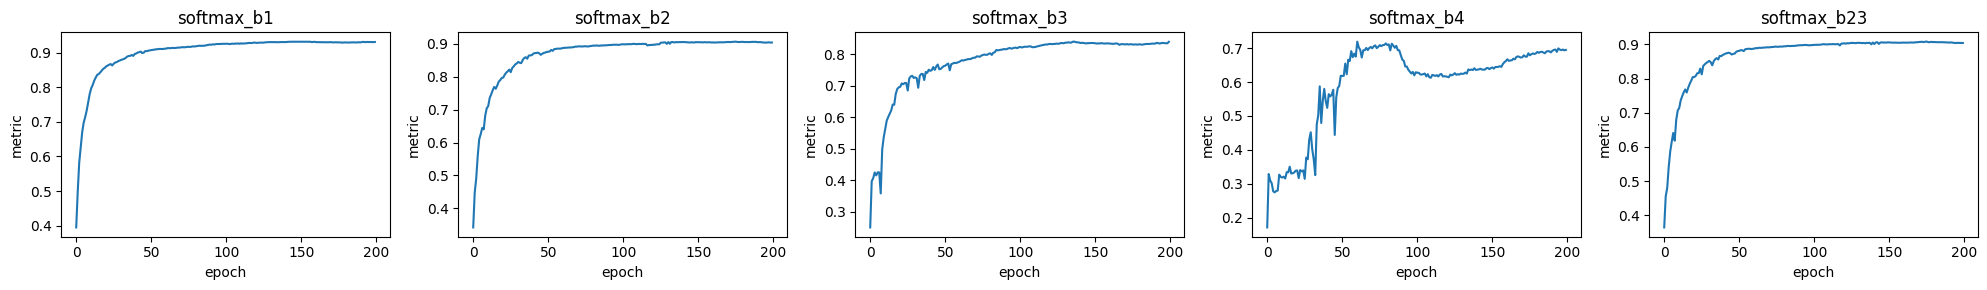

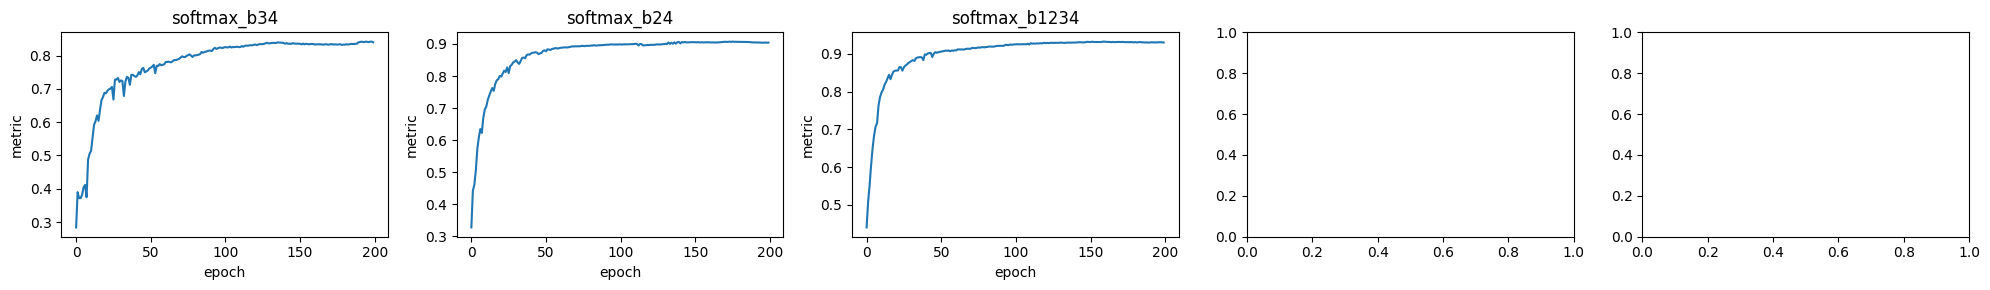

200/200 [==============================] - 569s 3s/step - b1: 0.0219 - b2: 0.0697 - b3: 0.1939 - b4: 0.1789 - softmax: 0.8595 - softmax_b1: 0.8776 - softmax_b2: 0.8487 - softmax_b3: 0.8352 - softmax_b4: 0.8159 - softmax_b23: 0.8571 - softmax_b34: 0.8379 - softmax_b24: 0.8561 - softmax_b1234: 0.8894 - best_softmax: 0.8609 - best_softmax_b1: 0.8790 - best_softmax_b2: 0.8503 - best_softmax_b3: 0.8353 - best_softmax_b4: 0.8164 - best_softmax_b23: 0.8601 - best_softmax_b34: 0.8386 - best_softmax_b24: 0.8572 - best_softmax_b1234: 0.8894


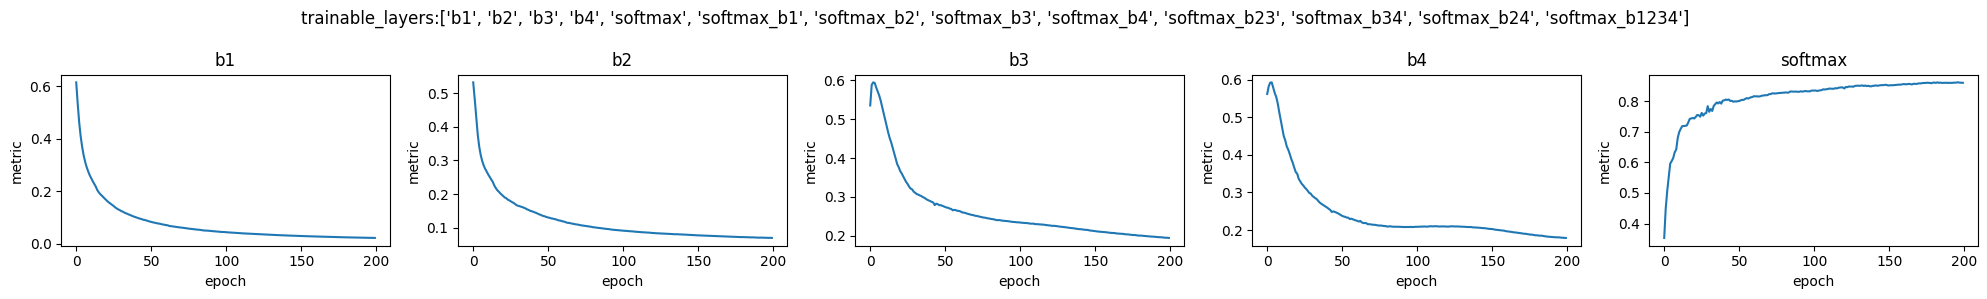

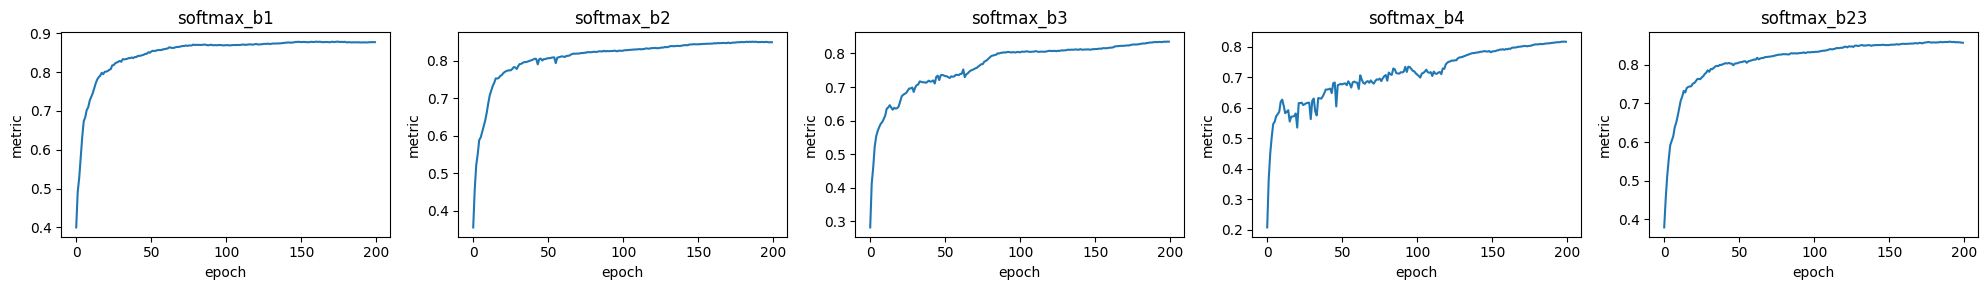

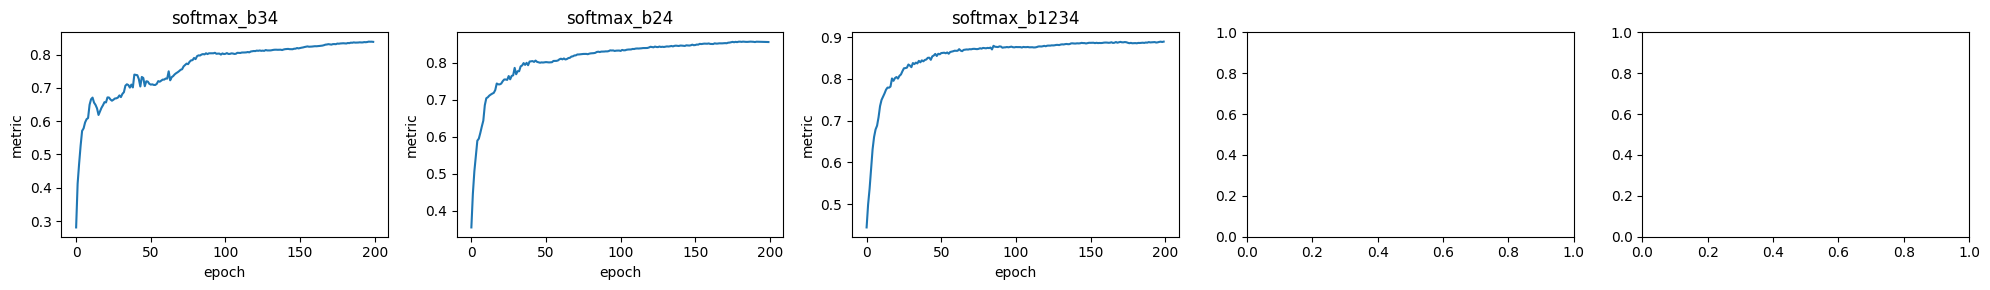

200/200 [==============================] - 569s 3s/step - b1: 0.0219 - b2: 0.0079 - b3: 0.0087 - b4: 0.0084 - softmax: 0.8416 - softmax_b1: 0.8776 - softmax_b2: 0.8378 - softmax_b3: 0.7510 - softmax_b4: 0.5769 - softmax_b23: 0.8430 - softmax_b34: 0.7584 - softmax_b24: 0.8398 - softmax_b1234: 0.8769 - best_softmax: 0.8447 - best_softmax_b1: 0.8790 - best_softmax_b2: 0.8410 - best_softmax_b3: 0.7563 - best_softmax_b4: 0.6182 - best_softmax_b23: 0.8440 - best_softmax_b34: 0.7614 - best_softmax_b24: 0.8438 - best_softmax_b1234: 0.8783


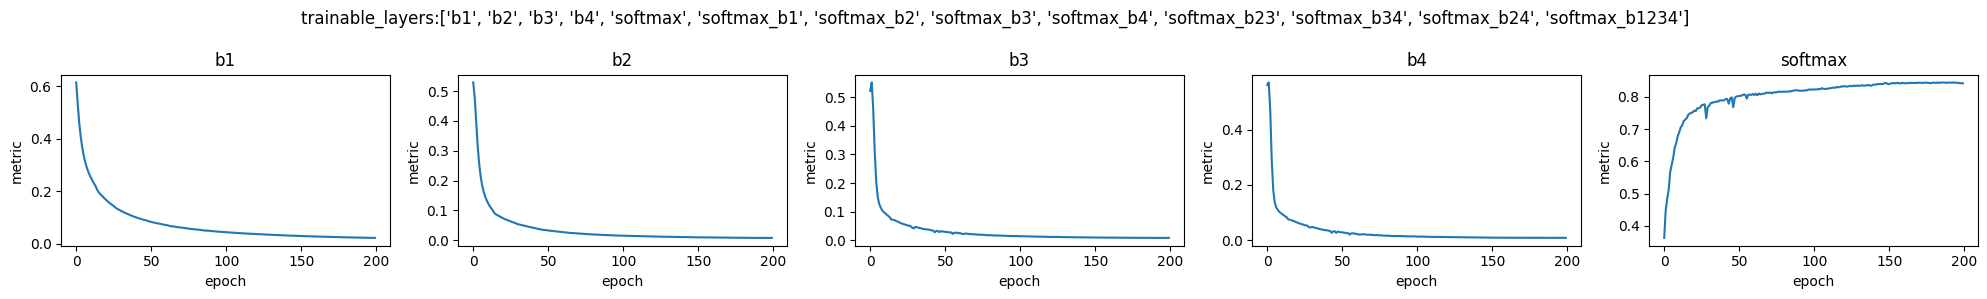

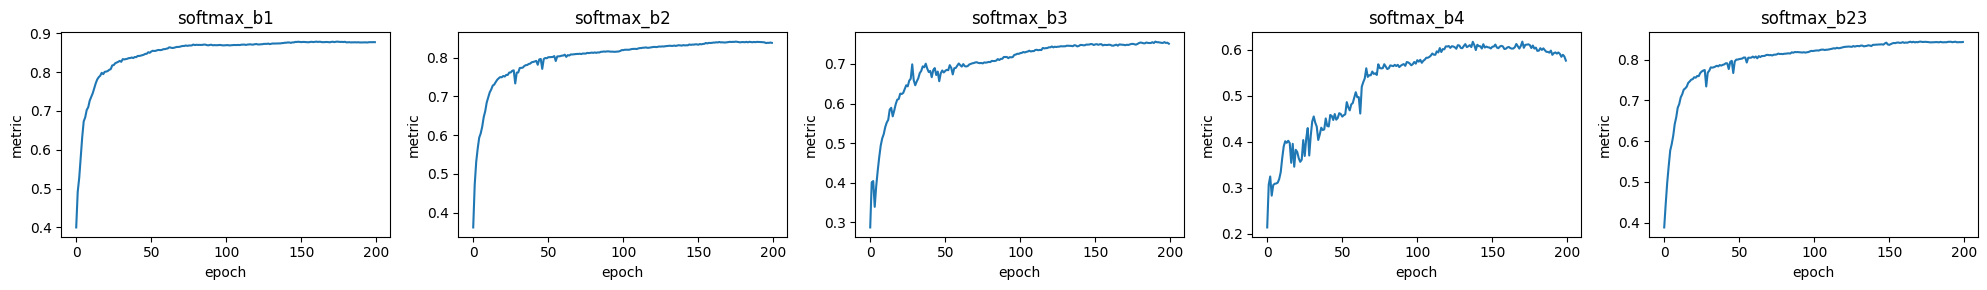

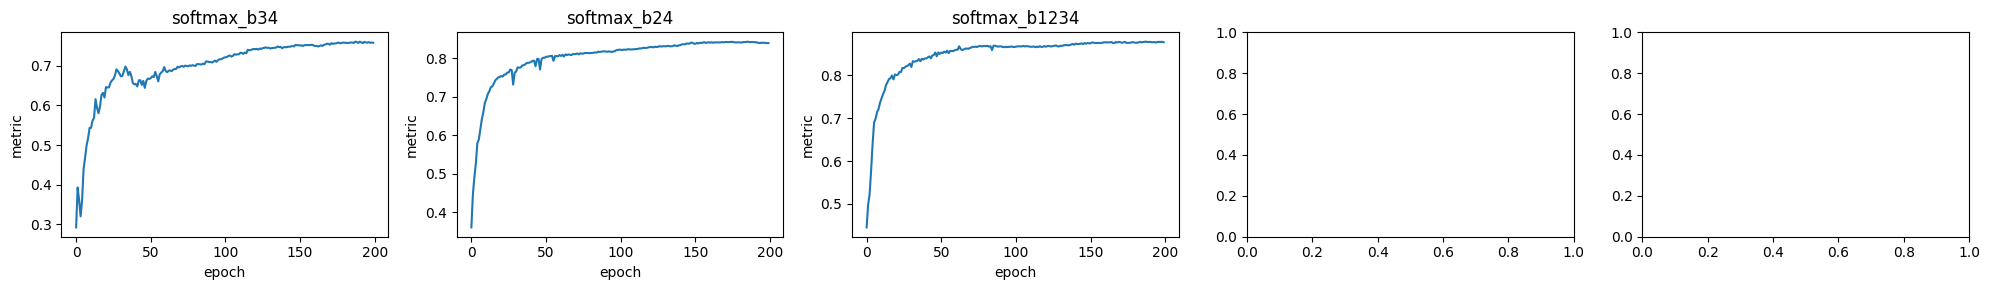

200/200 [==============================] - 563s 3s/step - b1: 0.0284 - b2: 0.1068 - b3: 0.1405 - b4: 0.1159 - softmax: 0.8786 - softmax_b1: 0.9010 - softmax_b2: 0.8751 - softmax_b3: 0.8539 - softmax_b4: 0.8337 - softmax_b23: 0.8810 - softmax_b34: 0.8556 - softmax_b24: 0.8758 - softmax_b1234: 0.9064 - best_softmax: 0.8813 - best_softmax_b1: 0.9031 - best_softmax_b2: 0.8767 - best_softmax_b3: 0.8549 - best_softmax_b4: 0.8389 - best_softmax_b23: 0.8816 - best_softmax_b34: 0.8557 - best_softmax_b24: 0.8794 - best_softmax_b1234: 0.9071


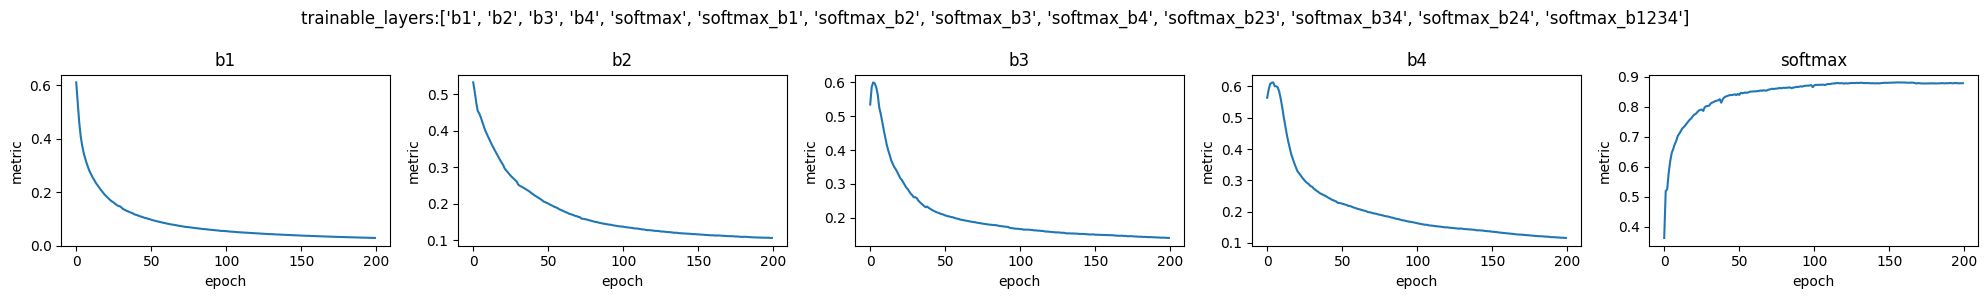

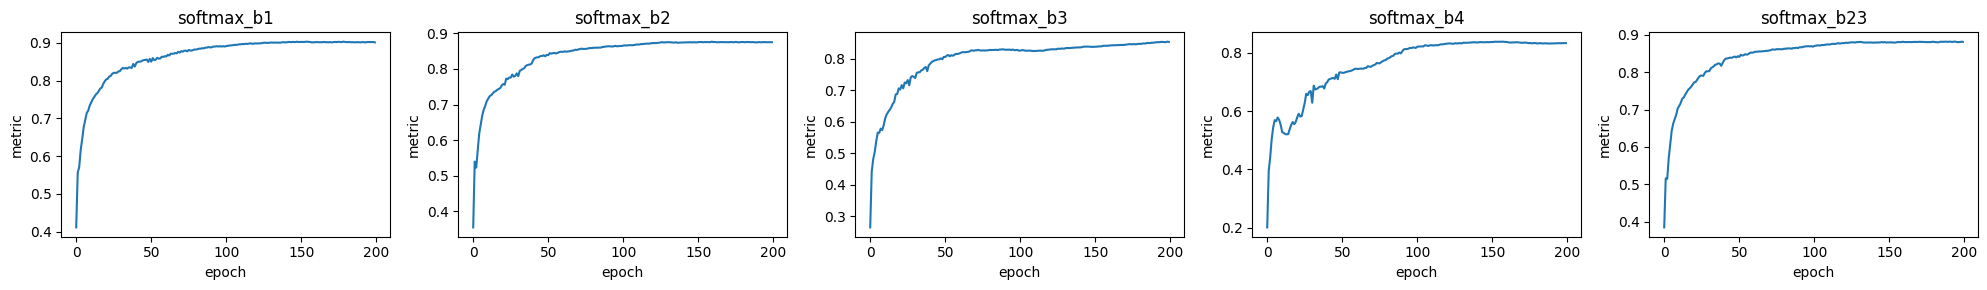

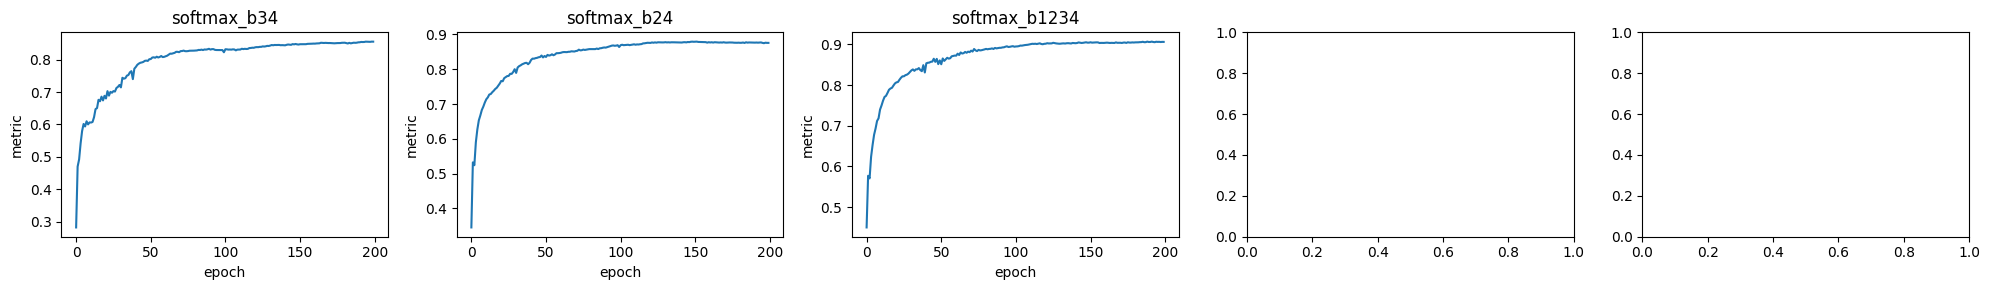

200/200 [==============================] - 633s 3s/step - b1: 0.0284 - b2: 0.0095 - b3: 0.0105 - b4: 0.0101 - softmax: 0.8651 - softmax_b1: 0.9010 - softmax_b2: 0.8636 - softmax_b3: 0.7497 - softmax_b4: 0.5175 - softmax_b23: 0.8642 - softmax_b34: 0.7588 - softmax_b24: 0.8640 - softmax_b1234: 0.9009 - best_softmax: 0.8673 - best_softmax_b1: 0.9031 - best_softmax_b2: 0.8651 - best_softmax_b3: 0.7500 - best_softmax_b4: 0.5368 - best_softmax_b23: 0.8673 - best_softmax_b34: 0.7589 - best_softmax_b24: 0.8657 - best_softmax_b1234: 0.9016


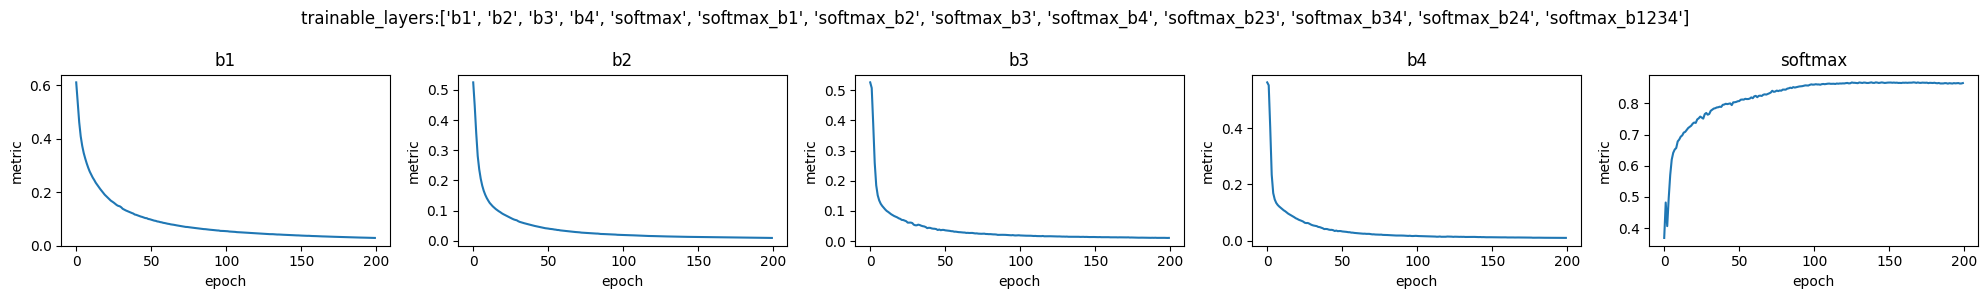

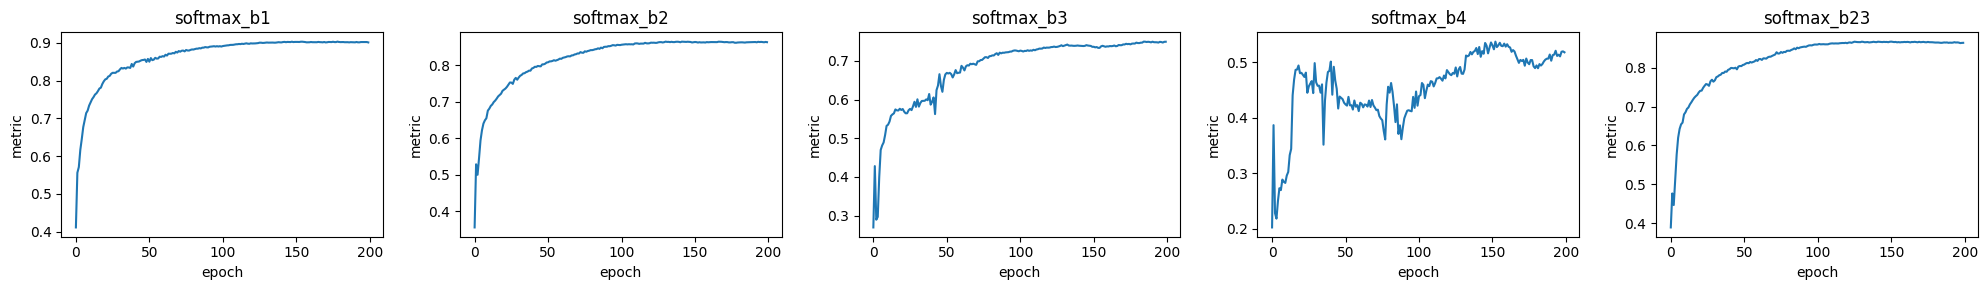

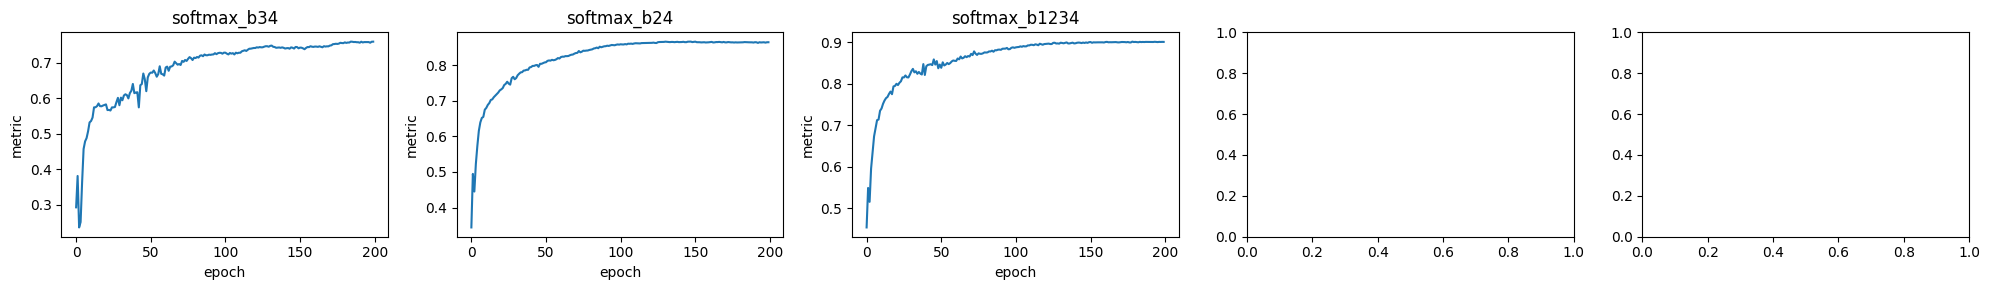

200/200 [==============================] - 667s 3s/step - b1: 0.0523 - b2: 0.0729 - b3: 0.1095 - b4: 0.0858 - softmax: 0.9162 - softmax_b1: 0.9202 - softmax_b2: 0.9142 - softmax_b3: 0.9120 - softmax_b4: 0.9064 - softmax_b23: 0.9172 - softmax_b34: 0.9134 - softmax_b24: 0.9164 - softmax_b1234: 0.9226 - best_softmax: 0.9178 - best_softmax_b1: 0.9206 - best_softmax_b2: 0.9151 - best_softmax_b3: 0.9120 - best_softmax_b4: 0.9076 - best_softmax_b23: 0.9179 - best_softmax_b34: 0.9139 - best_softmax_b24: 0.9170 - best_softmax_b1234: 0.9232


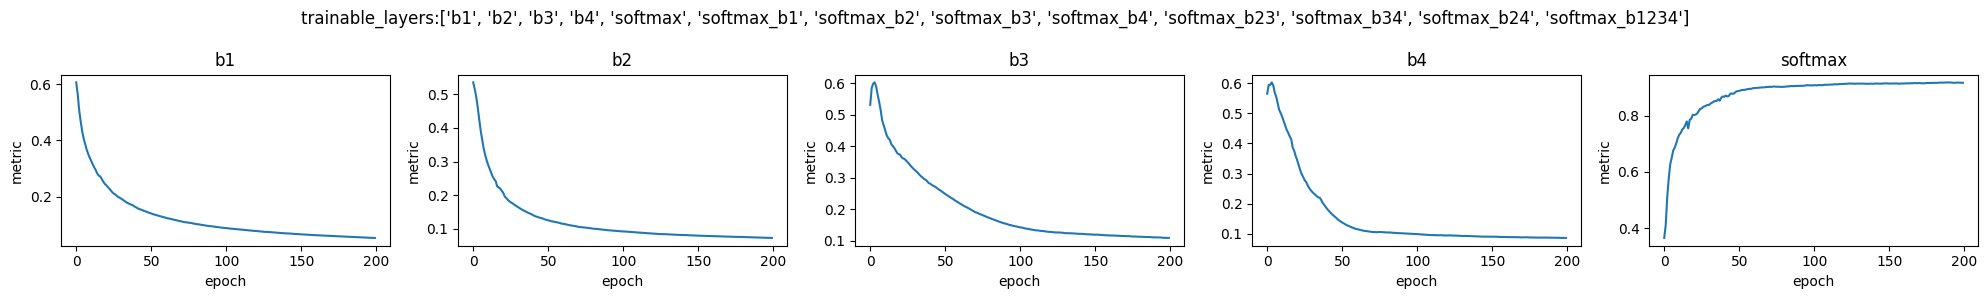

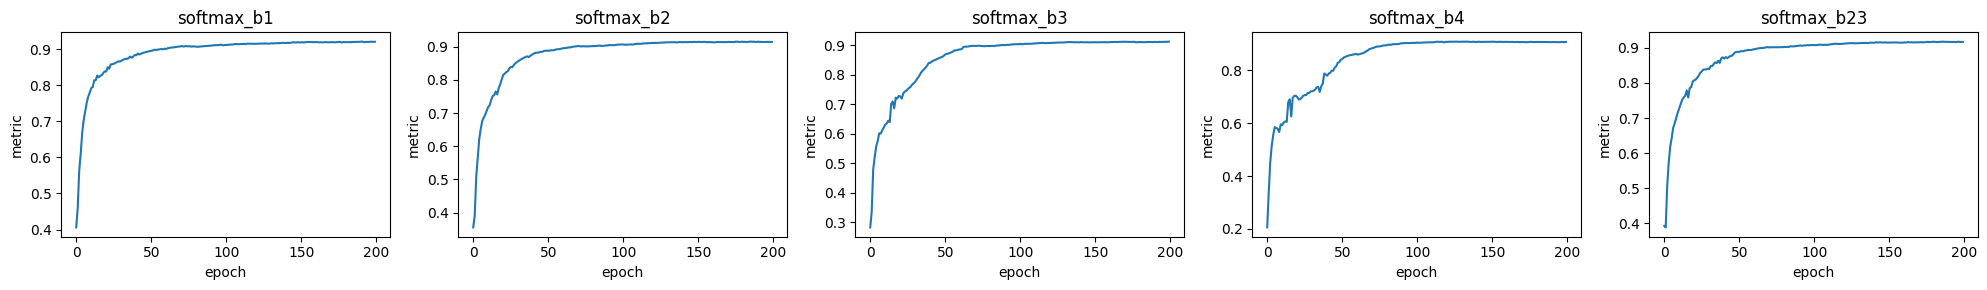

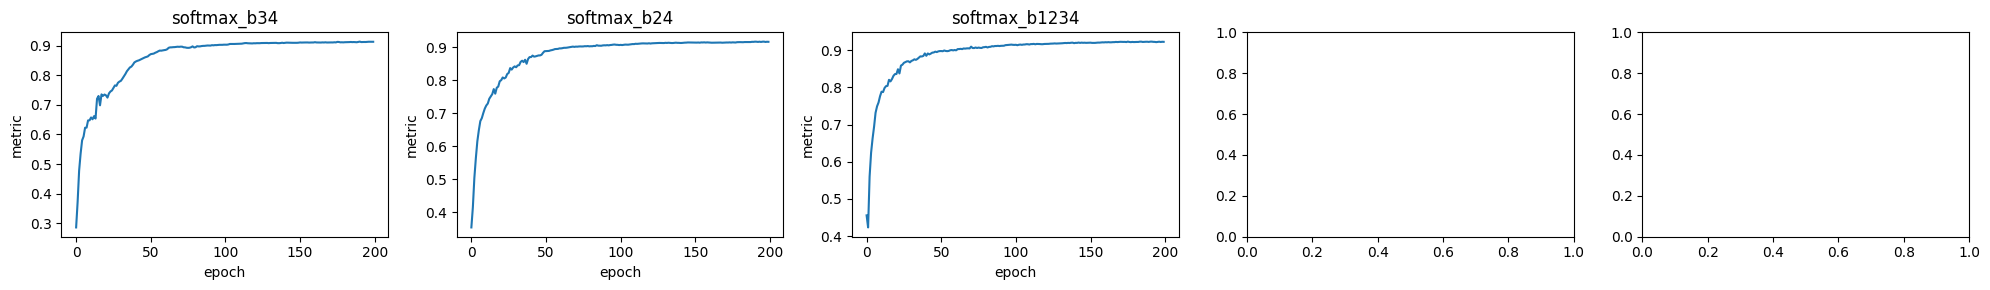

200/200 [==============================] - 666s 3s/step - b1: 0.0523 - b2: 0.0209 - b3: 0.0222 - b4: 0.0226 - softmax: 0.9014 - softmax_b1: 0.9202 - softmax_b2: 0.8972 - softmax_b3: 0.8428 - softmax_b4: 0.7601 - softmax_b23: 0.9012 - softmax_b34: 0.8419 - softmax_b24: 0.8995 - softmax_b1234: 0.9201 - best_softmax: 0.9014 - best_softmax_b1: 0.9206 - best_softmax_b2: 0.8974 - best_softmax_b3: 0.8449 - best_softmax_b4: 0.7629 - best_softmax_b23: 0.9015 - best_softmax_b34: 0.8441 - best_softmax_b24: 0.9001 - best_softmax_b1234: 0.9209


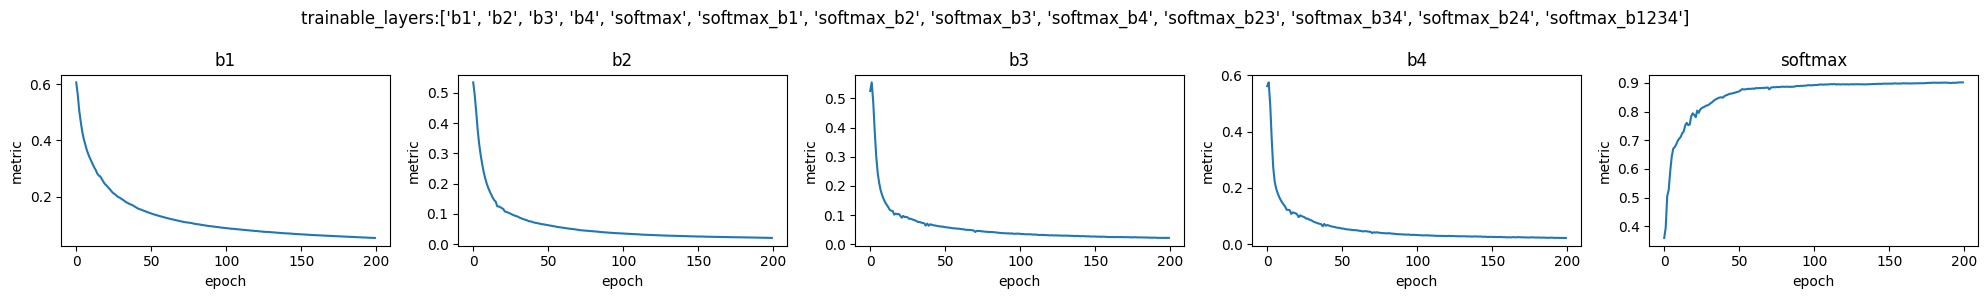

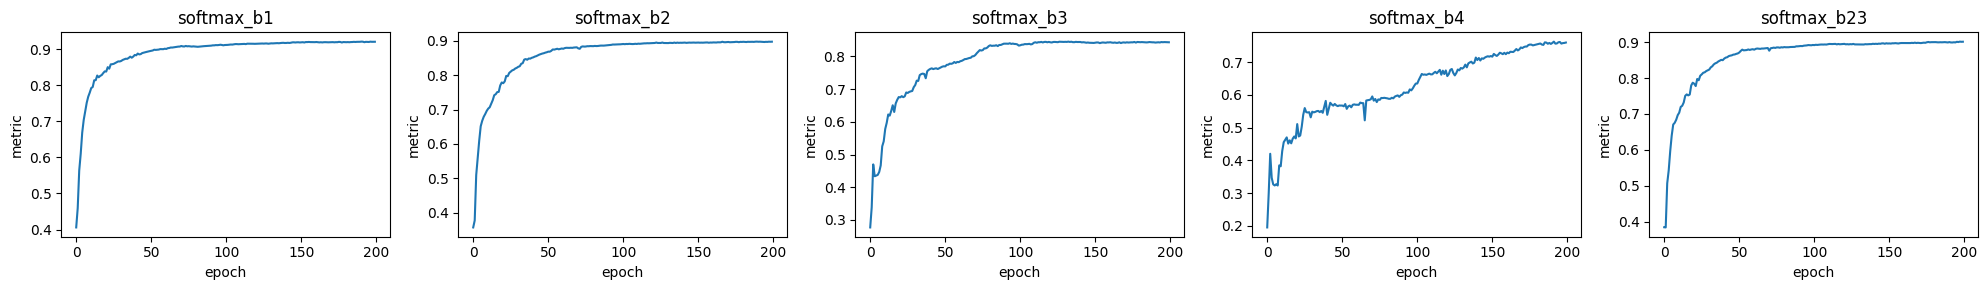

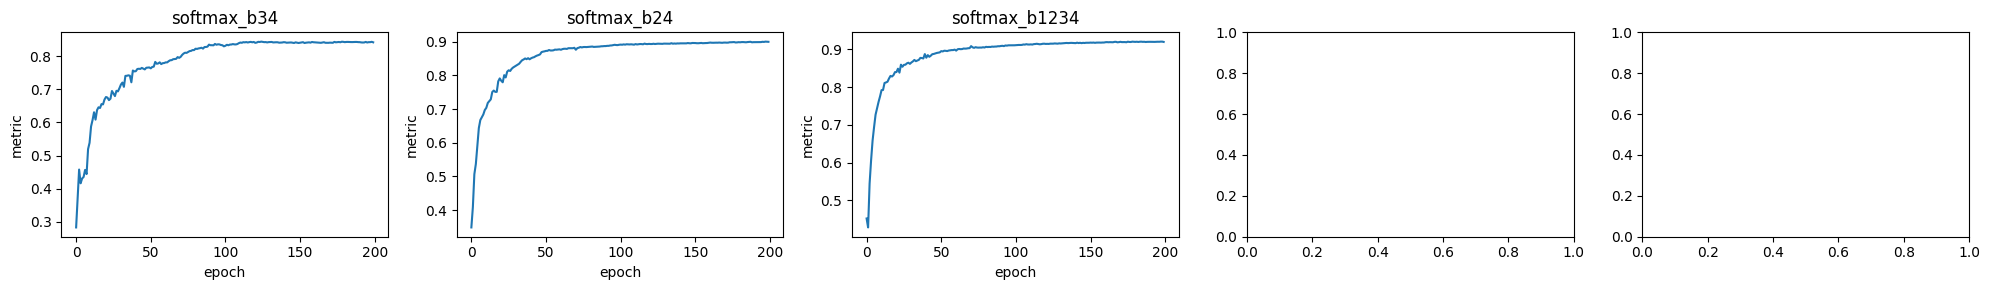

200/200 [==============================] - 660s 3s/step - b1: 0.0359 - b2: 0.0932 - b3: 0.0486 - b4: 0.1488 - softmax: 0.8974 - softmax_b1: 0.9174 - softmax_b2: 0.8853 - softmax_b3: 0.8766 - softmax_b4: 0.8681 - softmax_b23: 0.8976 - softmax_b34: 0.8852 - softmax_b24: 0.8921 - softmax_b1234: 0.9245 - best_softmax: 0.9005 - best_softmax_b1: 0.9179 - best_softmax_b2: 0.8931 - best_softmax_b3: 0.8801 - best_softmax_b4: 0.8728 - best_softmax_b23: 0.9005 - best_softmax_b34: 0.8860 - best_softmax_b24: 0.8972 - best_softmax_b1234: 0.9249


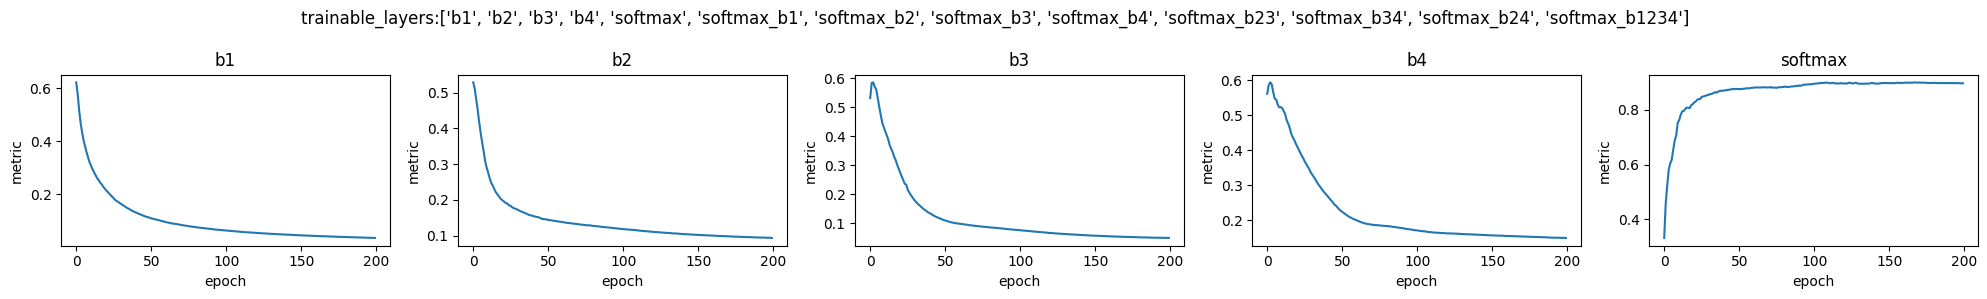

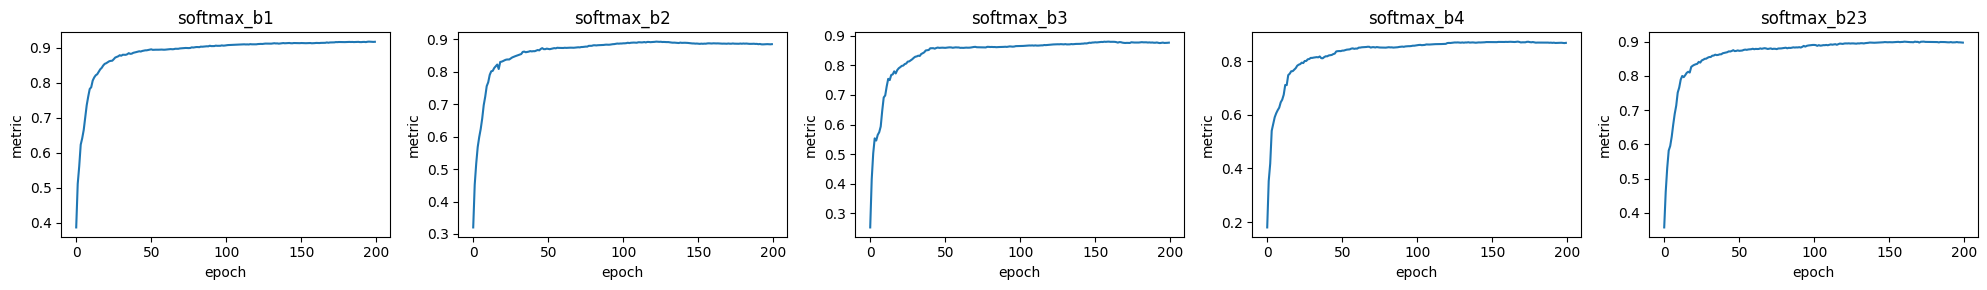

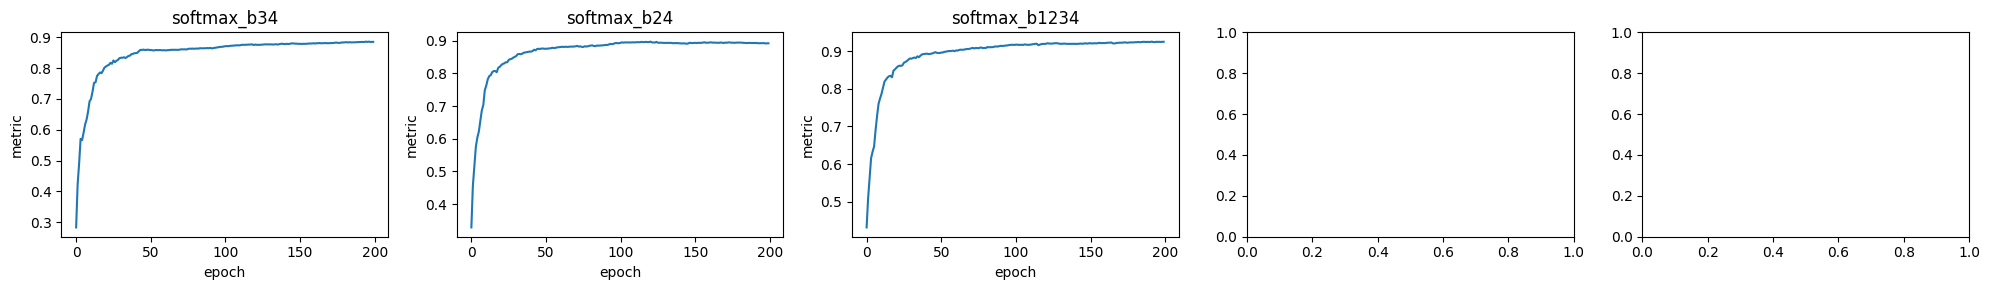

200/200 [==============================] - 663s 3s/step - b1: 0.0359 - b2: 0.0094 - b3: 0.0103 - b4: 0.0096 - softmax: 0.8706 - softmax_b1: 0.9174 - softmax_b2: 0.8671 - softmax_b3: 0.7596 - softmax_b4: 0.5305 - softmax_b23: 0.8685 - softmax_b34: 0.7731 - softmax_b24: 0.8711 - softmax_b1234: 0.9163 - best_softmax: 0.8724 - best_softmax_b1: 0.9179 - best_softmax_b2: 0.8707 - best_softmax_b3: 0.7888 - best_softmax_b4: 0.5607 - best_softmax_b23: 0.8705 - best_softmax_b34: 0.7906 - best_softmax_b24: 0.8738 - best_softmax_b1234: 0.9170


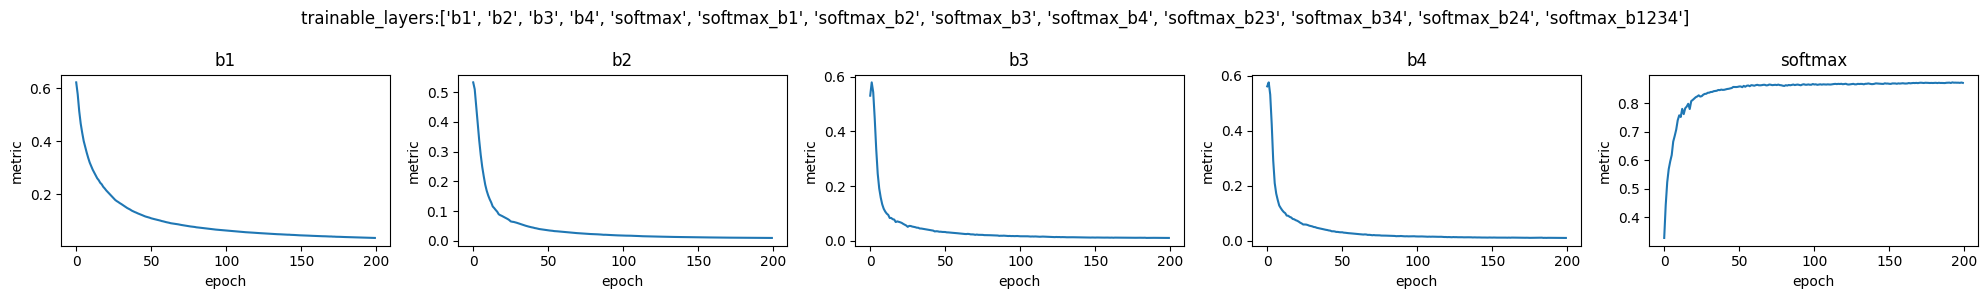

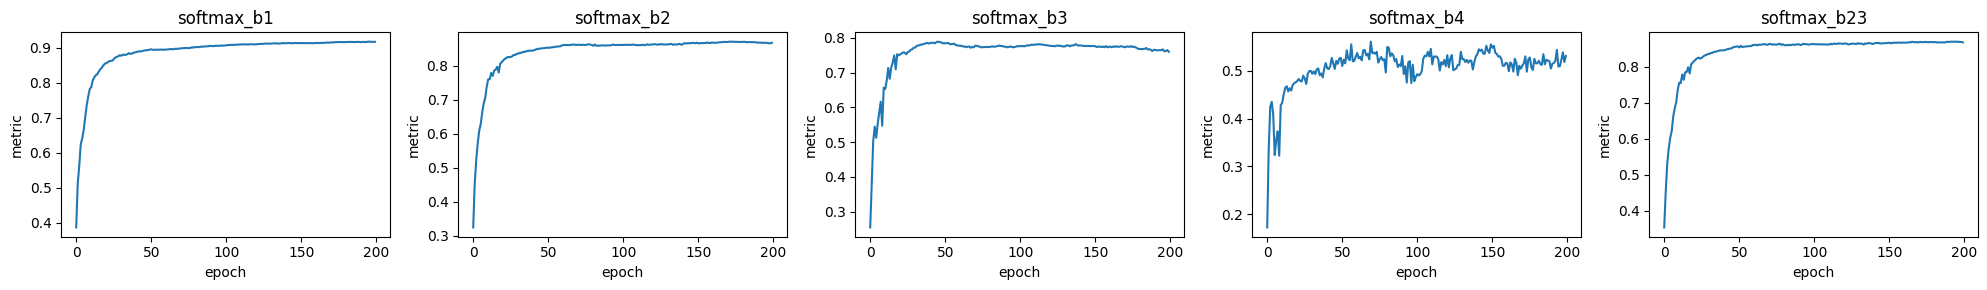

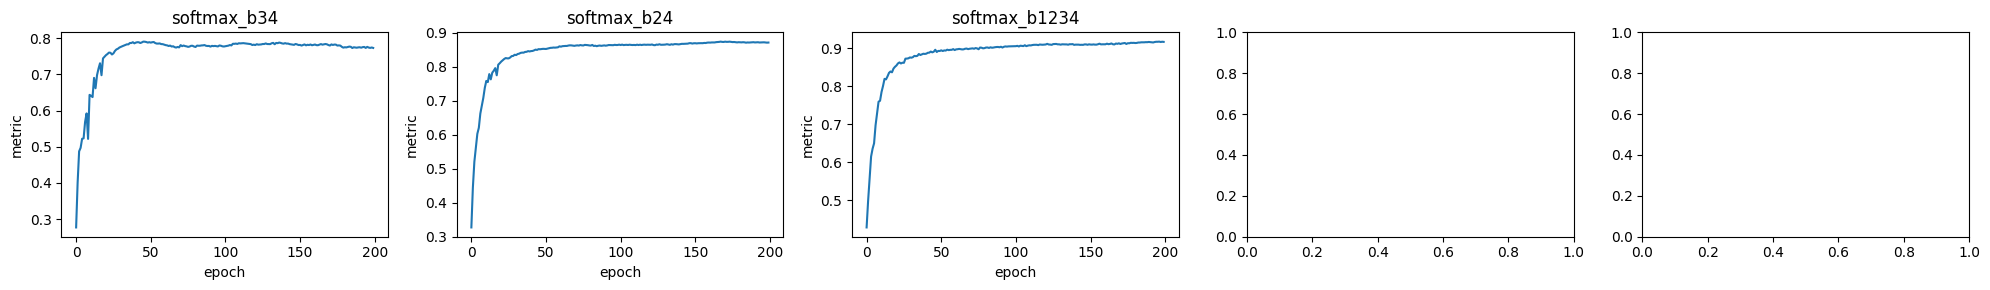

200/200 [==============================] - 663s 3s/step - b1: 0.0417 - b2: 0.0766 - b3: 0.0841 - b4: 0.1127 - softmax: 0.9208 - softmax_b1: 0.9230 - softmax_b2: 0.9181 - softmax_b3: 0.9090 - softmax_b4: 0.8949 - softmax_b23: 0.9214 - softmax_b34: 0.9050 - softmax_b24: 0.9195 - softmax_b1234: 0.9302 - best_softmax: 0.9210 - best_softmax_b1: 0.9241 - best_softmax_b2: 0.9183 - best_softmax_b3: 0.9093 - best_softmax_b4: 0.8963 - best_softmax_b23: 0.9224 - best_softmax_b34: 0.9050 - best_softmax_b24: 0.9195 - best_softmax_b1234: 0.9321


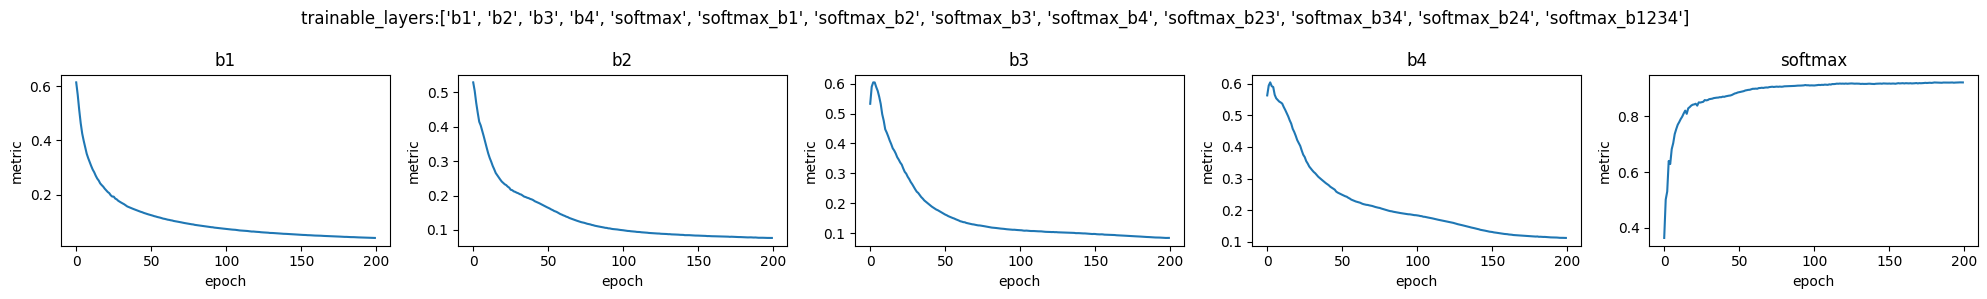

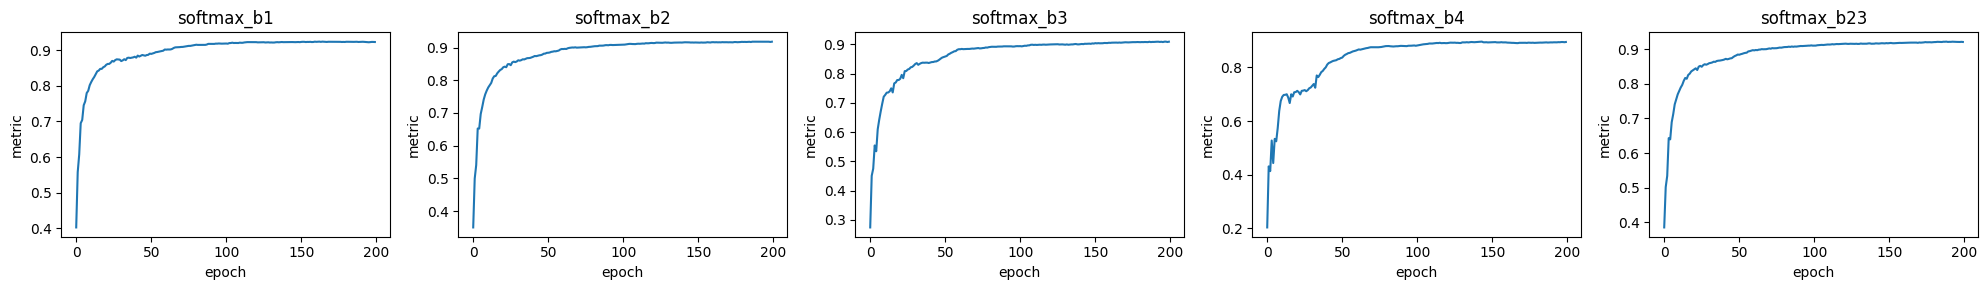

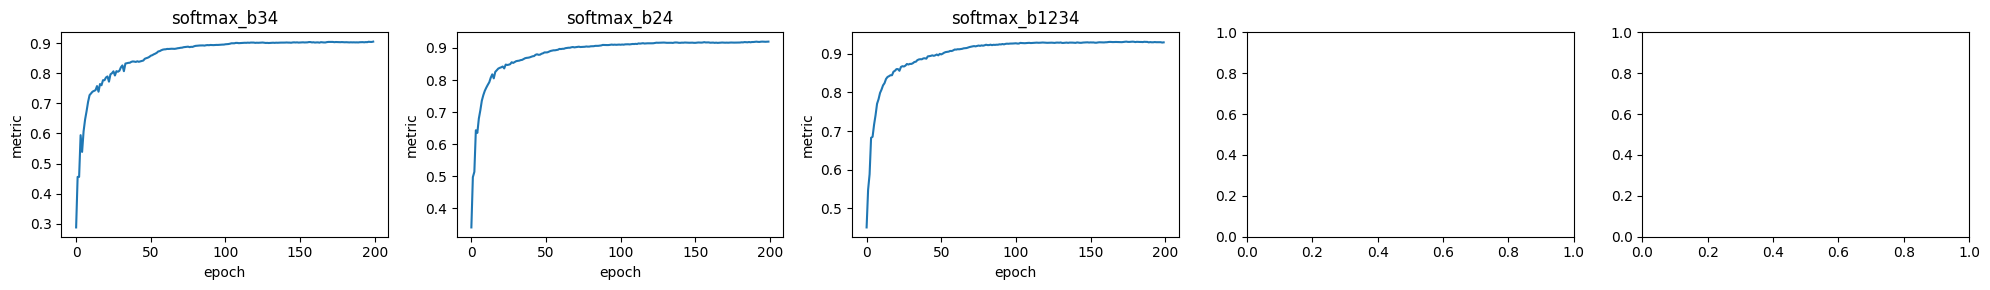

200/200 [==============================] - 664s 3s/step - b1: 0.0417 - b2: 0.0158 - b3: 0.0168 - b4: 0.0159 - softmax: 0.8906 - softmax_b1: 0.9230 - softmax_b2: 0.8891 - softmax_b3: 0.8019 - softmax_b4: 0.6679 - softmax_b23: 0.8899 - softmax_b34: 0.8105 - softmax_b24: 0.8891 - softmax_b1234: 0.9233 - best_softmax: 0.8926 - best_softmax_b1: 0.9241 - best_softmax_b2: 0.8927 - best_softmax_b3: 0.8021 - best_softmax_b4: 0.6715 - best_softmax_b23: 0.8937 - best_softmax_b34: 0.8105 - best_softmax_b24: 0.8921 - best_softmax_b1234: 0.9254


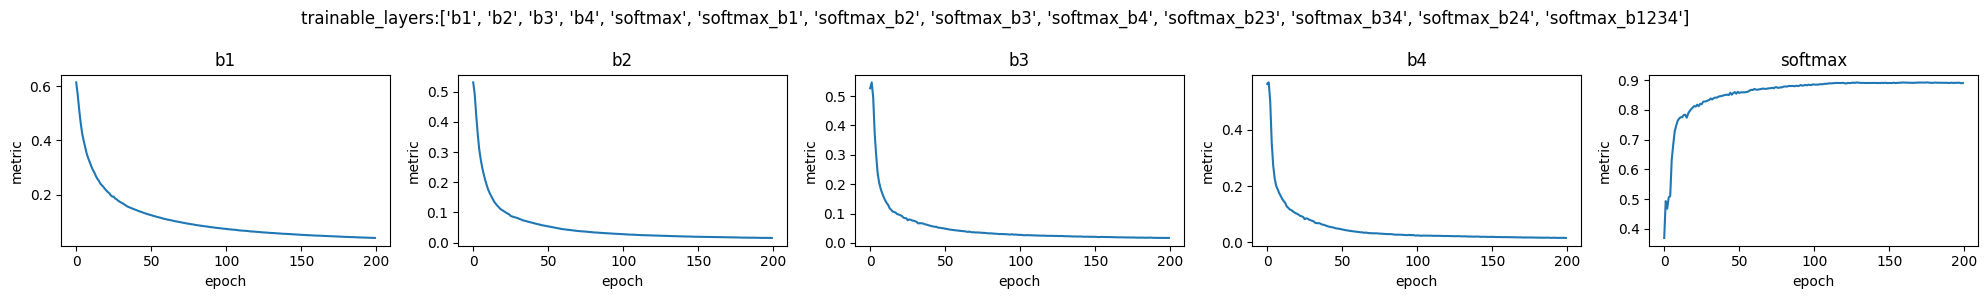

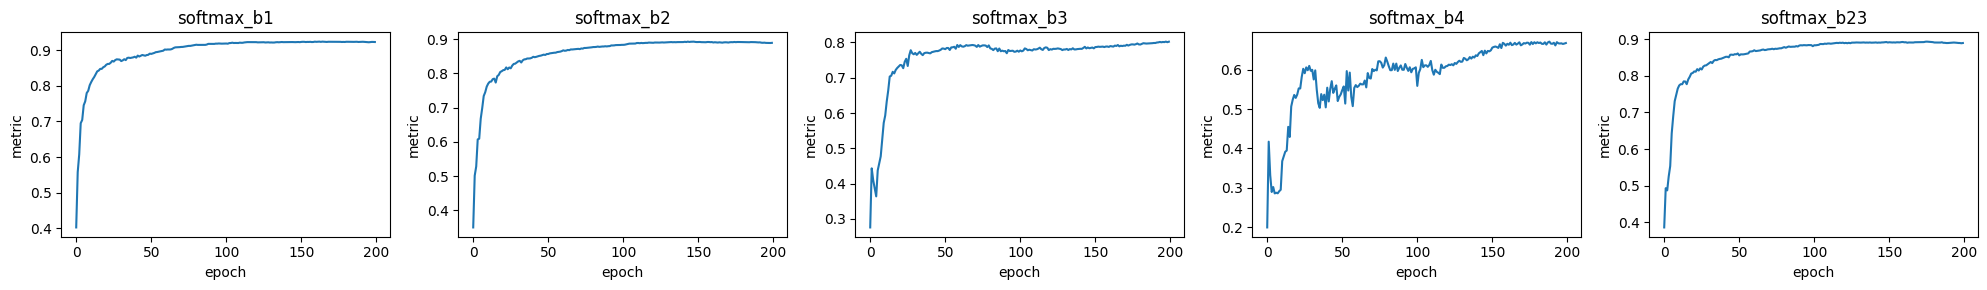

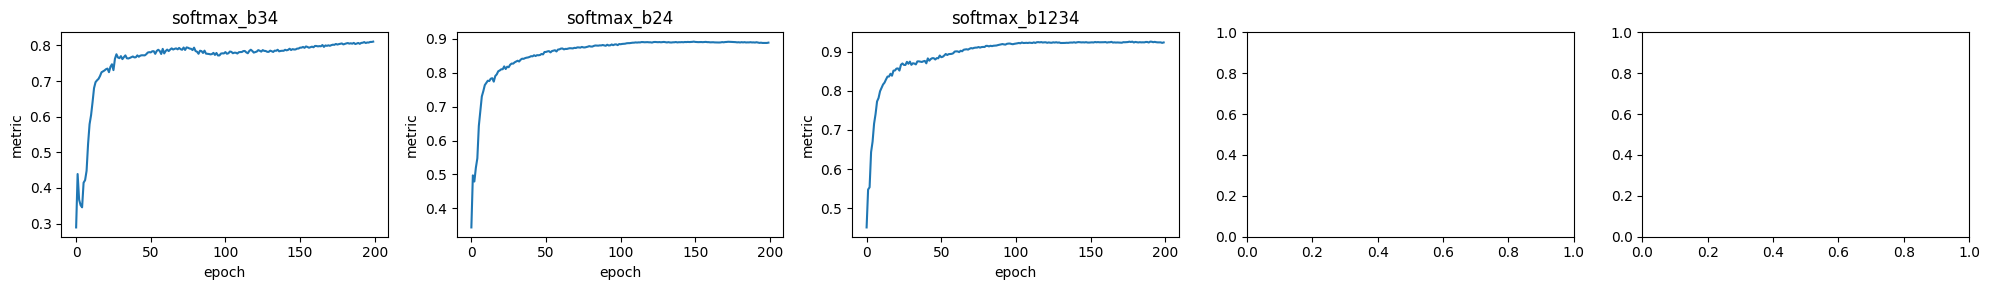

200/200 [==============================] - 659s 3s/step - b1: 0.0407 - b2: 0.0934 - b3: 0.1099 - b4: 0.0792 - softmax: 0.9114 - softmax_b1: 0.9141 - softmax_b2: 0.9084 - softmax_b3: 0.8986 - softmax_b4: 0.8949 - softmax_b23: 0.9107 - softmax_b34: 0.9014 - softmax_b24: 0.9101 - softmax_b1234: 0.9210 - best_softmax: 0.9116 - best_softmax_b1: 0.9145 - best_softmax_b2: 0.9084 - best_softmax_b3: 0.8986 - best_softmax_b4: 0.8962 - best_softmax_b23: 0.9107 - best_softmax_b34: 0.9022 - best_softmax_b24: 0.9106 - best_softmax_b1234: 0.9213


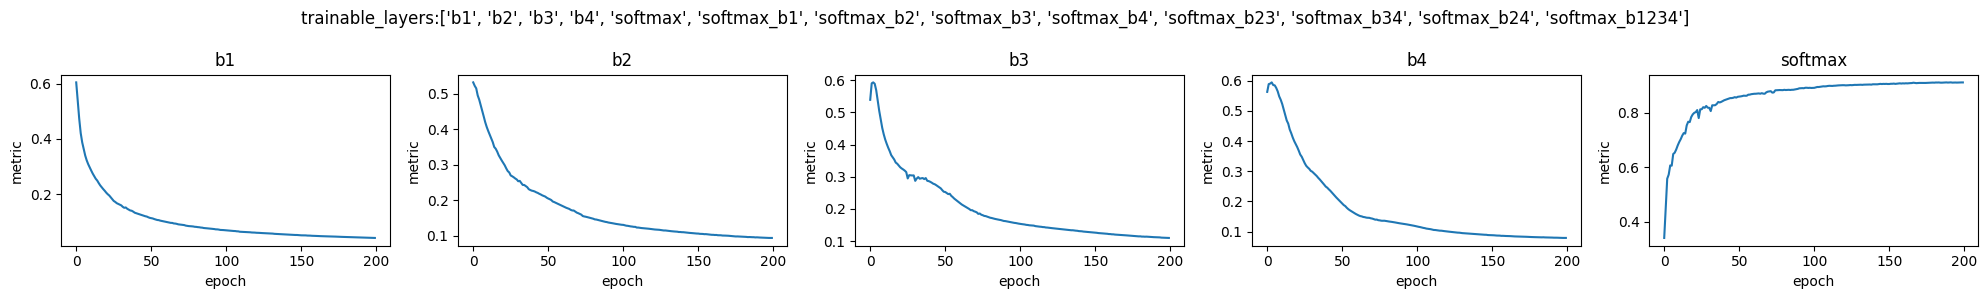

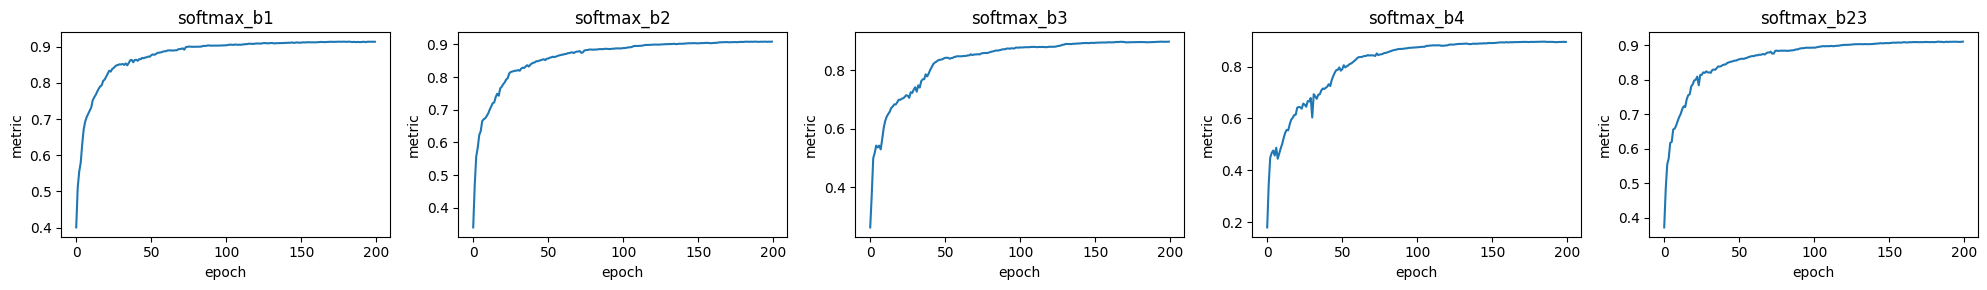

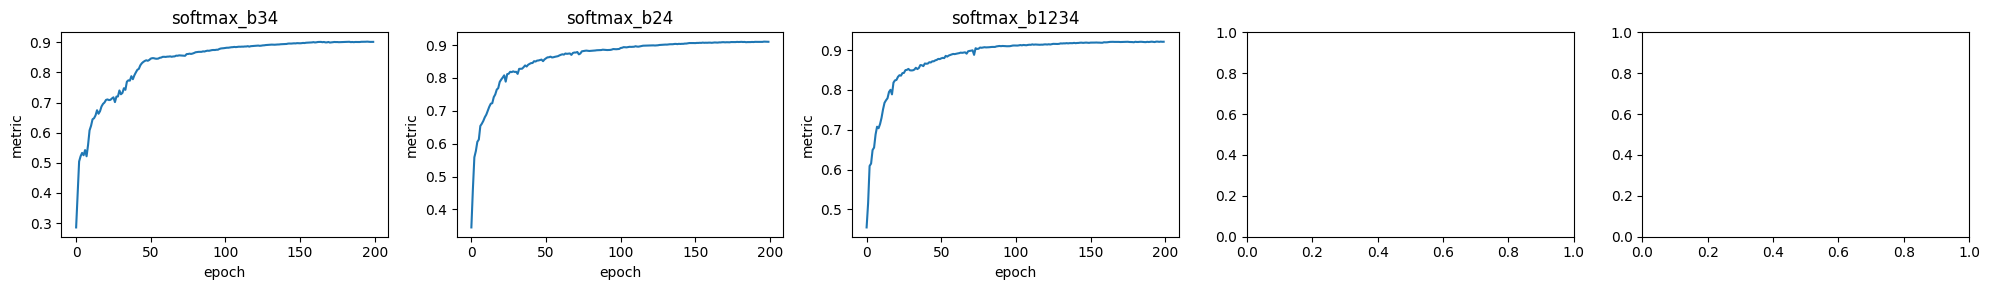

200/200 [==============================] - 658s 3s/step - b1: 0.0407 - b2: 0.0120 - b3: 0.0131 - b4: 0.0119 - softmax: 0.8748 - softmax_b1: 0.9141 - softmax_b2: 0.8723 - softmax_b3: 0.7464 - softmax_b4: 0.4292 - softmax_b23: 0.8734 - softmax_b34: 0.7524 - softmax_b24: 0.8740 - softmax_b1234: 0.9143 - best_softmax: 0.8784 - best_softmax_b1: 0.9145 - best_softmax_b2: 0.8723 - best_softmax_b3: 0.7867 - best_softmax_b4: 0.5527 - best_softmax_b23: 0.8745 - best_softmax_b34: 0.7847 - best_softmax_b24: 0.8744 - best_softmax_b1234: 0.9147


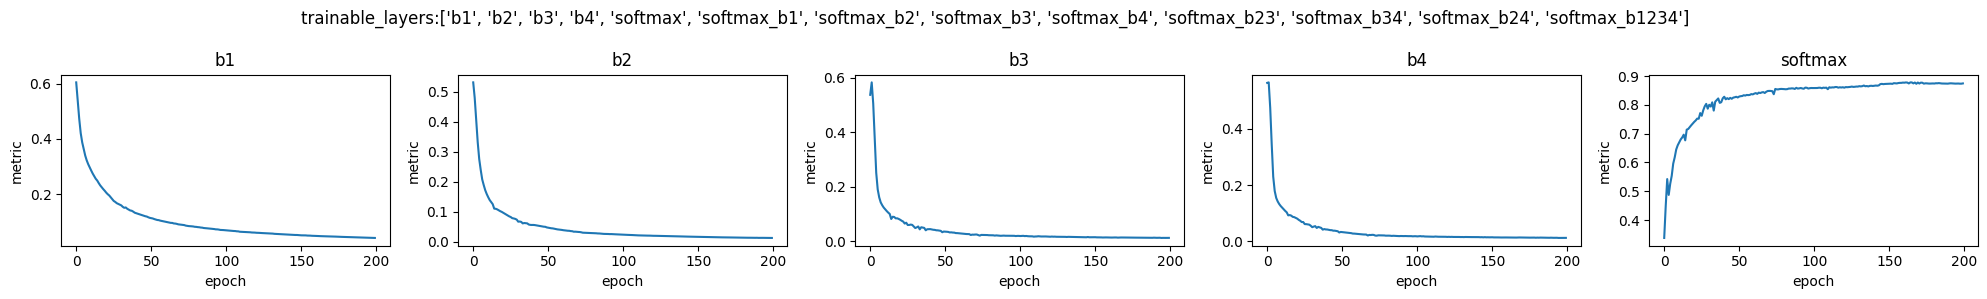

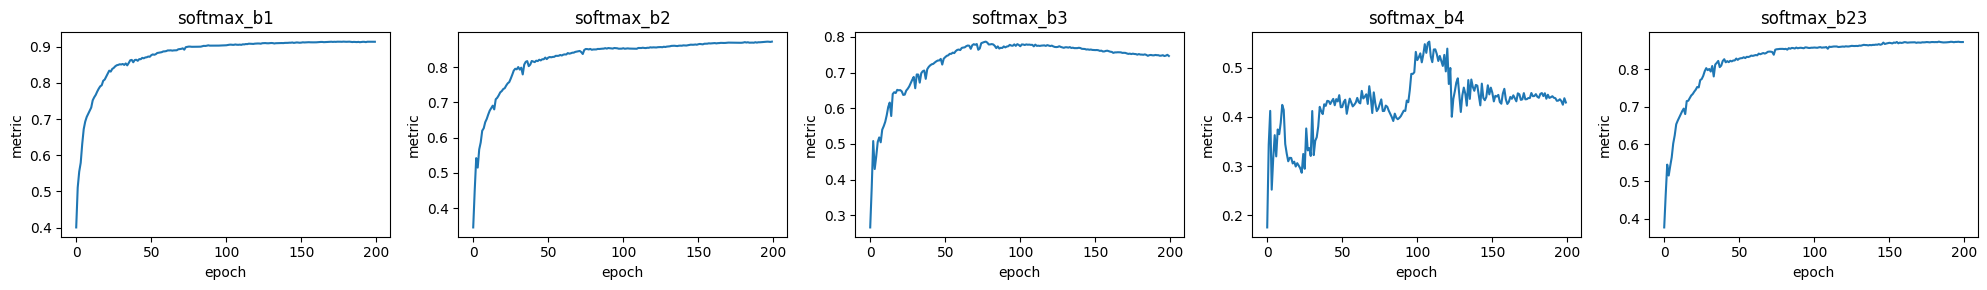

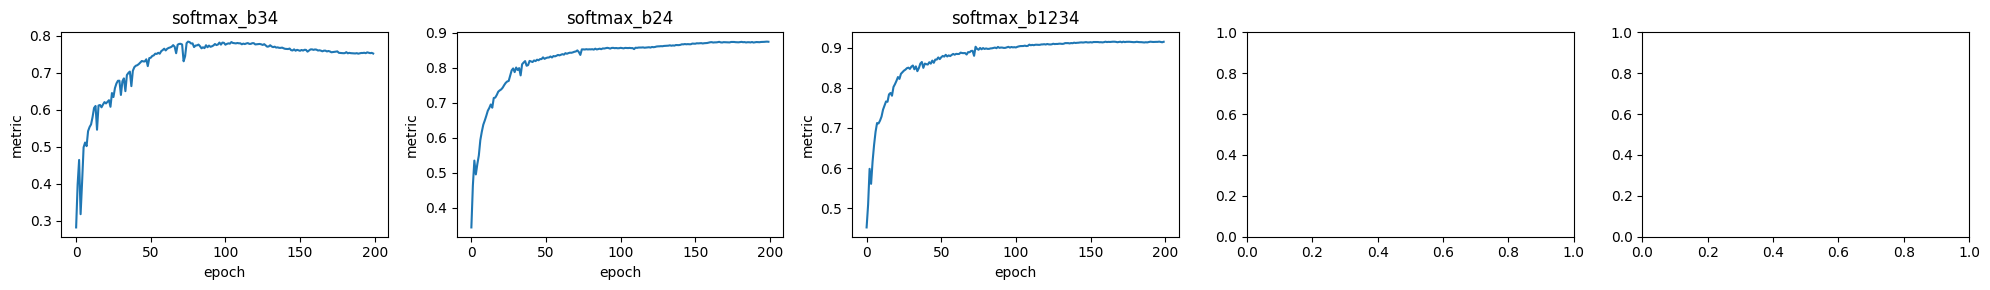

In [3]:
for i in range(10):
    for route_split_mode in ['RandomSplitting', 'NoSplitting']:
        train_mgr0 = train_layers(
            units = 100,              # number of units in each hidden layer
            is_supervised_ff = False, # unsupervised-FF
            batch_size = 256,         # batch size
            data_shuffle_seed = 10,   # Set this to None for no shuffling, otherwise will reshuffle every epoch
            trainable_layers_list = [
                [['b1', 'b2', 'b3', 'b4', 'softmax', 
                  'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4', 
                 ], 200], # 200 epochs of training listed layers
            ],
            show_metrics_max = ['softmax', 'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4'], # show maximum softmax so far
            route_seed = i,
            route_split_mode = route_split_mode,
        )

# 2. Experiment 2 - `units = 200`

200/200 [==============================] - 981s 5s/step - b1: 0.0471 - b2: 0.0410 - b3: 0.0670 - b4: 0.0809 - softmax: 0.9431 - softmax_b1: 0.9520 - softmax_b2: 0.9376 - softmax_b3: 0.9364 - softmax_b4: 0.9307 - softmax_b23: 0.9436 - softmax_b34: 0.9372 - softmax_b24: 0.9422 - softmax_b1234: 0.9521 - best_softmax: 0.9433 - best_softmax_b1: 0.9523 - best_softmax_b2: 0.9411 - best_softmax_b3: 0.9364 - best_softmax_b4: 0.9332 - best_softmax_b23: 0.9436 - best_softmax_b34: 0.9377 - best_softmax_b24: 0.9426 - best_softmax_b1234: 0.9530


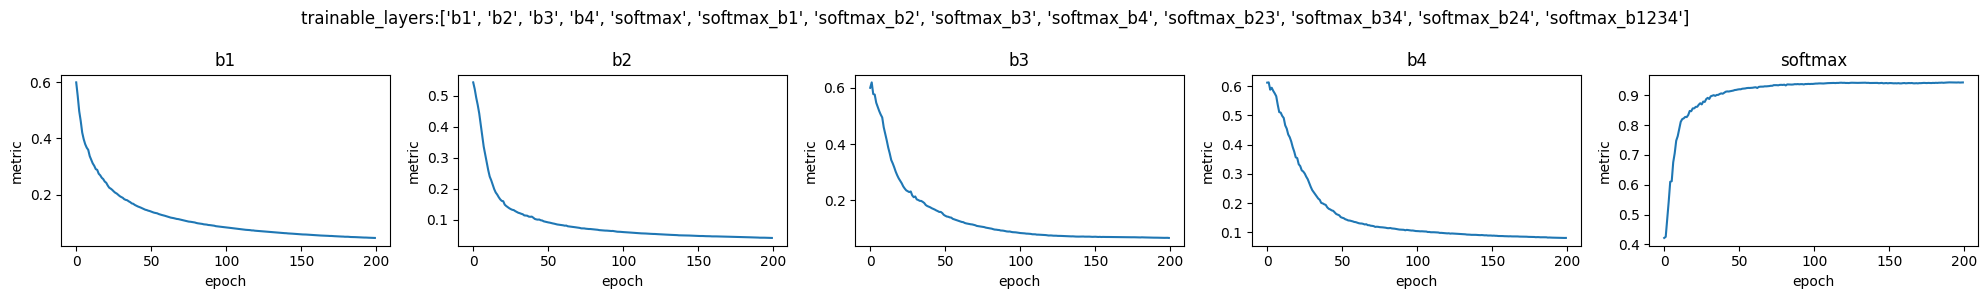

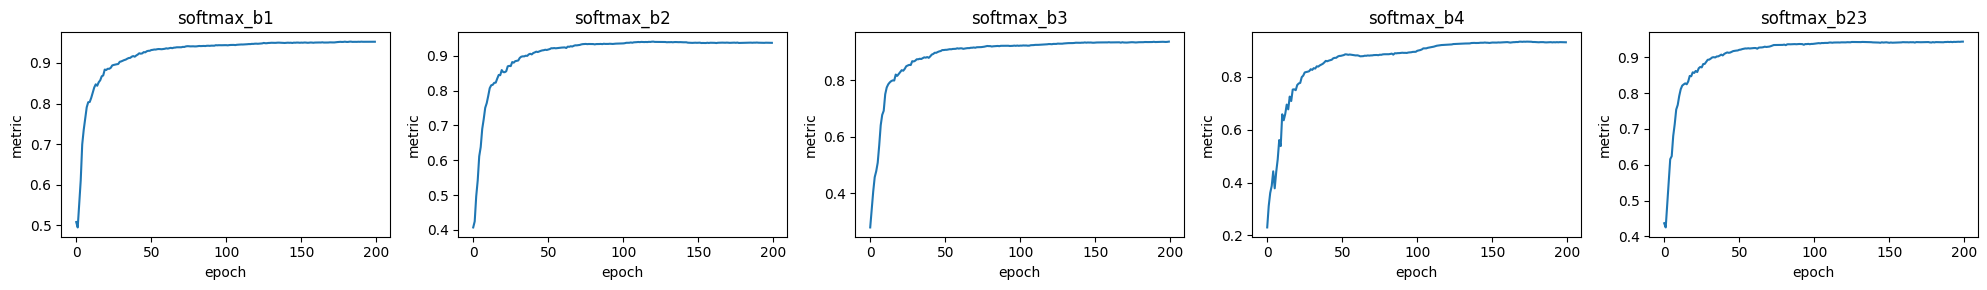

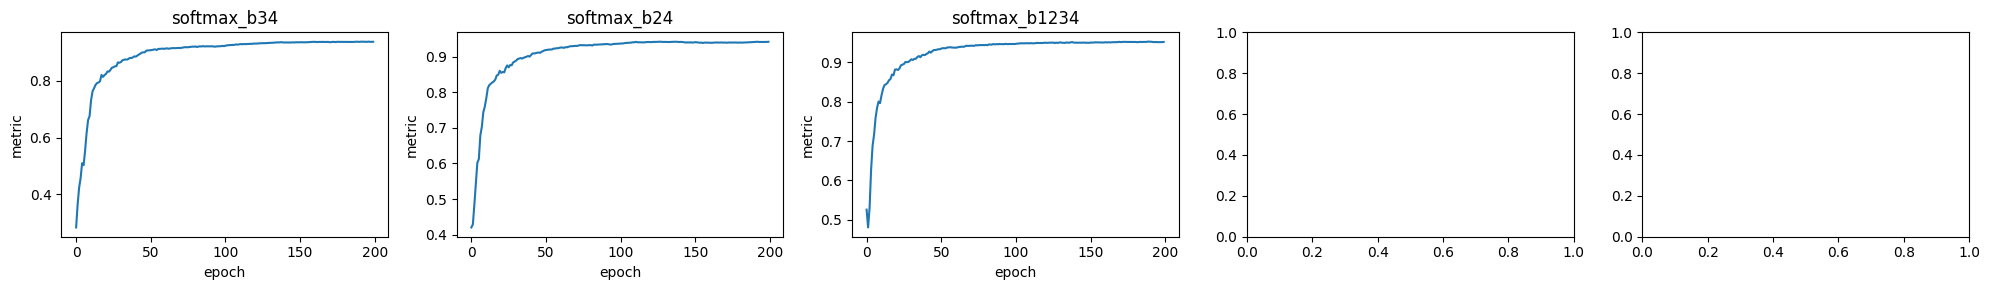

200/200 [==============================] - 975s 5s/step - b1: 0.0471 - b2: 0.0134 - b3: 0.0153 - b4: 0.0149 - softmax: 0.9267 - softmax_b1: 0.9520 - softmax_b2: 0.9252 - softmax_b3: 0.8528 - softmax_b4: 0.7047 - softmax_b23: 0.9256 - softmax_b34: 0.8539 - softmax_b24: 0.9247 - softmax_b1234: 0.9520 - best_softmax: 0.9267 - best_softmax_b1: 0.9523 - best_softmax_b2: 0.9259 - best_softmax_b3: 0.8711 - best_softmax_b4: 0.7652 - best_softmax_b23: 0.9268 - best_softmax_b34: 0.8685 - best_softmax_b24: 0.9262 - best_softmax_b1234: 0.9526


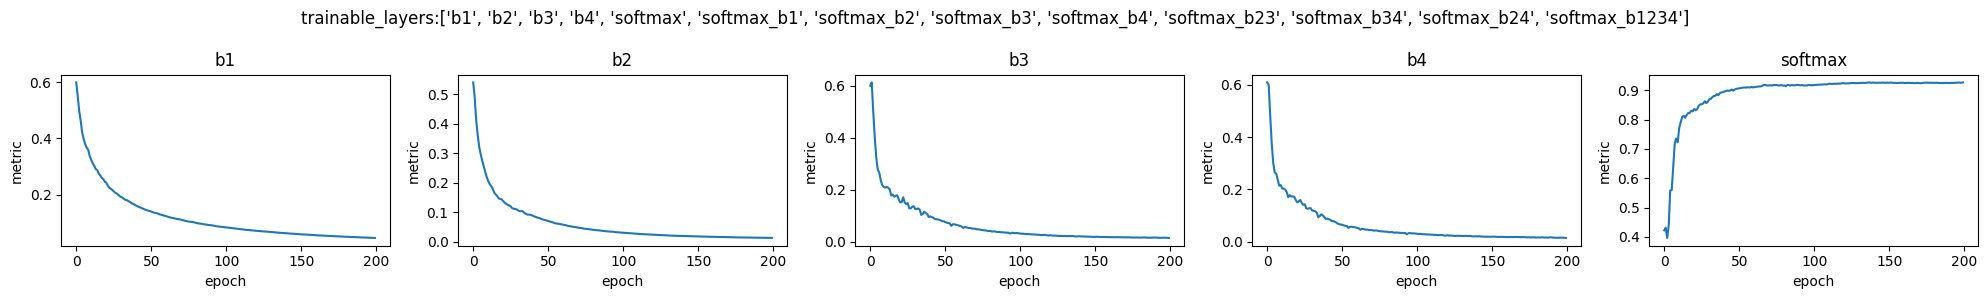

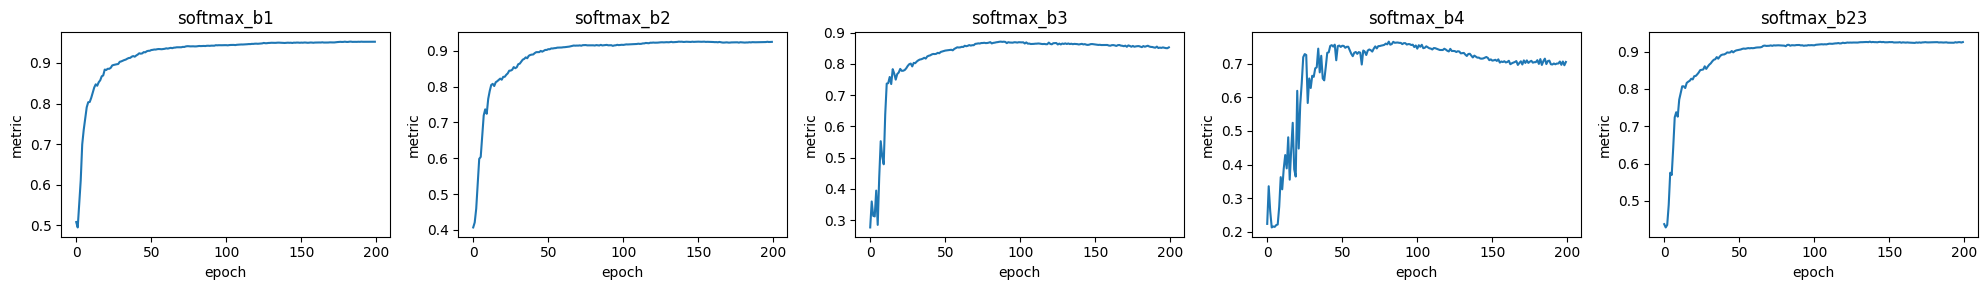

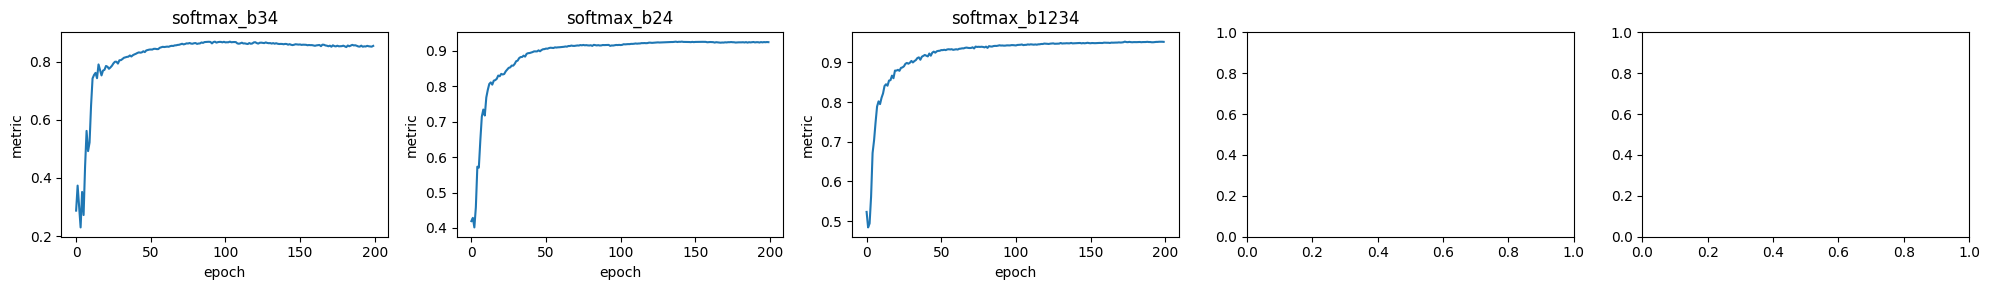

200/200 [==============================] - 975s 5s/step - b1: 0.0457 - b2: 0.0440 - b3: 0.0568 - b4: 0.0479 - softmax: 0.9475 - softmax_b1: 0.9501 - softmax_b2: 0.9437 - softmax_b3: 0.9379 - softmax_b4: 0.9197 - softmax_b23: 0.9479 - softmax_b34: 0.9378 - softmax_b24: 0.9448 - softmax_b1234: 0.9514 - best_softmax: 0.9478 - best_softmax_b1: 0.9509 - best_softmax_b2: 0.9440 - best_softmax_b3: 0.9379 - best_softmax_b4: 0.9197 - best_softmax_b23: 0.9479 - best_softmax_b34: 0.9378 - best_softmax_b24: 0.9452 - best_softmax_b1234: 0.9514


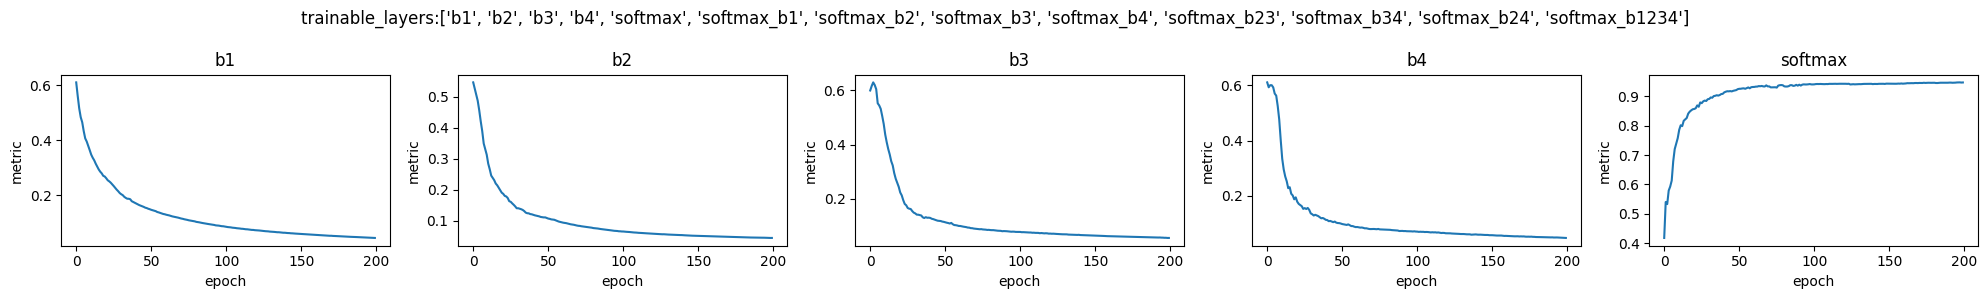

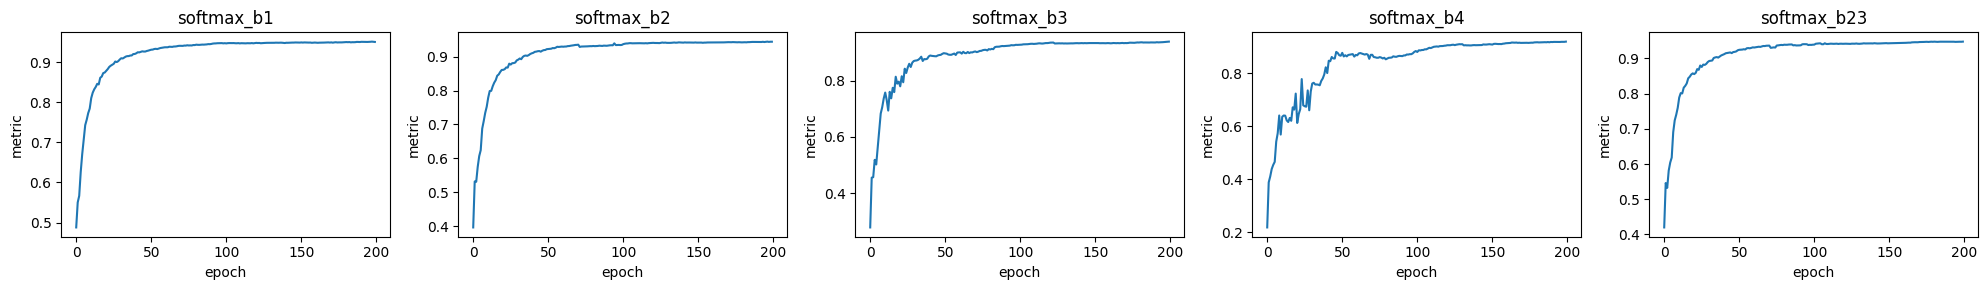

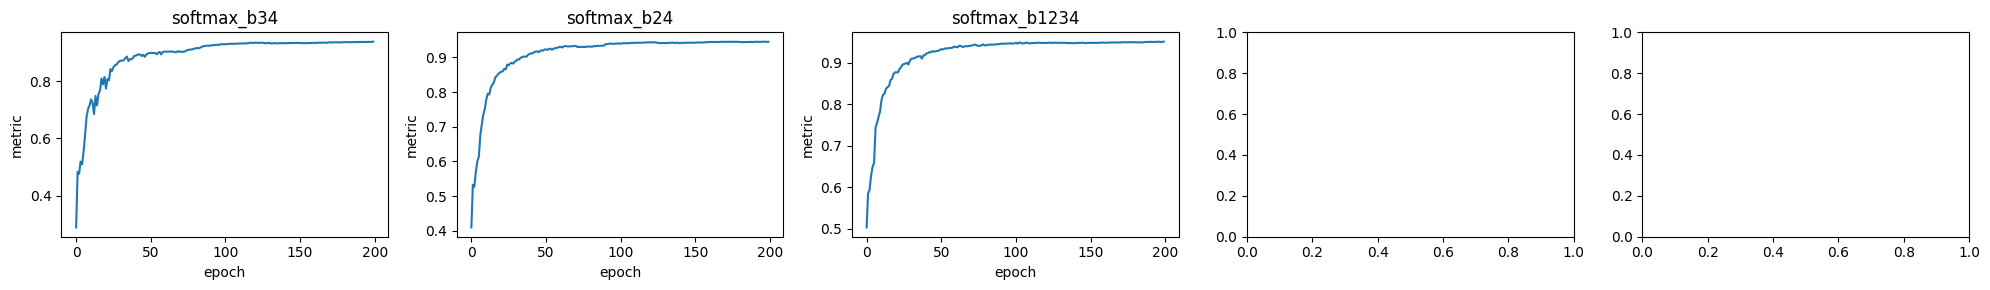

200/200 [==============================] - 980s 5s/step - b1: 0.0457 - b2: 0.0148 - b3: 0.0166 - b4: 0.0156 - softmax: 0.9249 - softmax_b1: 0.9501 - softmax_b2: 0.9235 - softmax_b3: 0.8777 - softmax_b4: 0.7134 - softmax_b23: 0.9252 - softmax_b34: 0.8788 - softmax_b24: 0.9239 - softmax_b1234: 0.9493 - best_softmax: 0.9317 - best_softmax_b1: 0.9509 - best_softmax_b2: 0.9319 - best_softmax_b3: 0.8996 - best_softmax_b4: 0.7774 - best_softmax_b23: 0.9318 - best_softmax_b34: 0.8986 - best_softmax_b24: 0.9312 - best_softmax_b1234: 0.9493


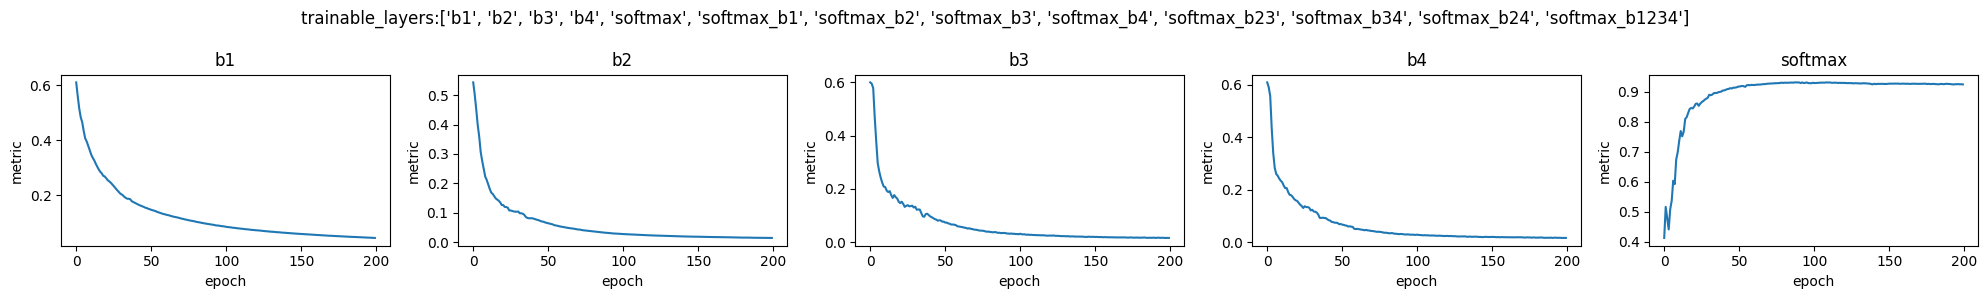

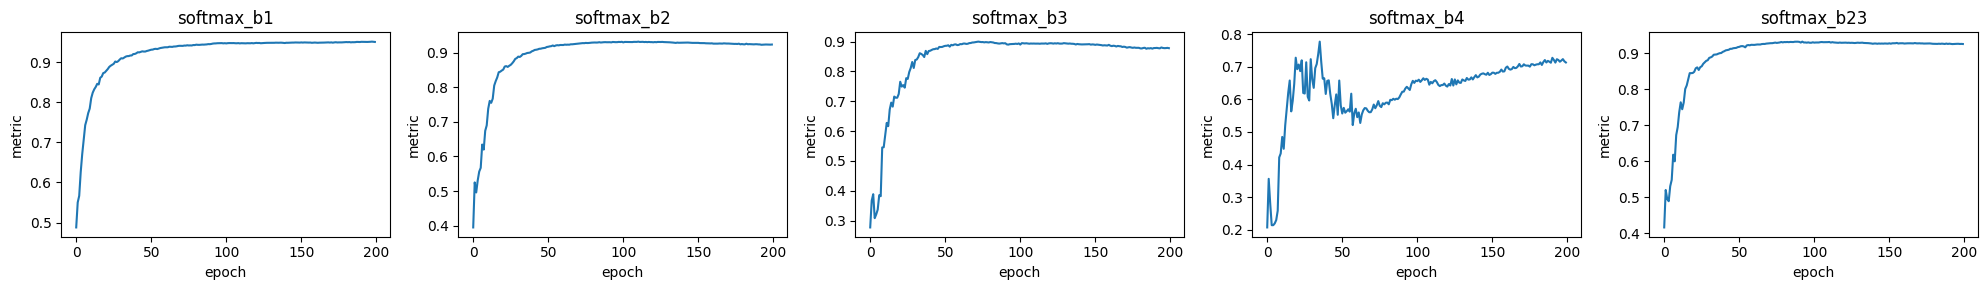

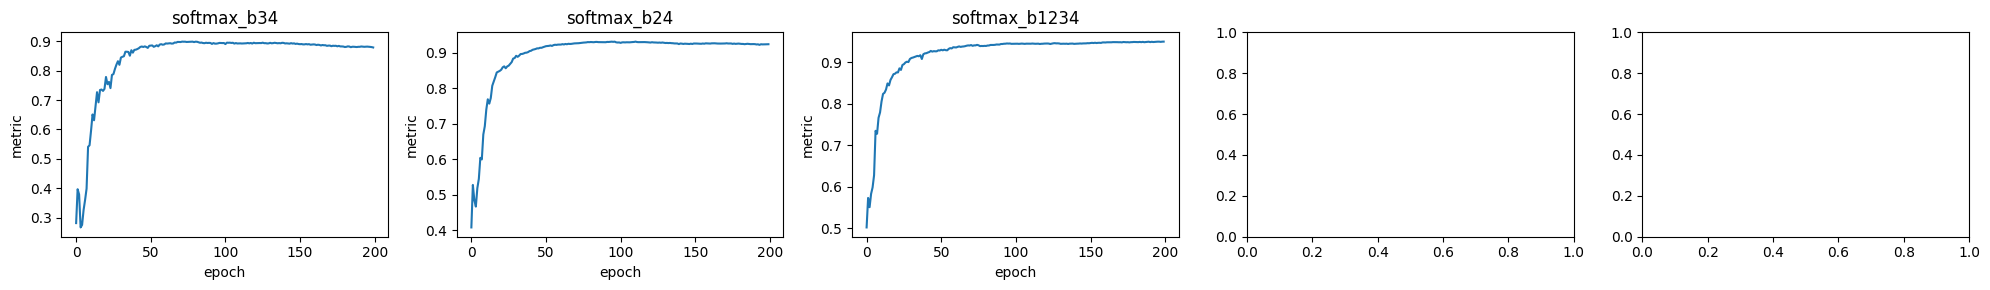

200/200 [==============================] - 983s 5s/step - b1: 0.0150 - b2: 0.0512 - b3: 0.1586 - b4: 0.1225 - softmax: 0.8941 - softmax_b1: 0.9123 - softmax_b2: 0.8775 - softmax_b3: 0.8739 - softmax_b4: 0.8557 - softmax_b23: 0.8935 - softmax_b34: 0.8766 - softmax_b24: 0.8933 - softmax_b1234: 0.9253 - best_softmax: 0.8941 - best_softmax_b1: 0.9133 - best_softmax_b2: 0.8784 - best_softmax_b3: 0.8745 - best_softmax_b4: 0.8557 - best_softmax_b23: 0.8943 - best_softmax_b34: 0.8768 - best_softmax_b24: 0.8935 - best_softmax_b1234: 0.9254


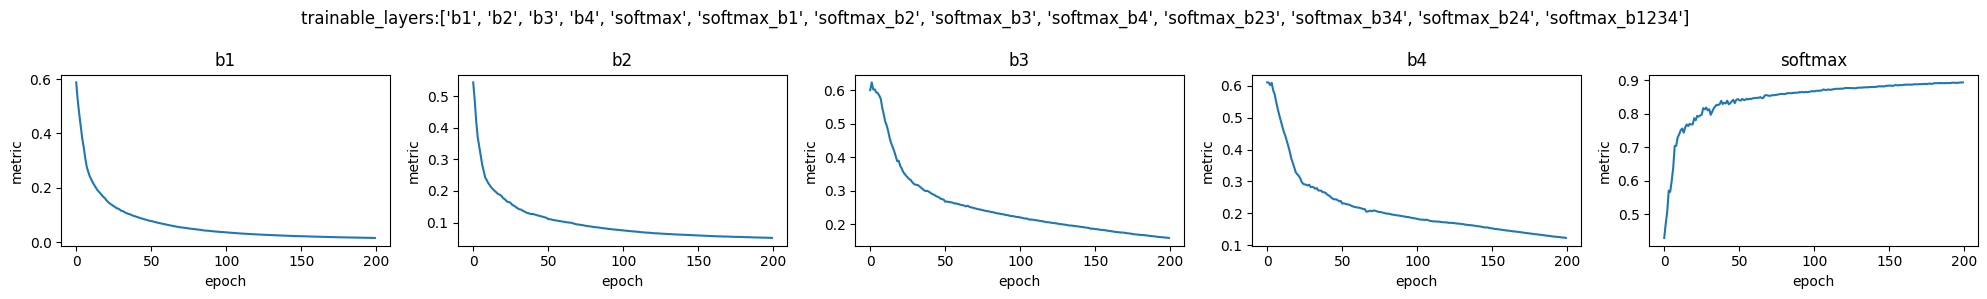

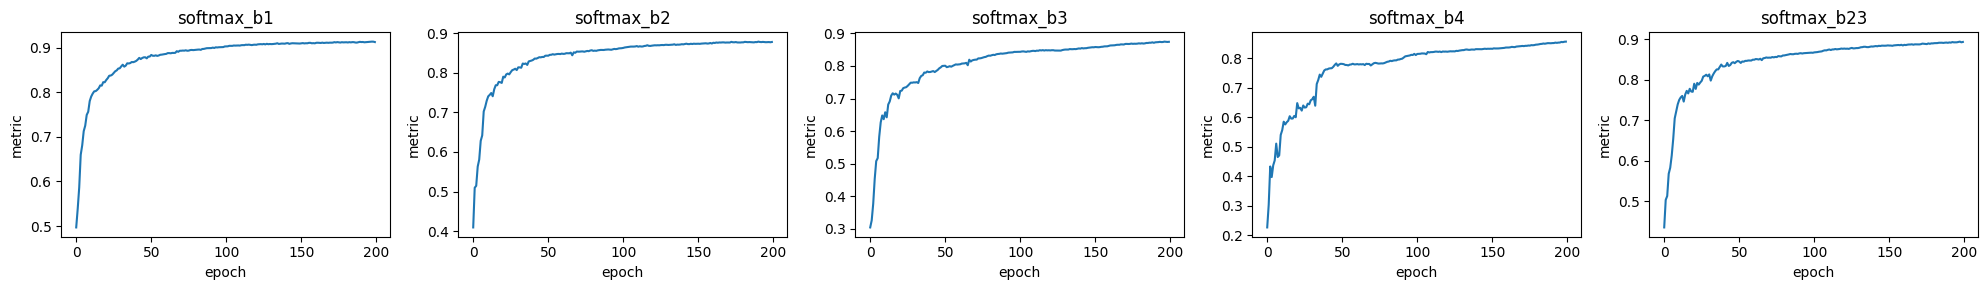

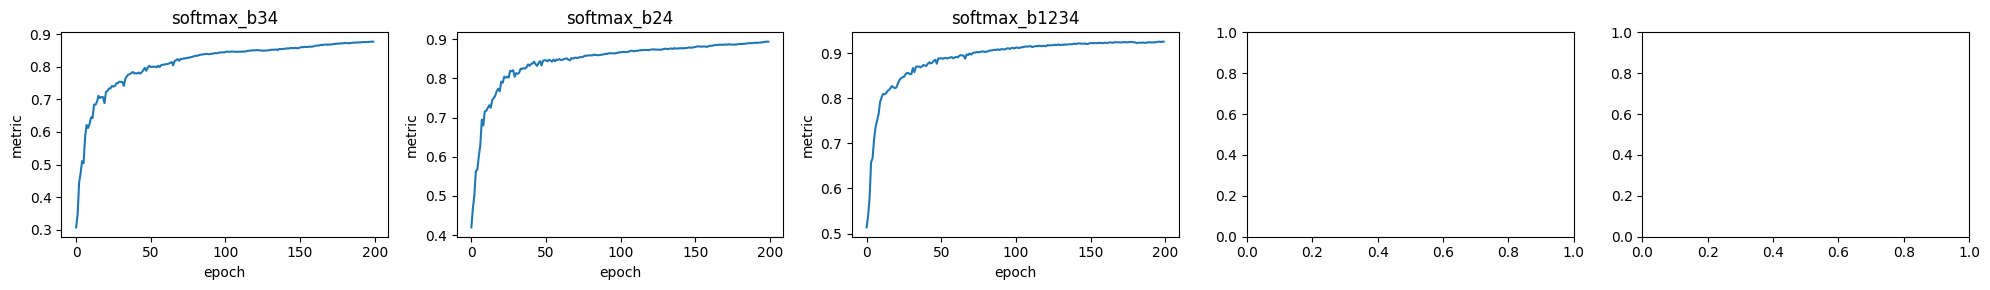

200/200 [==============================] - 987s 5s/step - b1: 0.0150 - b2: 0.0049 - b3: 0.0057 - b4: 0.0052 - softmax: 0.8703 - softmax_b1: 0.9123 - softmax_b2: 0.8667 - softmax_b3: 0.7867 - softmax_b4: 0.5949 - softmax_b23: 0.8704 - softmax_b34: 0.7879 - softmax_b24: 0.8679 - softmax_b1234: 0.9128 - best_softmax: 0.8703 - best_softmax_b1: 0.9133 - best_softmax_b2: 0.8671 - best_softmax_b3: 0.7872 - best_softmax_b4: 0.6241 - best_softmax_b23: 0.8704 - best_softmax_b34: 0.7879 - best_softmax_b24: 0.8692 - best_softmax_b1234: 0.9138


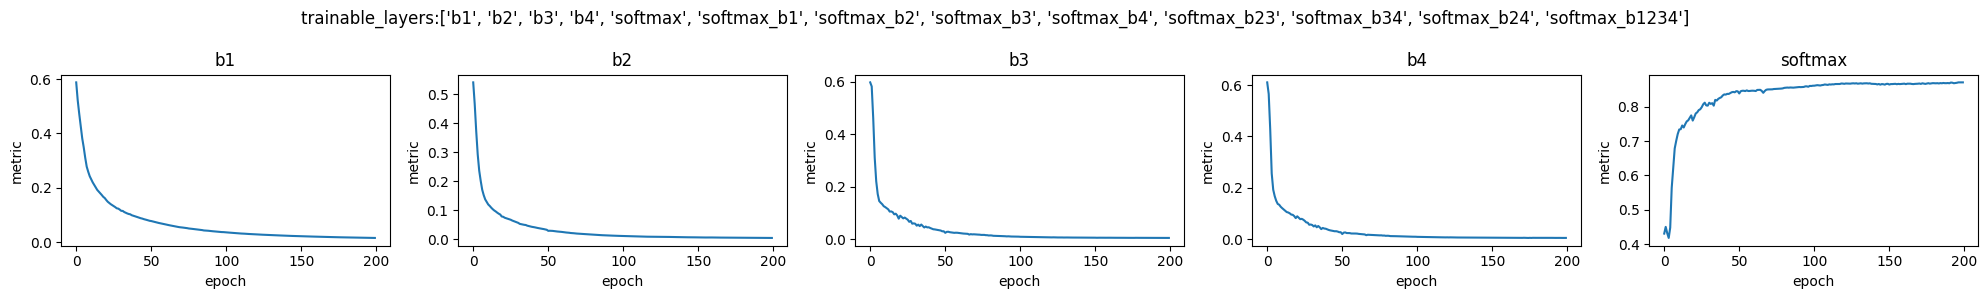

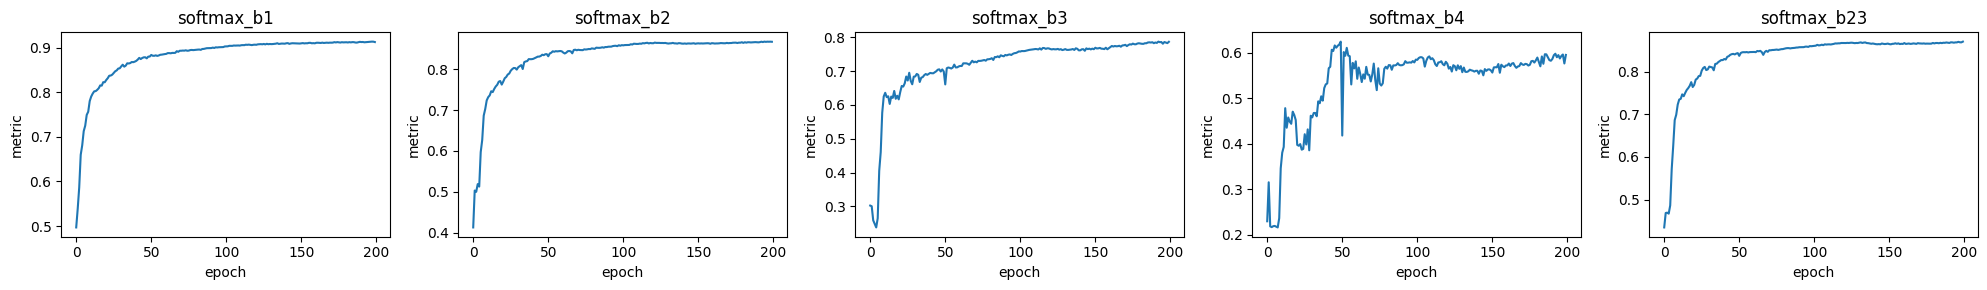

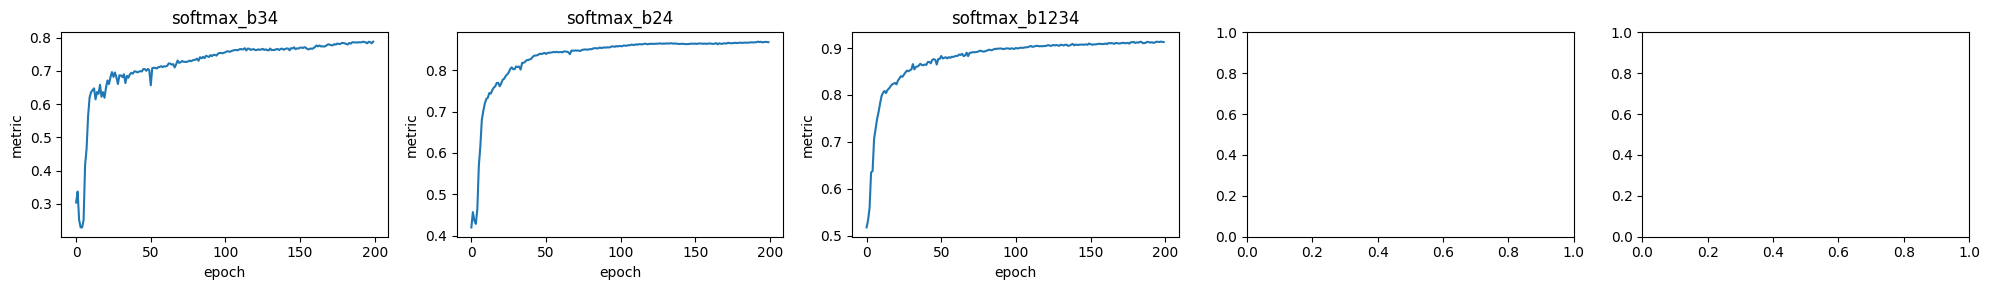

200/200 [==============================] - 987s 5s/step - b1: 0.0382 - b2: 0.0467 - b3: 0.0782 - b4: 0.0594 - softmax: 0.9417 - softmax_b1: 0.9494 - softmax_b2: 0.9362 - softmax_b3: 0.9379 - softmax_b4: 0.9347 - softmax_b23: 0.9416 - softmax_b34: 0.9390 - softmax_b24: 0.9392 - softmax_b1234: 0.9499 - best_softmax: 0.9423 - best_softmax_b1: 0.9495 - best_softmax_b2: 0.9373 - best_softmax_b3: 0.9379 - best_softmax_b4: 0.9350 - best_softmax_b23: 0.9423 - best_softmax_b34: 0.9396 - best_softmax_b24: 0.9405 - best_softmax_b1234: 0.9509


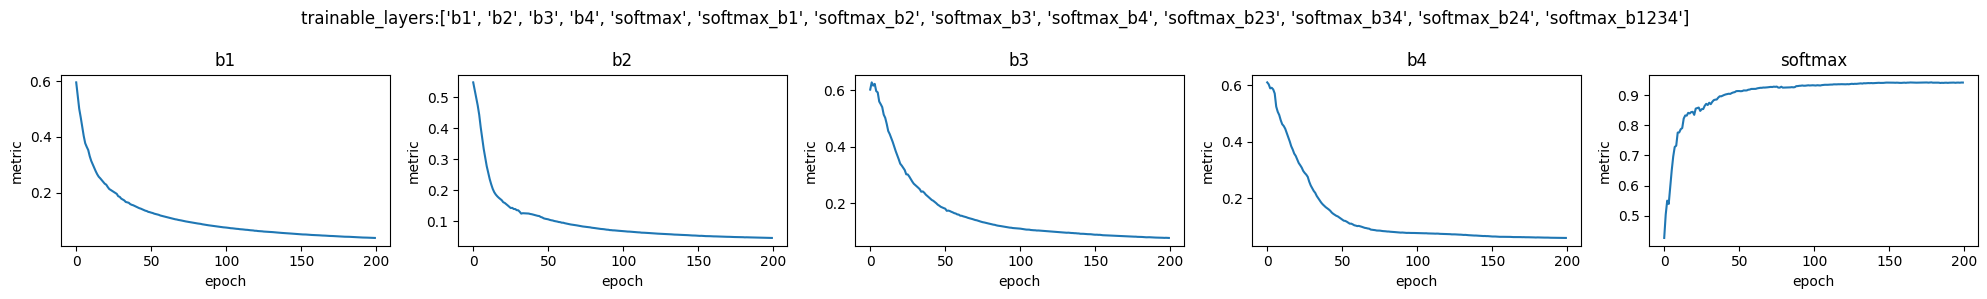

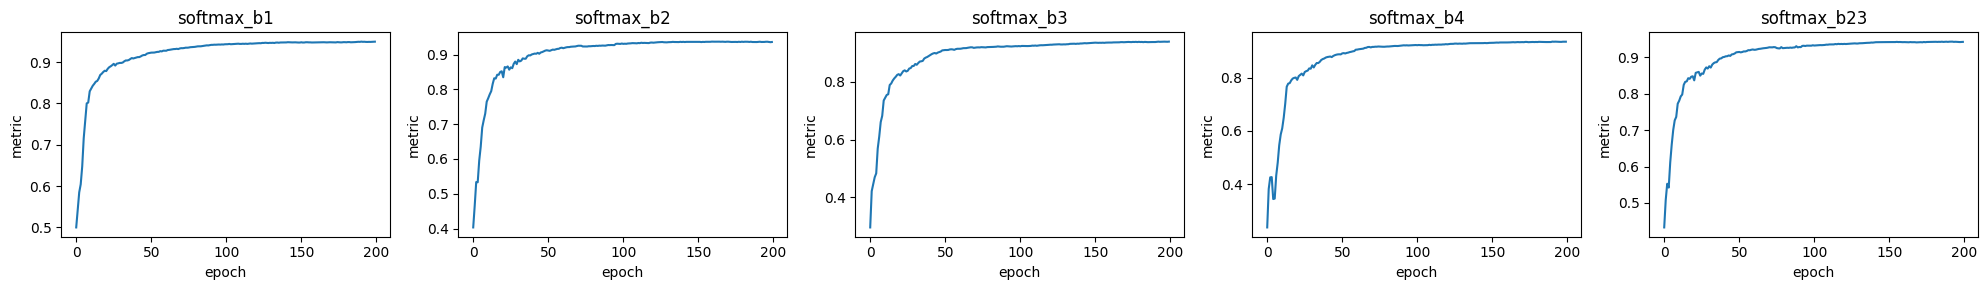

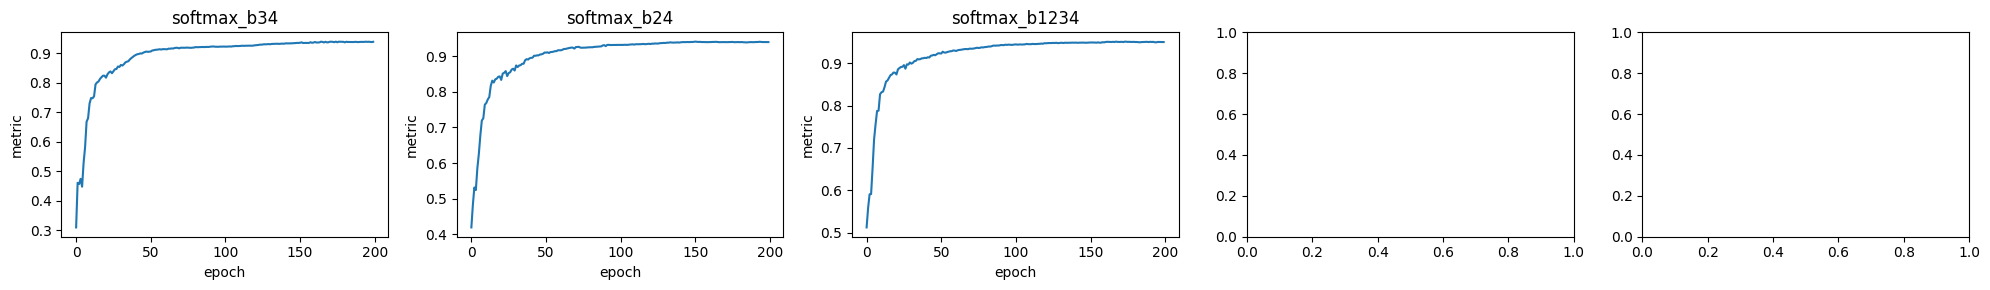

200/200 [==============================] - 977s 5s/step - b1: 0.0382 - b2: 0.0111 - b3: 0.0133 - b4: 0.0130 - softmax: 0.9217 - softmax_b1: 0.9494 - softmax_b2: 0.9187 - softmax_b3: 0.8694 - softmax_b4: 0.7517 - softmax_b23: 0.9211 - softmax_b34: 0.8720 - softmax_b24: 0.9185 - softmax_b1234: 0.9483 - best_softmax: 0.9218 - best_softmax_b1: 0.9495 - best_softmax_b2: 0.9213 - best_softmax_b3: 0.8759 - best_softmax_b4: 0.7744 - best_softmax_b23: 0.9224 - best_softmax_b34: 0.8758 - best_softmax_b24: 0.9216 - best_softmax_b1234: 0.9484


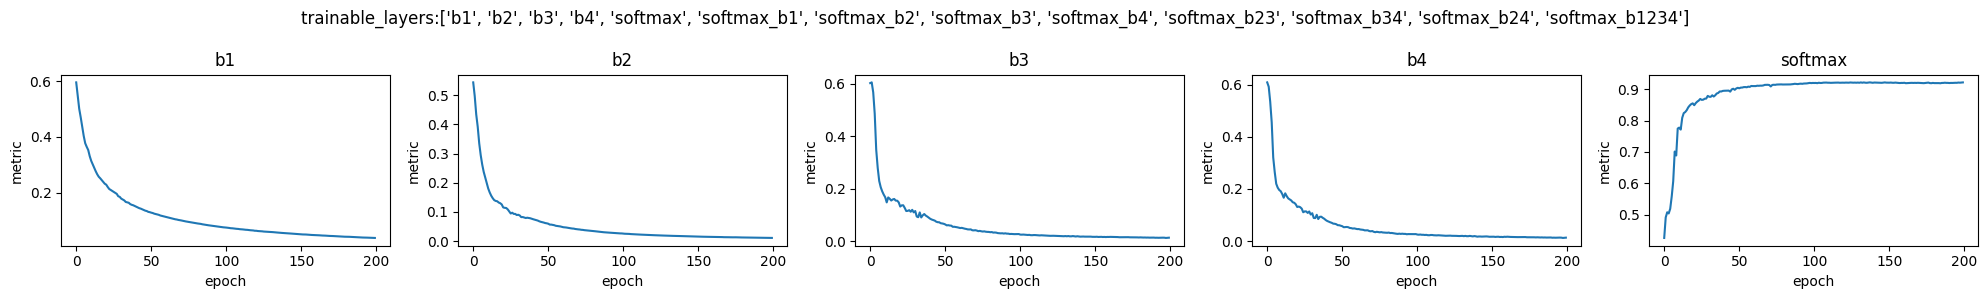

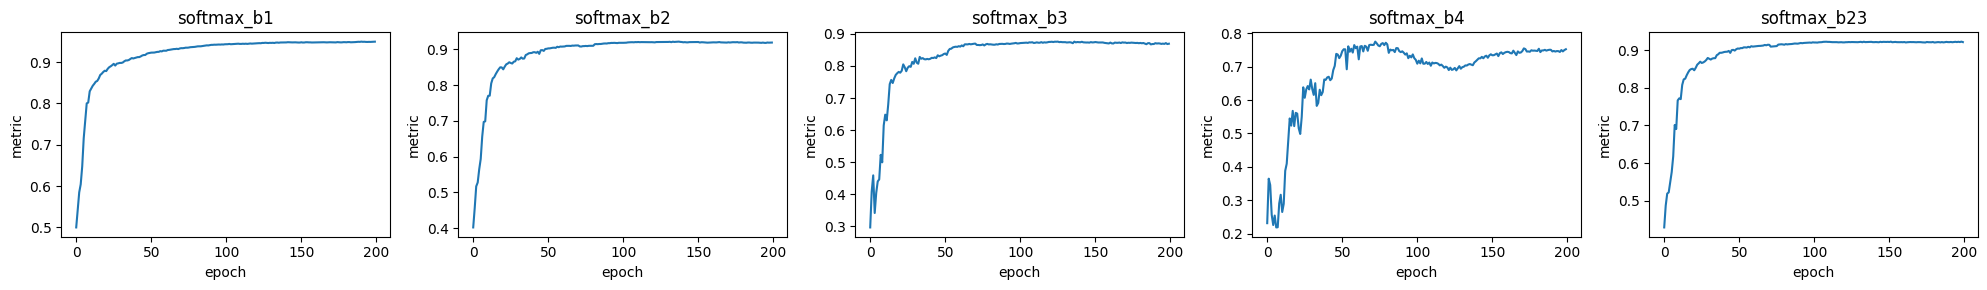

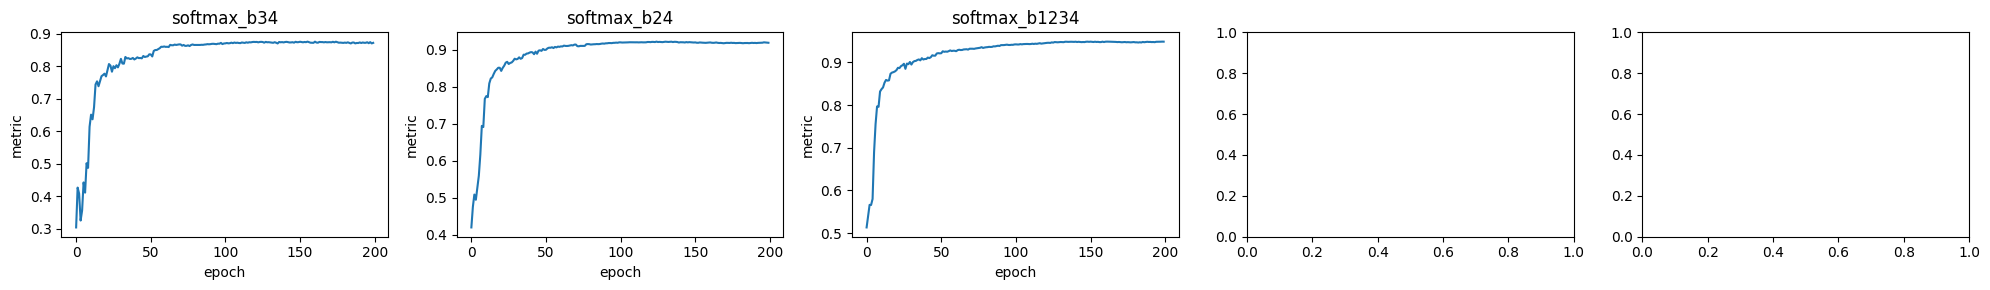

200/200 [==============================] - 976s 5s/step - b1: 0.0289 - b2: 0.0568 - b3: 0.0637 - b4: 0.0892 - softmax: 0.9341 - softmax_b1: 0.9403 - softmax_b2: 0.9333 - softmax_b3: 0.9211 - softmax_b4: 0.9225 - softmax_b23: 0.9349 - softmax_b34: 0.9259 - softmax_b24: 0.9352 - softmax_b1234: 0.9441 - best_softmax: 0.9368 - best_softmax_b1: 0.9406 - best_softmax_b2: 0.9343 - best_softmax_b3: 0.9230 - best_softmax_b4: 0.9233 - best_softmax_b23: 0.9377 - best_softmax_b34: 0.9261 - best_softmax_b24: 0.9358 - best_softmax_b1234: 0.9462


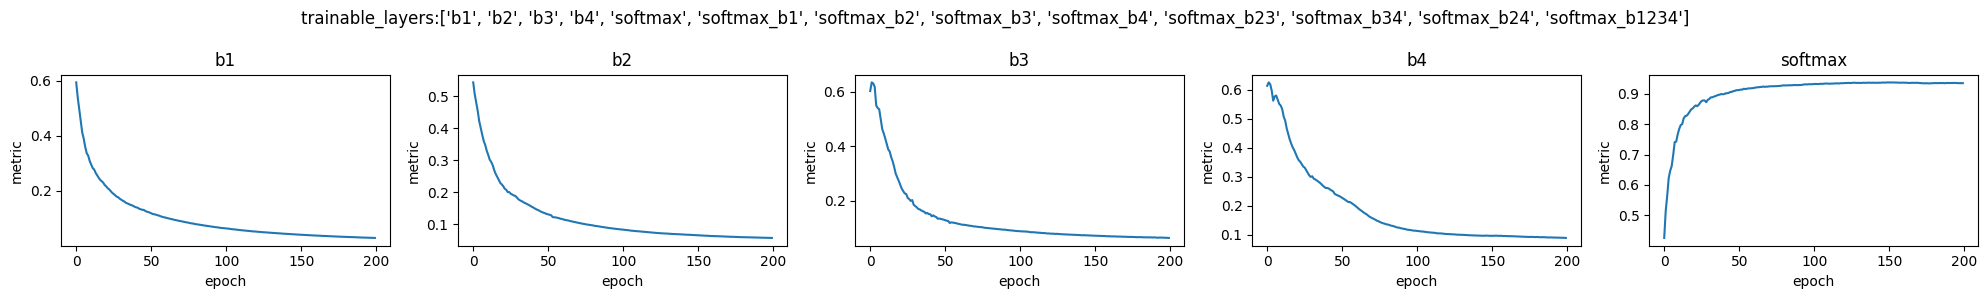

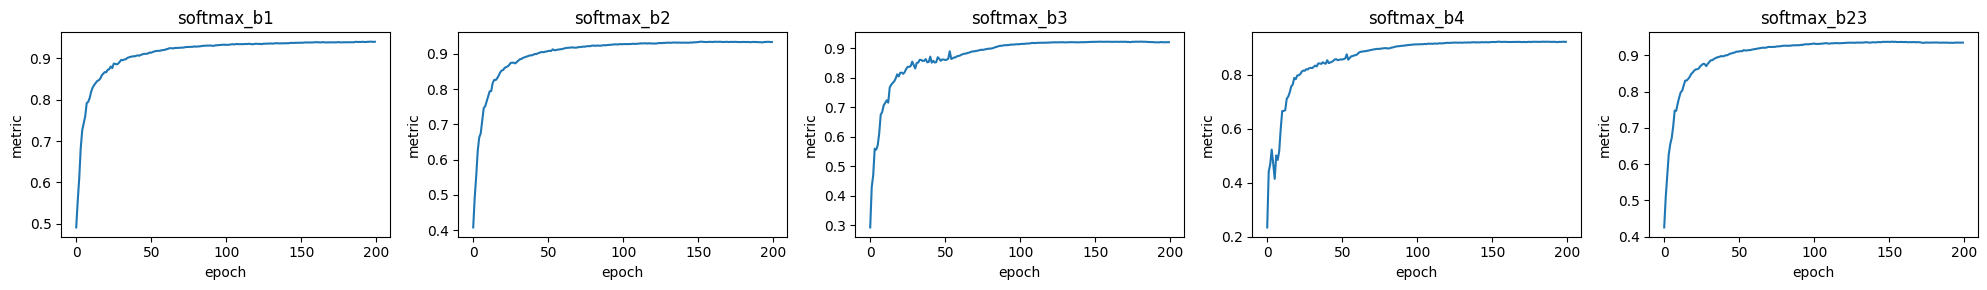

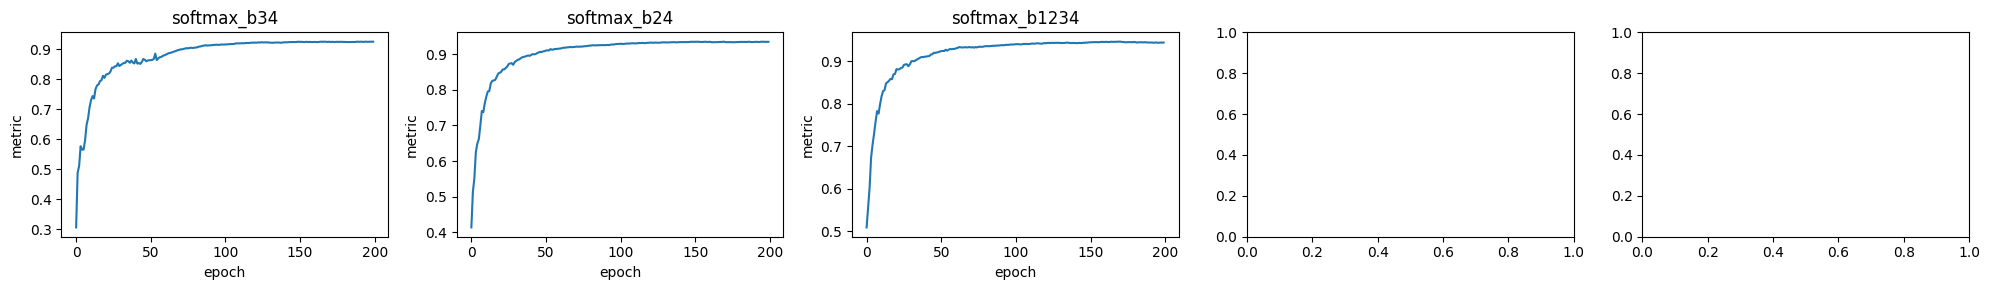

200/200 [==============================] - 980s 5s/step - b1: 0.0289 - b2: 0.0093 - b3: 0.0109 - b4: 0.0103 - softmax: 0.9090 - softmax_b1: 0.9403 - softmax_b2: 0.9048 - softmax_b3: 0.8483 - softmax_b4: 0.7088 - softmax_b23: 0.9087 - softmax_b34: 0.8488 - softmax_b24: 0.9059 - softmax_b1234: 0.9394 - best_softmax: 0.9090 - best_softmax_b1: 0.9406 - best_softmax_b2: 0.9054 - best_softmax_b3: 0.8586 - best_softmax_b4: 0.7477 - best_softmax_b23: 0.9090 - best_softmax_b34: 0.8618 - best_softmax_b24: 0.9064 - best_softmax_b1234: 0.9403


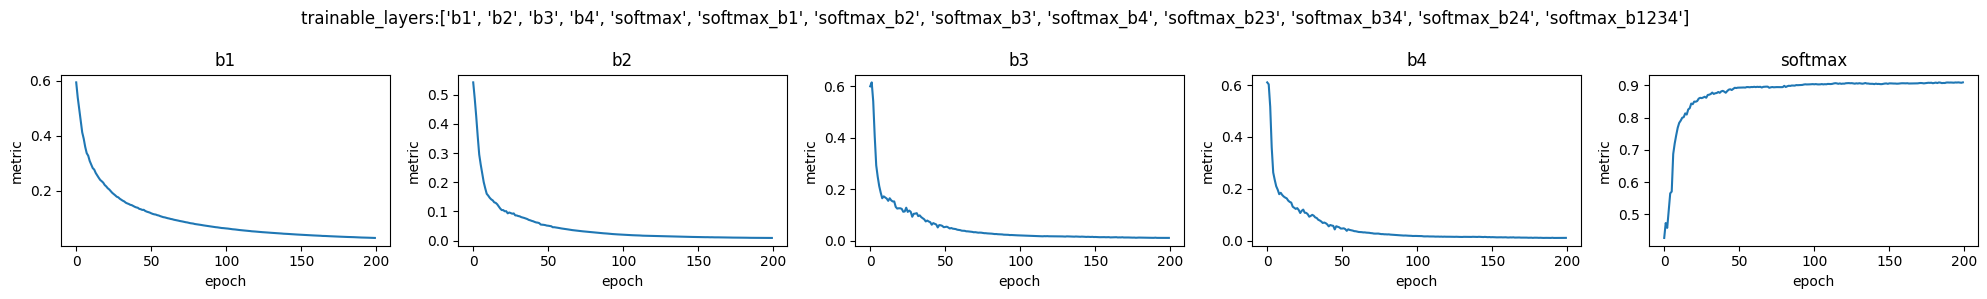

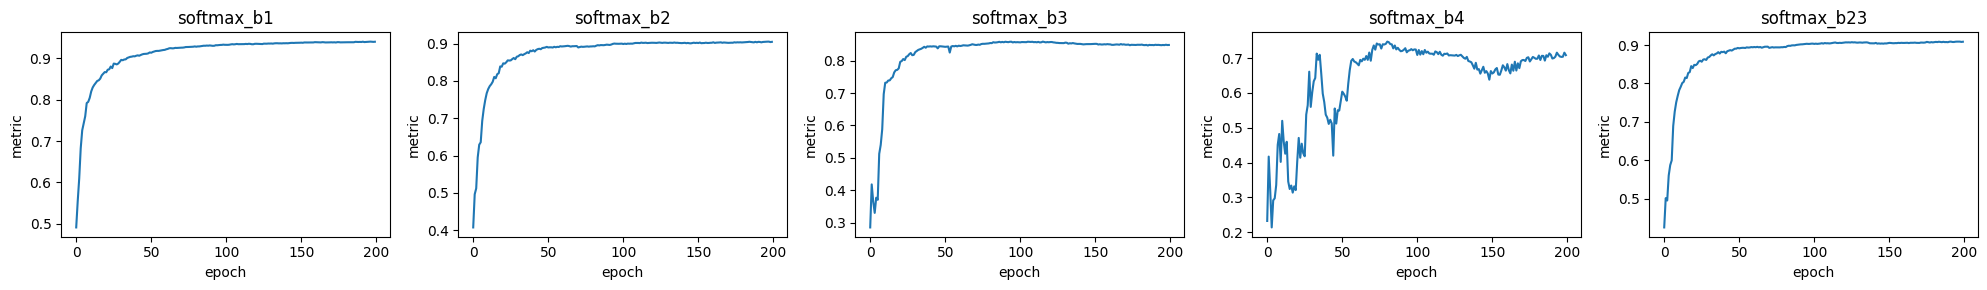

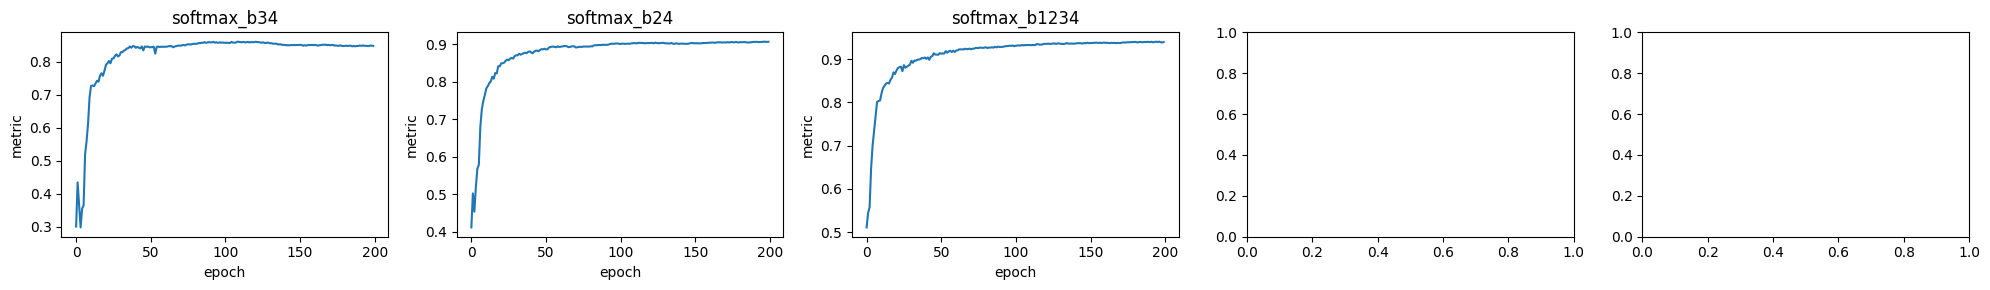

200/200 [==============================] - 975s 5s/step - b1: 0.0166 - b2: 0.0841 - b3: 0.0096 - b4: 0.1391 - softmax: 0.8933 - softmax_b1: 0.9005 - softmax_b2: 0.8826 - softmax_b3: 0.8536 - softmax_b4: 0.8404 - softmax_b23: 0.8929 - softmax_b34: 0.8683 - softmax_b24: 0.8917 - softmax_b1234: 0.9153 - best_softmax: 0.8941 - best_softmax_b1: 0.9012 - best_softmax_b2: 0.8826 - best_softmax_b3: 0.8537 - best_softmax_b4: 0.8422 - best_softmax_b23: 0.8940 - best_softmax_b34: 0.8683 - best_softmax_b24: 0.8919 - best_softmax_b1234: 0.9156


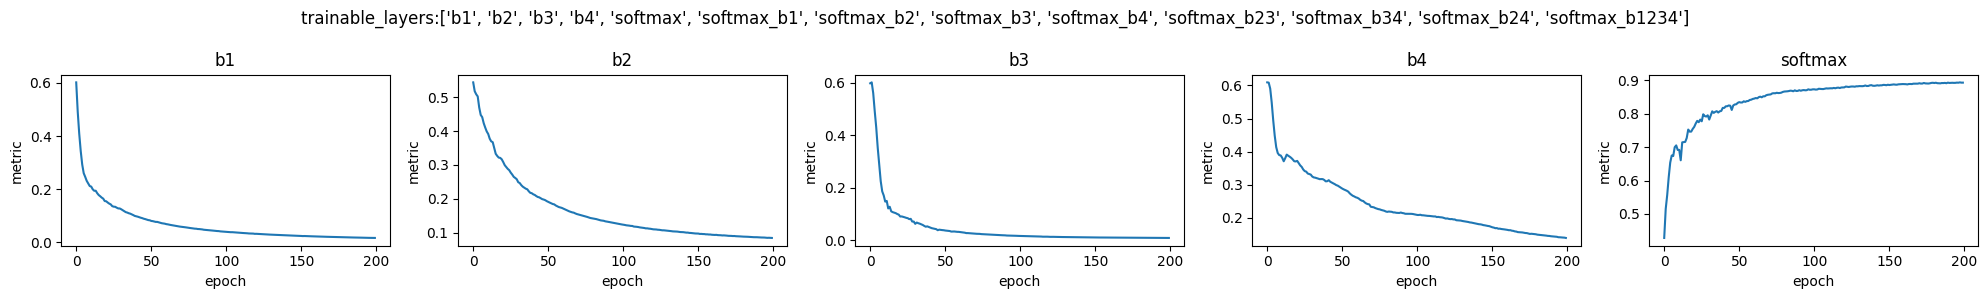

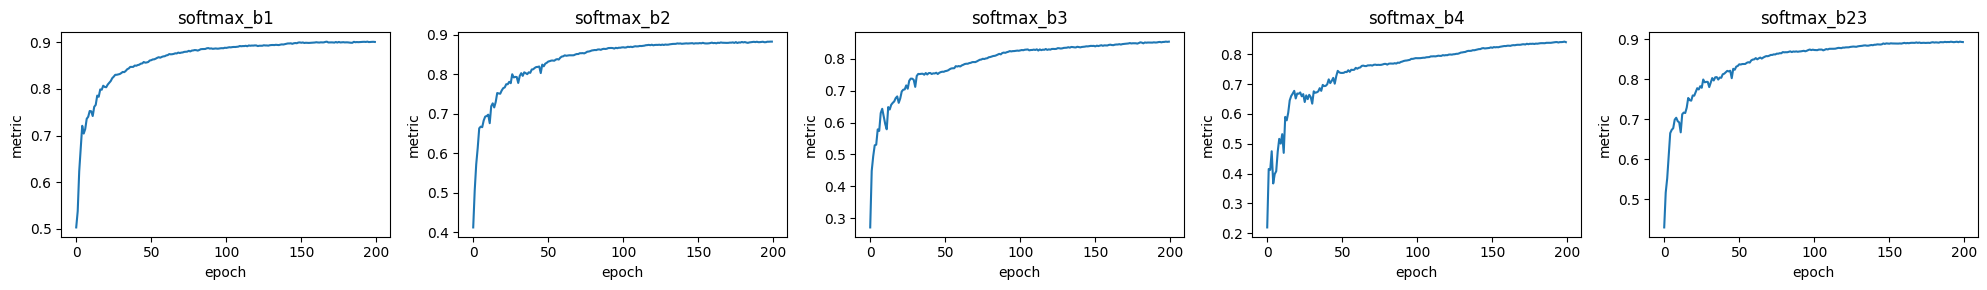

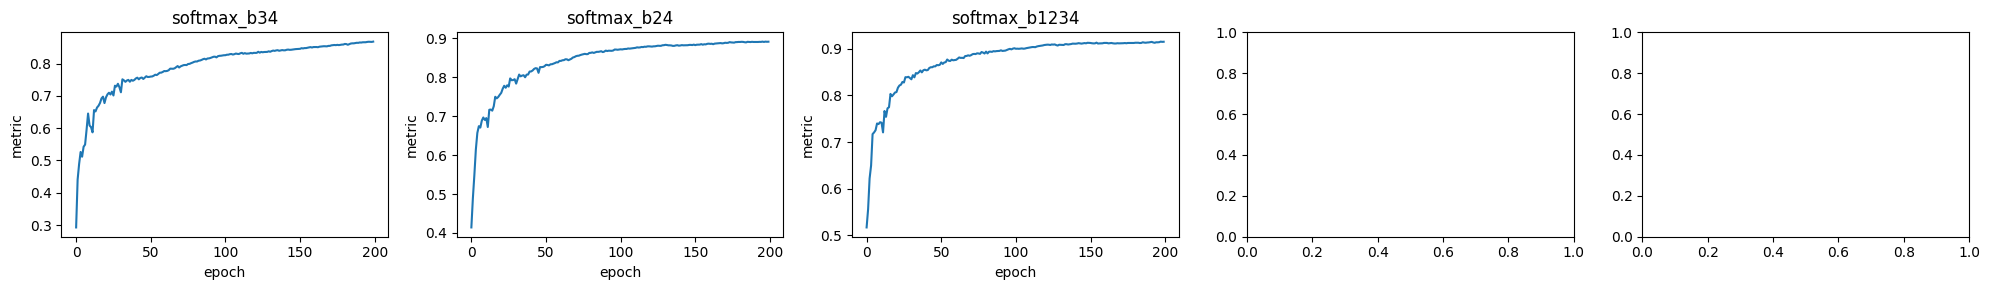

200/200 [==============================] - 983s 5s/step - b1: 0.0166 - b2: 0.0062 - b3: 0.0075 - b4: 0.0063 - softmax: 0.8439 - softmax_b1: 0.9005 - softmax_b2: 0.8398 - softmax_b3: 0.7332 - softmax_b4: 0.6383 - softmax_b23: 0.8427 - softmax_b34: 0.7411 - softmax_b24: 0.8413 - softmax_b1234: 0.9005 - best_softmax: 0.8439 - best_softmax_b1: 0.9012 - best_softmax_b2: 0.8409 - best_softmax_b3: 0.7393 - best_softmax_b4: 0.6489 - best_softmax_b23: 0.8436 - best_softmax_b34: 0.7416 - best_softmax_b24: 0.8427 - best_softmax_b1234: 0.9012


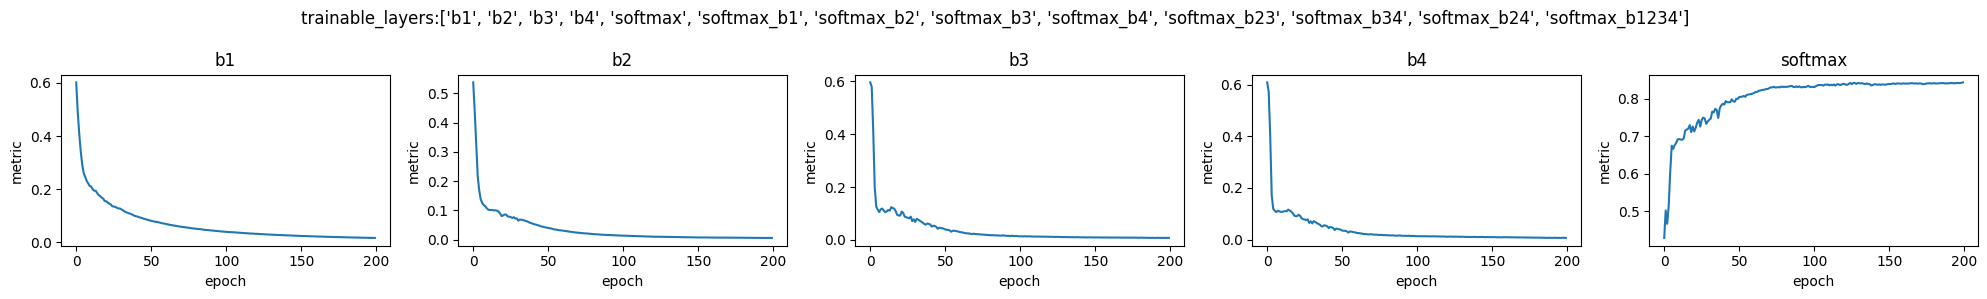

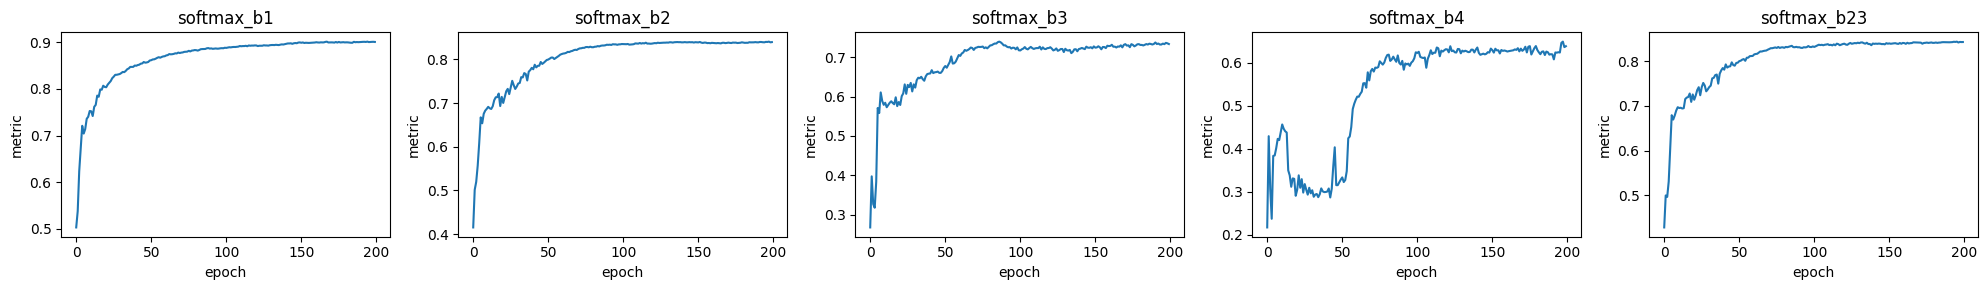

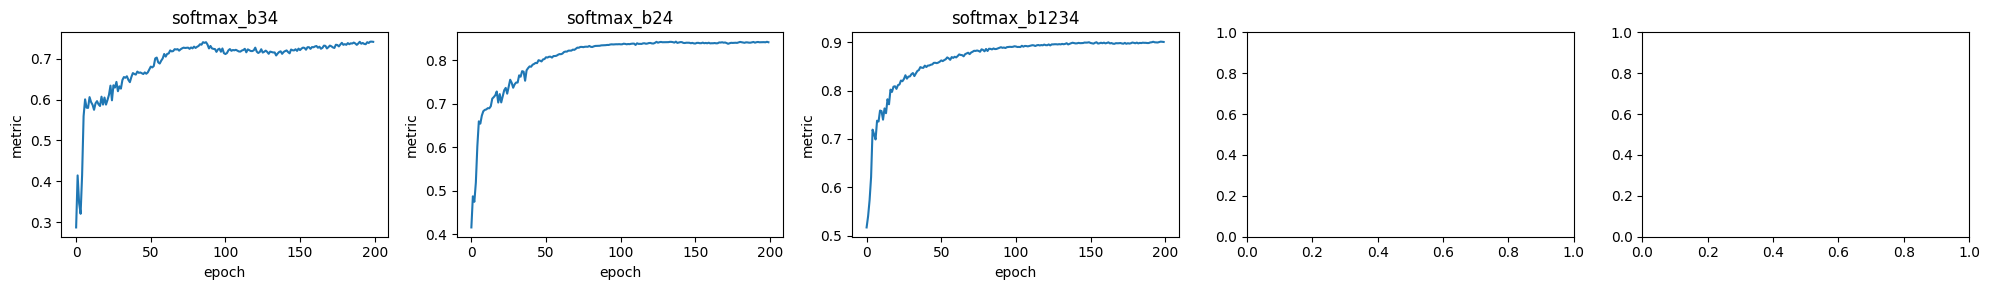

200/200 [==============================] - 979s 5s/step - b1: 0.0231 - b2: 0.0374 - b3: 0.1824 - b4: 0.1709 - softmax: 0.8928 - softmax_b1: 0.9169 - softmax_b2: 0.8874 - softmax_b3: 0.8605 - softmax_b4: 0.8609 - softmax_b23: 0.8952 - softmax_b34: 0.8703 - softmax_b24: 0.8919 - softmax_b1234: 0.9254 - best_softmax: 0.8931 - best_softmax_b1: 0.9187 - best_softmax_b2: 0.8889 - best_softmax_b3: 0.8619 - best_softmax_b4: 0.8620 - best_softmax_b23: 0.8952 - best_softmax_b34: 0.8708 - best_softmax_b24: 0.8928 - best_softmax_b1234: 0.9259


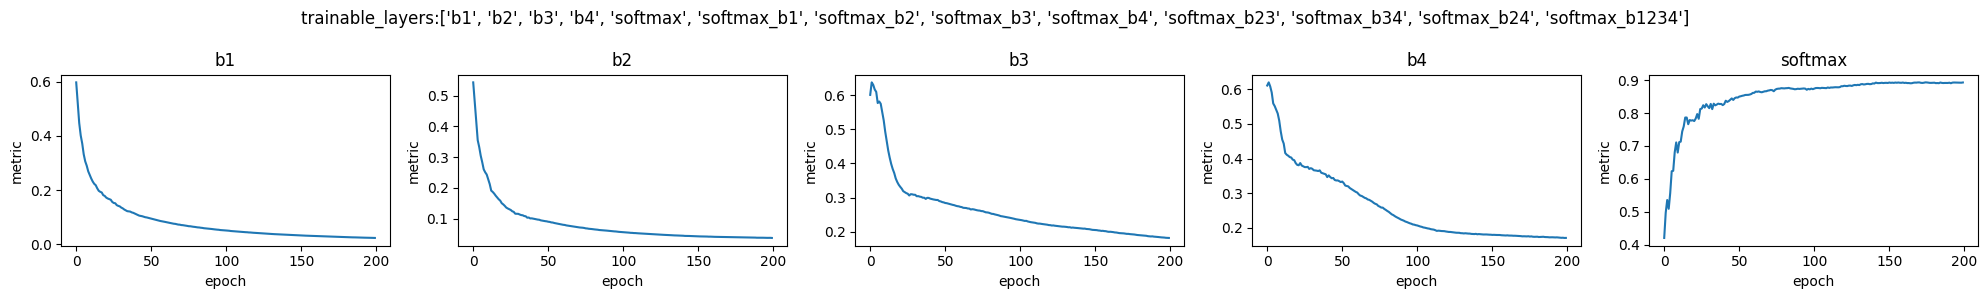

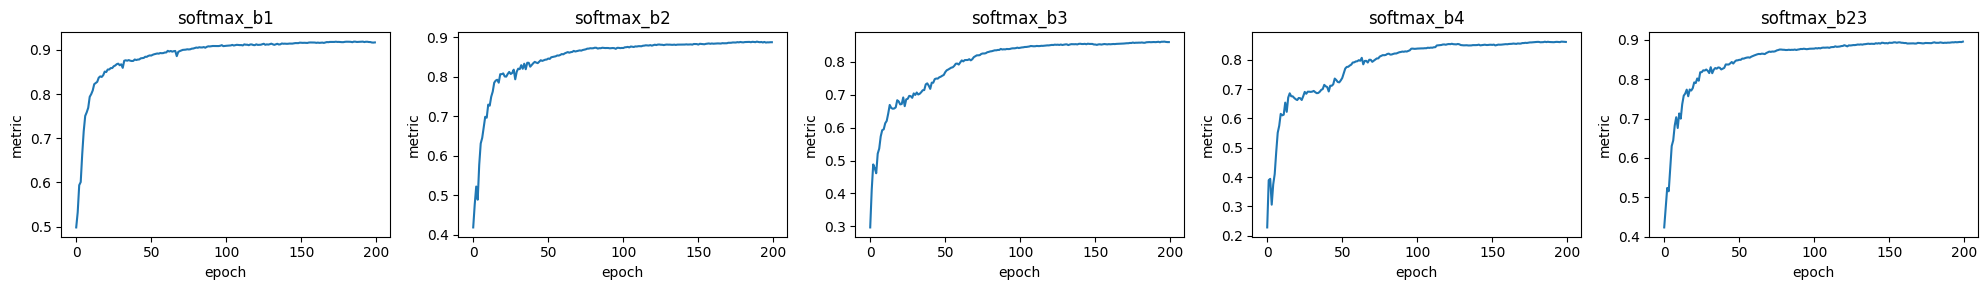

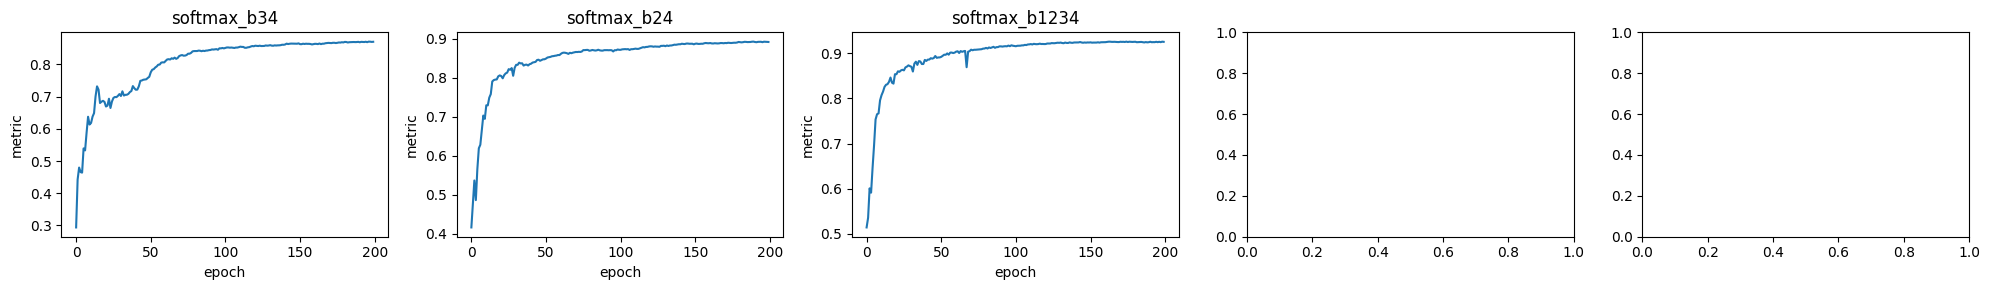

200/200 [==============================] - 975s 5s/step - b1: 0.0231 - b2: 0.0069 - b3: 0.0078 - b4: 0.0068 - softmax: 0.8767 - softmax_b1: 0.9169 - softmax_b2: 0.8717 - softmax_b3: 0.7760 - softmax_b4: 0.5788 - softmax_b23: 0.8767 - softmax_b34: 0.7751 - softmax_b24: 0.8732 - softmax_b1234: 0.9189 - best_softmax: 0.8767 - best_softmax_b1: 0.9187 - best_softmax_b2: 0.8718 - best_softmax_b3: 0.7786 - best_softmax_b4: 0.6314 - best_softmax_b23: 0.8767 - best_softmax_b34: 0.7800 - best_softmax_b24: 0.8732 - best_softmax_b1234: 0.9192


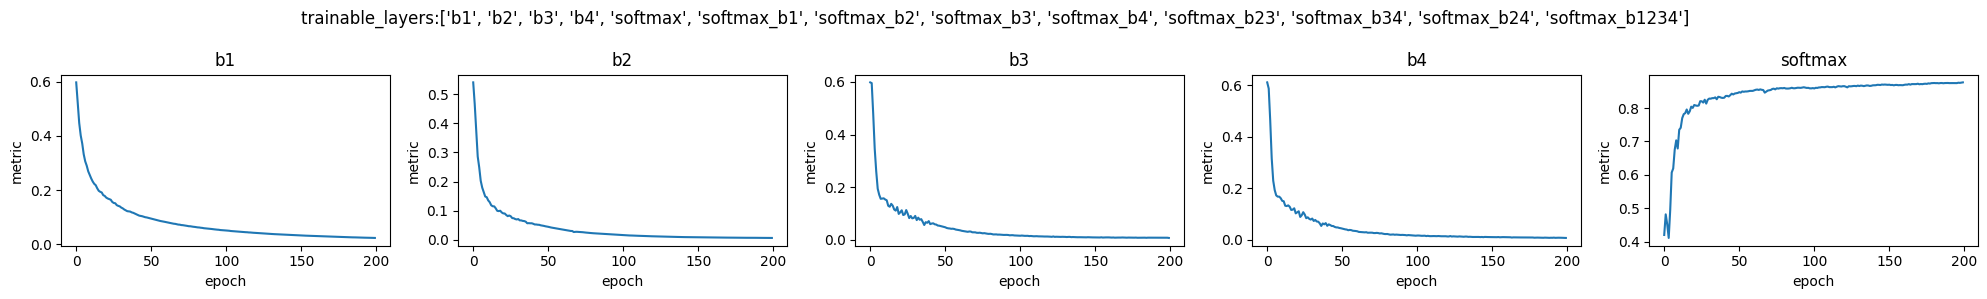

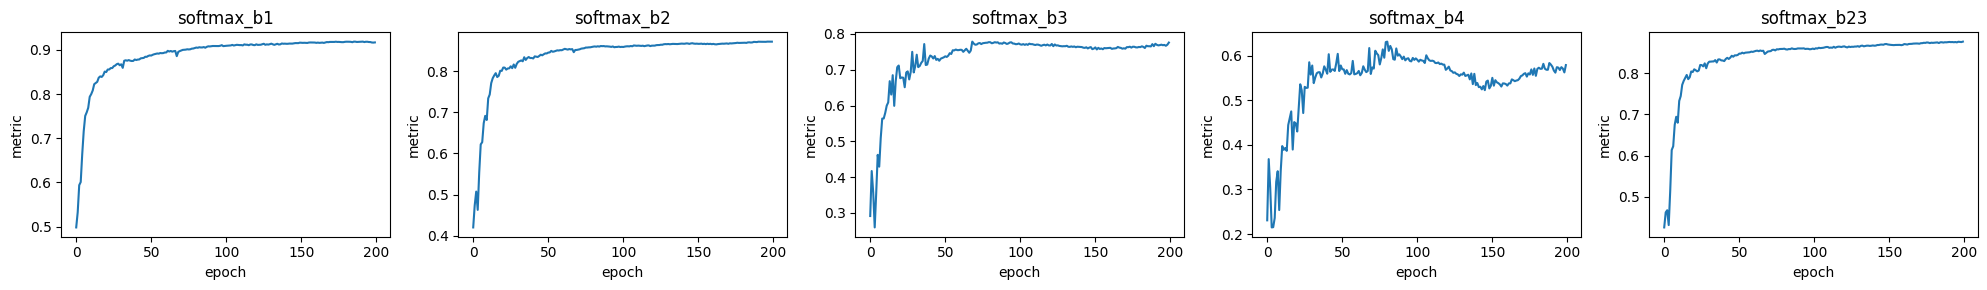

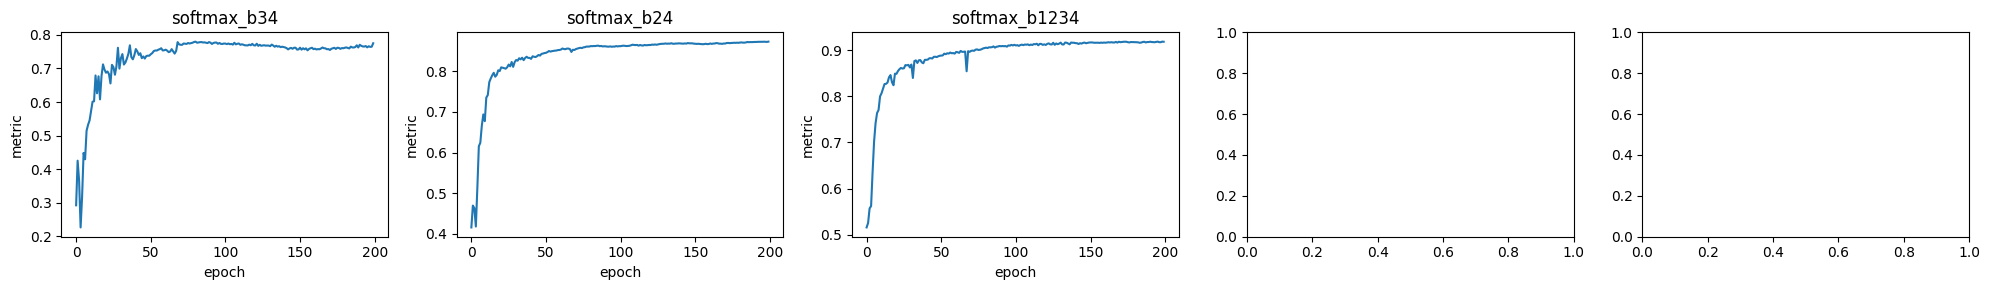

200/200 [==============================] - 978s 5s/step - b1: 0.0378 - b2: 0.0417 - b3: 0.0839 - b4: 0.0820 - softmax: 0.9369 - softmax_b1: 0.9456 - softmax_b2: 0.9317 - softmax_b3: 0.9304 - softmax_b4: 0.9267 - softmax_b23: 0.9373 - softmax_b34: 0.9330 - softmax_b24: 0.9355 - softmax_b1234: 0.9506 - best_softmax: 0.9379 - best_softmax_b1: 0.9468 - best_softmax_b2: 0.9332 - best_softmax_b3: 0.9318 - best_softmax_b4: 0.9295 - best_softmax_b23: 0.9376 - best_softmax_b34: 0.9330 - best_softmax_b24: 0.9364 - best_softmax_b1234: 0.9514


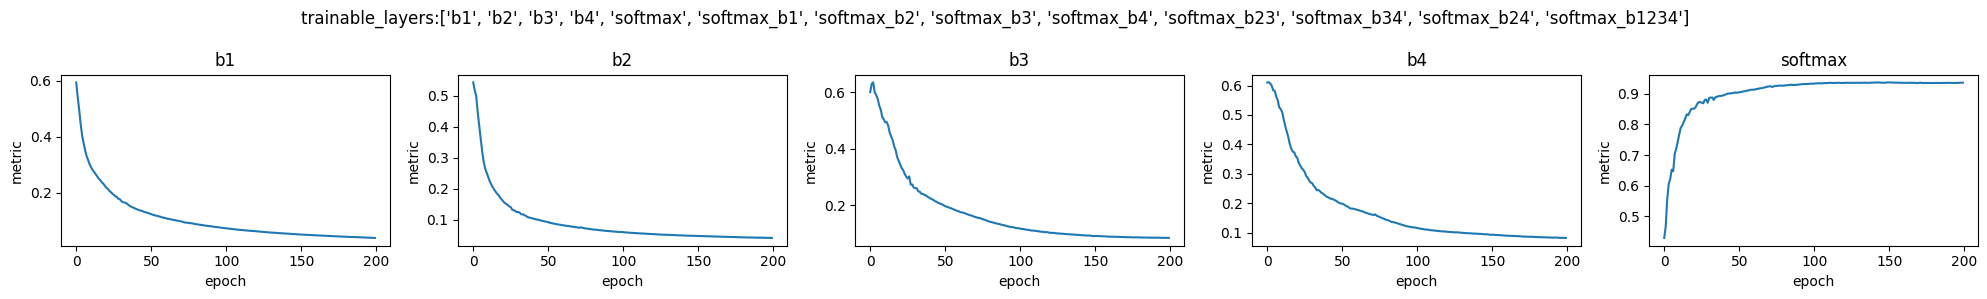

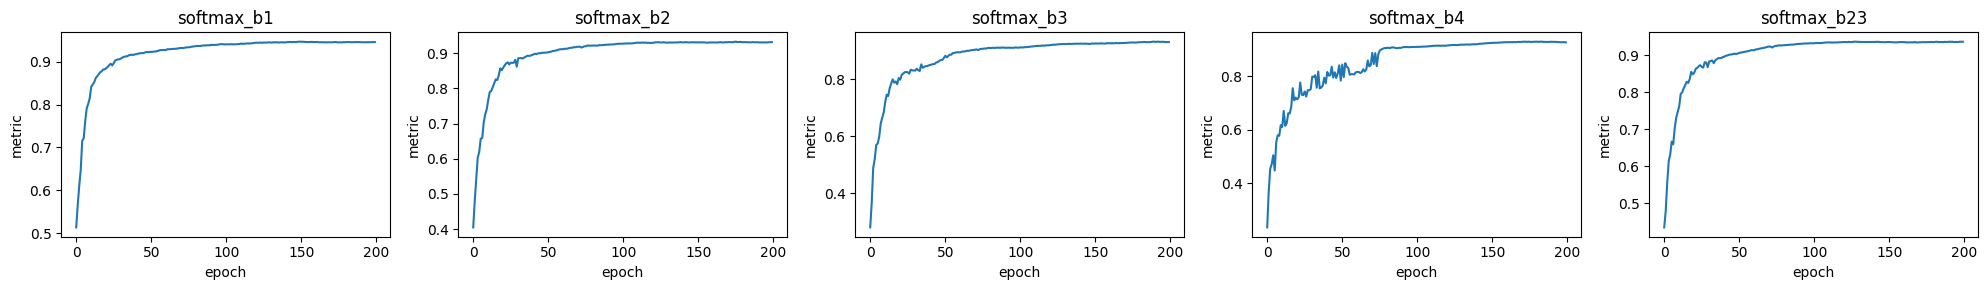

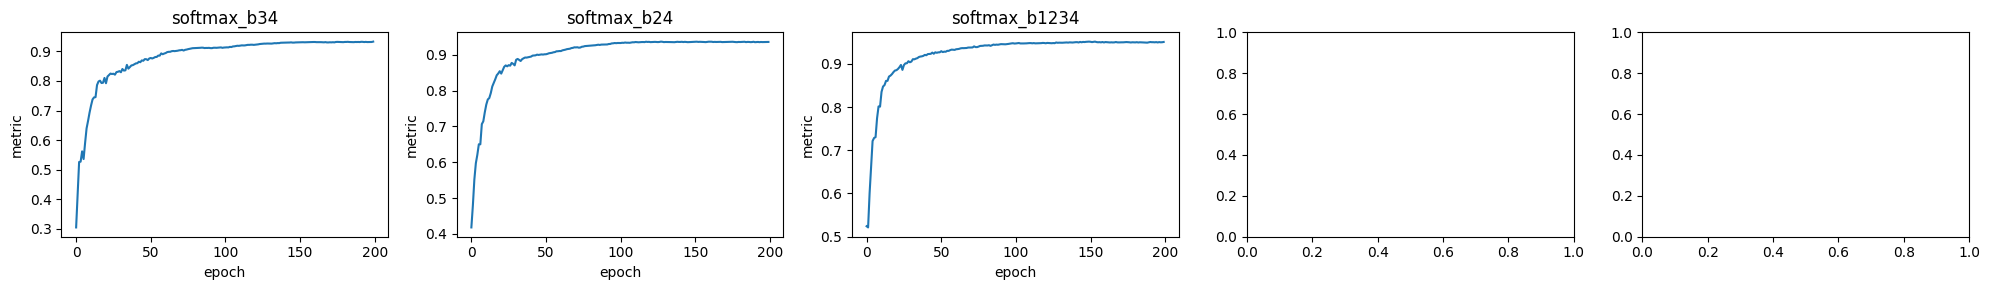

200/200 [==============================] - 978s 5s/step - b1: 0.0378 - b2: 0.0103 - b3: 0.0121 - b4: 0.0110 - softmax: 0.9222 - softmax_b1: 0.9456 - softmax_b2: 0.9182 - softmax_b3: 0.8470 - softmax_b4: 0.6651 - softmax_b23: 0.9209 - softmax_b34: 0.8477 - softmax_b24: 0.9197 - softmax_b1234: 0.9468 - best_softmax: 0.9223 - best_softmax_b1: 0.9468 - best_softmax_b2: 0.9187 - best_softmax_b3: 0.8672 - best_softmax_b4: 0.7371 - best_softmax_b23: 0.9223 - best_softmax_b34: 0.8643 - best_softmax_b24: 0.9197 - best_softmax_b1234: 0.9473


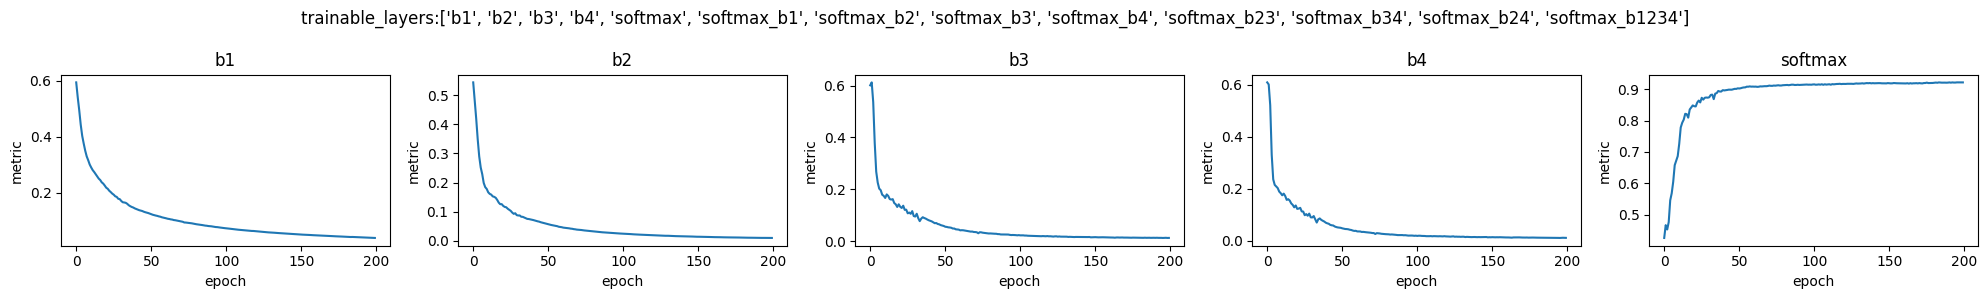

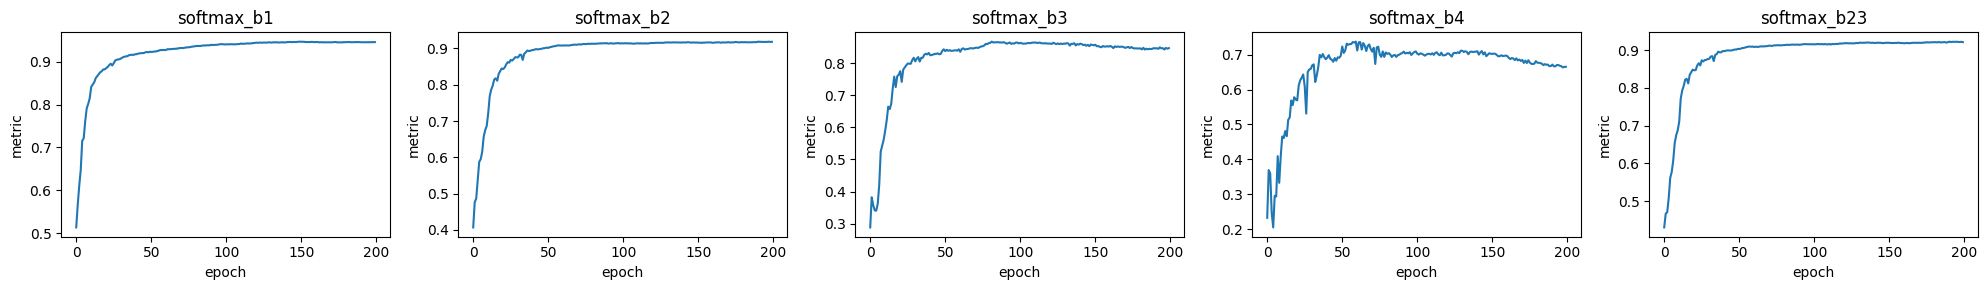

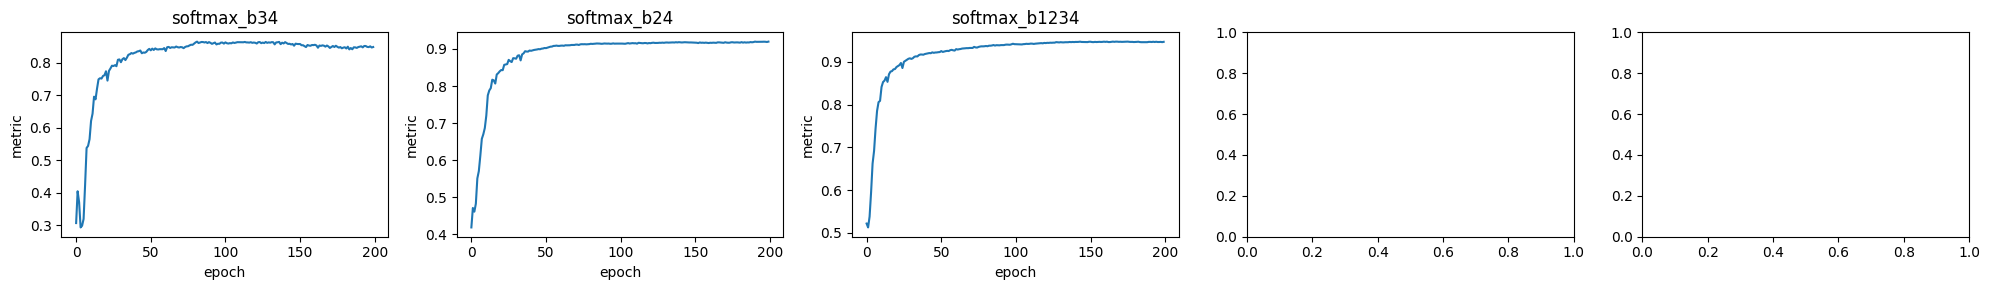

200/200 [==============================] - 976s 5s/step - b1: 0.0454 - b2: 0.0529 - b3: 0.0455 - b4: 0.0900 - softmax: 0.9421 - softmax_b1: 0.9459 - softmax_b2: 0.9411 - softmax_b3: 0.9313 - softmax_b4: 0.9289 - softmax_b23: 0.9421 - softmax_b34: 0.9338 - softmax_b24: 0.9406 - softmax_b1234: 0.9474 - best_softmax: 0.9421 - best_softmax_b1: 0.9465 - best_softmax_b2: 0.9411 - best_softmax_b3: 0.9317 - best_softmax_b4: 0.9291 - best_softmax_b23: 0.9422 - best_softmax_b34: 0.9342 - best_softmax_b24: 0.9409 - best_softmax_b1234: 0.9484


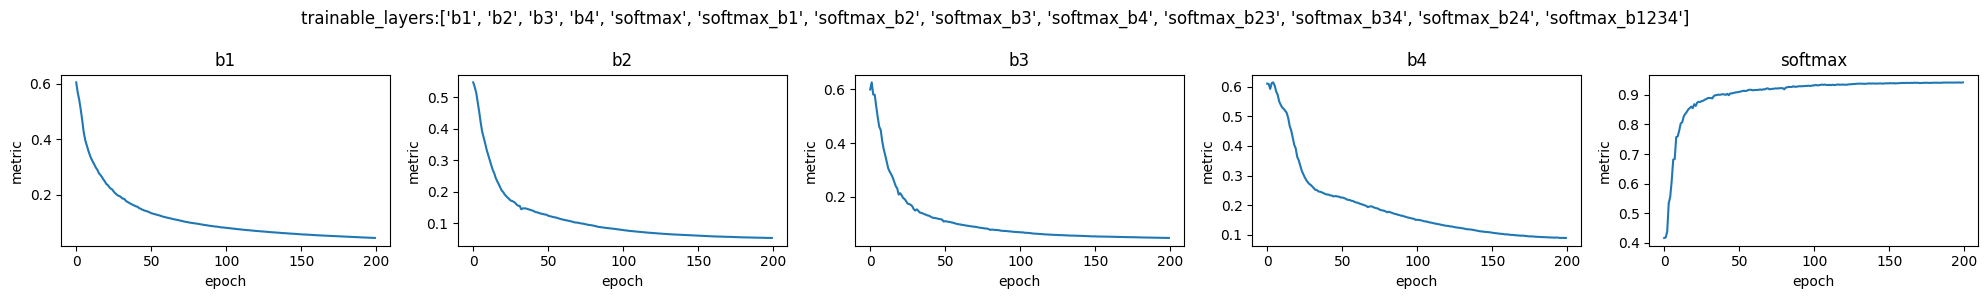

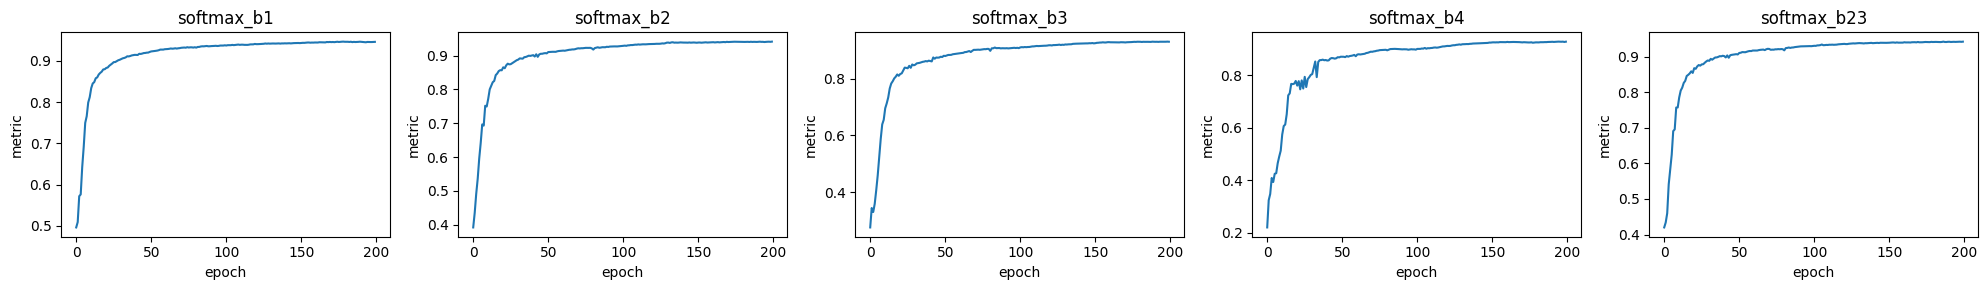

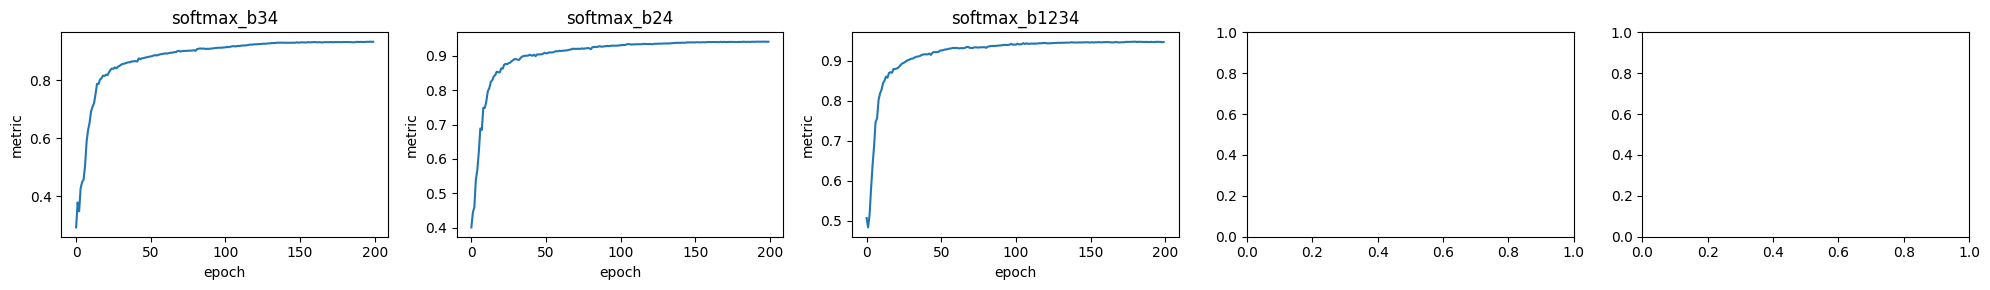

200/200 [==============================] - 980s 5s/step - b1: 0.0454 - b2: 0.0113 - b3: 0.0140 - b4: 0.0124 - softmax: 0.9137 - softmax_b1: 0.9459 - softmax_b2: 0.9121 - softmax_b3: 0.8346 - softmax_b4: 0.7226 - softmax_b23: 0.9130 - softmax_b34: 0.8372 - softmax_b24: 0.9121 - softmax_b1234: 0.9458 - best_softmax: 0.9160 - best_softmax_b1: 0.9465 - best_softmax_b2: 0.9149 - best_softmax_b3: 0.8613 - best_softmax_b4: 0.7731 - best_softmax_b23: 0.9160 - best_softmax_b34: 0.8603 - best_softmax_b24: 0.9149 - best_softmax_b1234: 0.9465


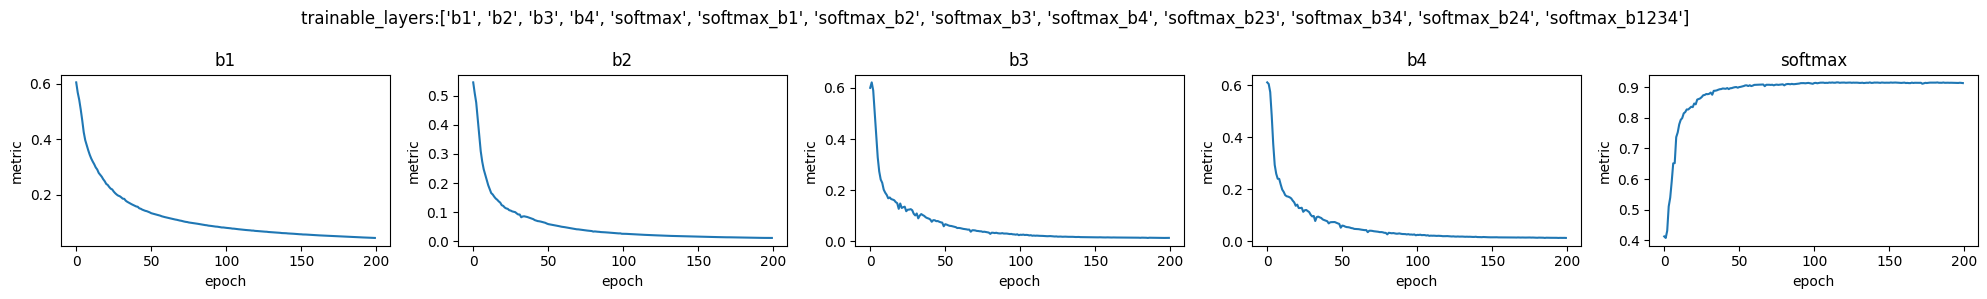

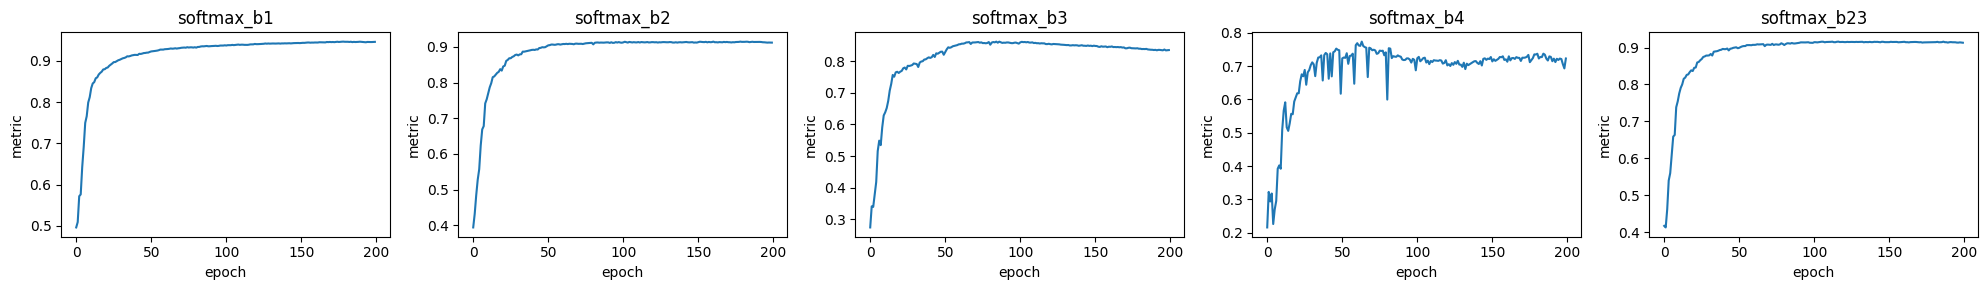

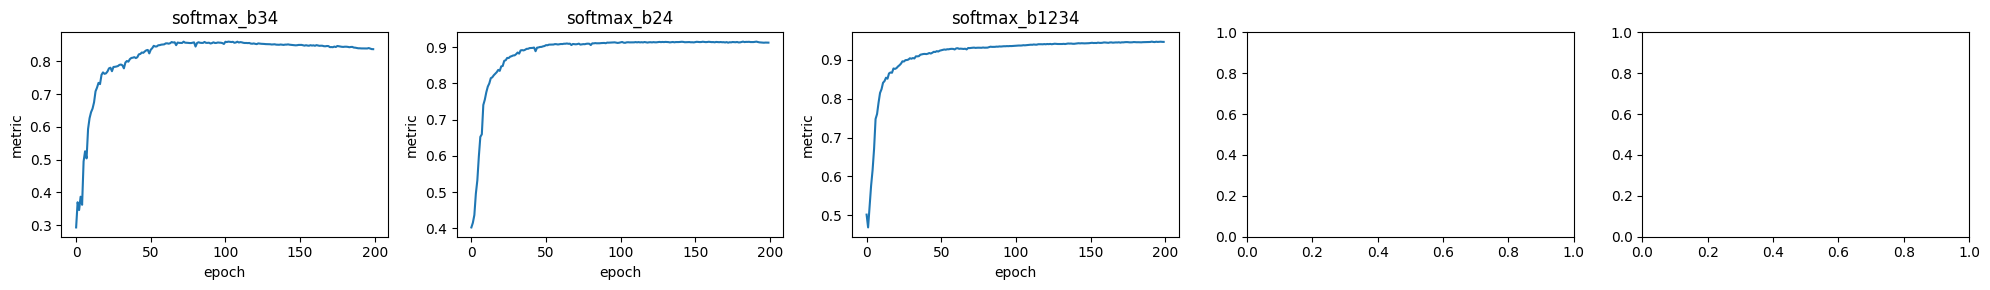

200/200 [==============================] - 1192s 6s/step - b1: 0.0200 - b2: 0.0682 - b3: 0.0768 - b4: 0.0898 - softmax: 0.9283 - softmax_b1: 0.9306 - softmax_b2: 0.9193 - softmax_b3: 0.9195 - softmax_b4: 0.9164 - softmax_b23: 0.9260 - softmax_b34: 0.9205 - softmax_b24: 0.9241 - softmax_b1234: 0.9401 - best_softmax: 0.9283 - best_softmax_b1: 0.9306 - best_softmax_b2: 0.9194 - best_softmax_b3: 0.9195 - best_softmax_b4: 0.9164 - best_softmax_b23: 0.9266 - best_softmax_b34: 0.9210 - best_softmax_b24: 0.9241 - best_softmax_b1234: 0.9403


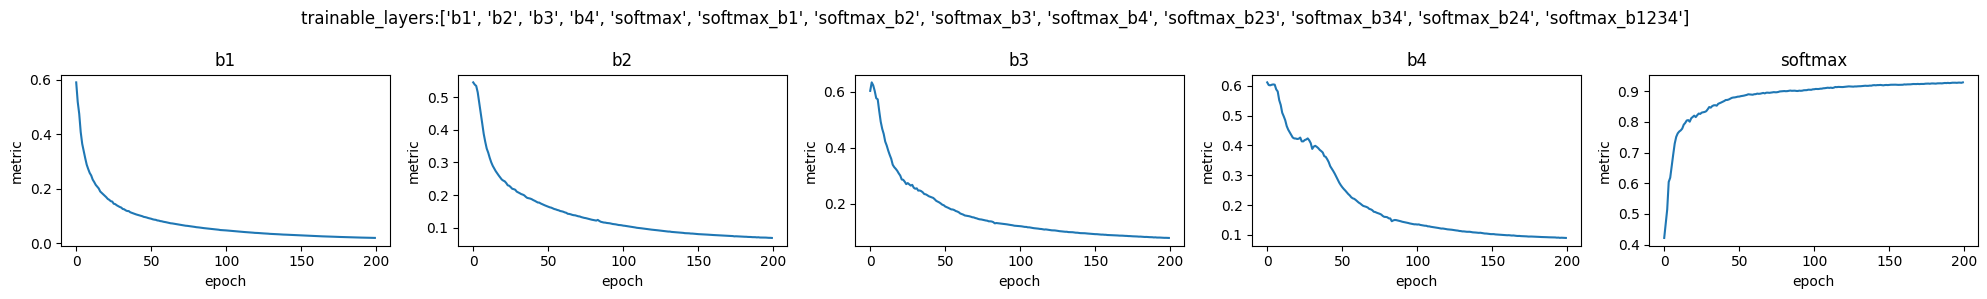

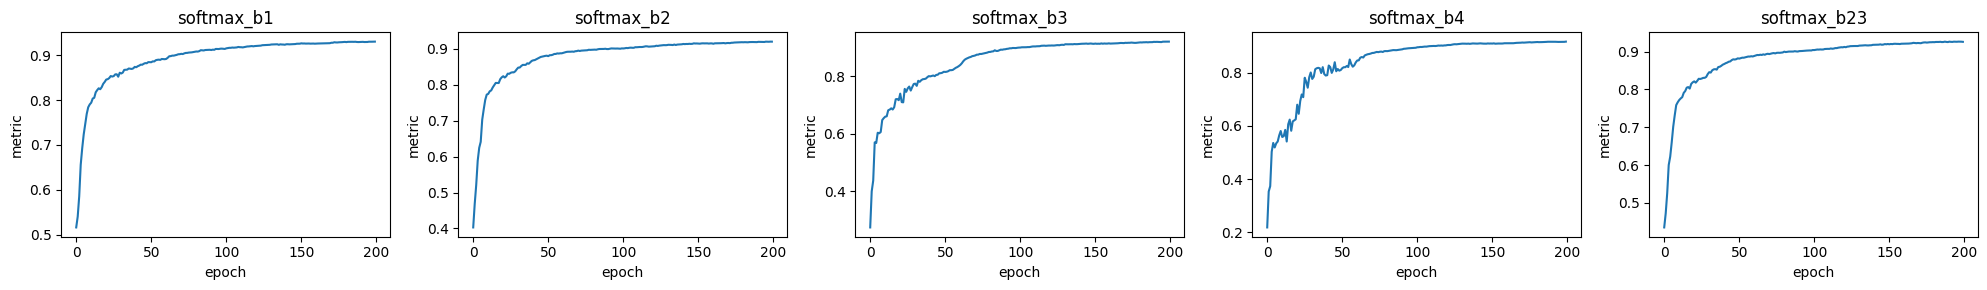

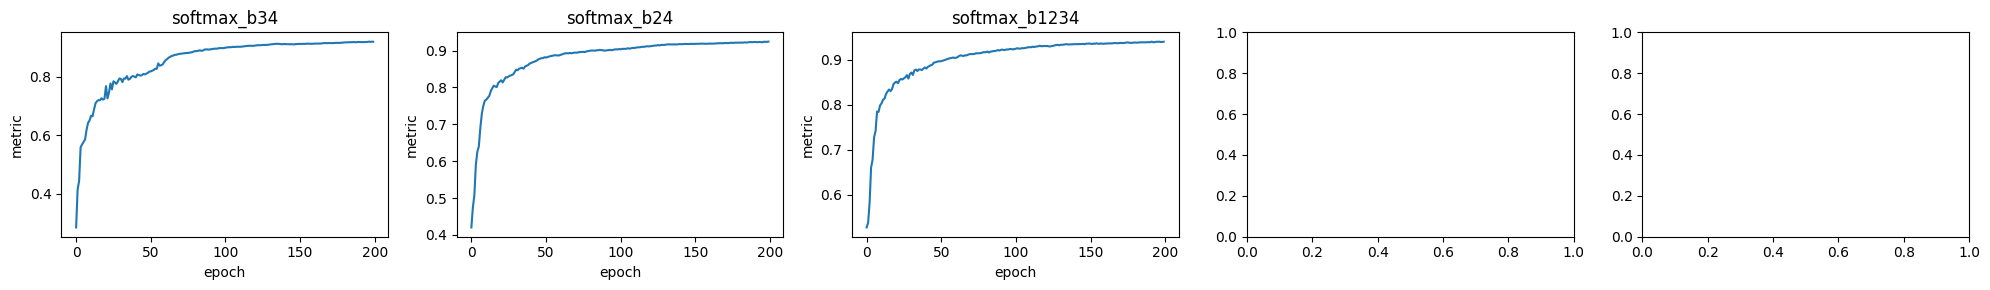

200/200 [==============================] - 1542s 8s/step - b1: 0.0200 - b2: 0.0060 - b3: 0.0070 - b4: 0.0064 - softmax: 0.8869 - softmax_b1: 0.9306 - softmax_b2: 0.8827 - softmax_b3: 0.7901 - softmax_b4: 0.5548 - softmax_b23: 0.8860 - softmax_b34: 0.7904 - softmax_b24: 0.8844 - softmax_b1234: 0.9325 - best_softmax: 0.8871 - best_softmax_b1: 0.9306 - best_softmax_b2: 0.8834 - best_softmax_b3: 0.7937 - best_softmax_b4: 0.5832 - best_softmax_b23: 0.8860 - best_softmax_b34: 0.7929 - best_softmax_b24: 0.8846 - best_softmax_b1234: 0.9325


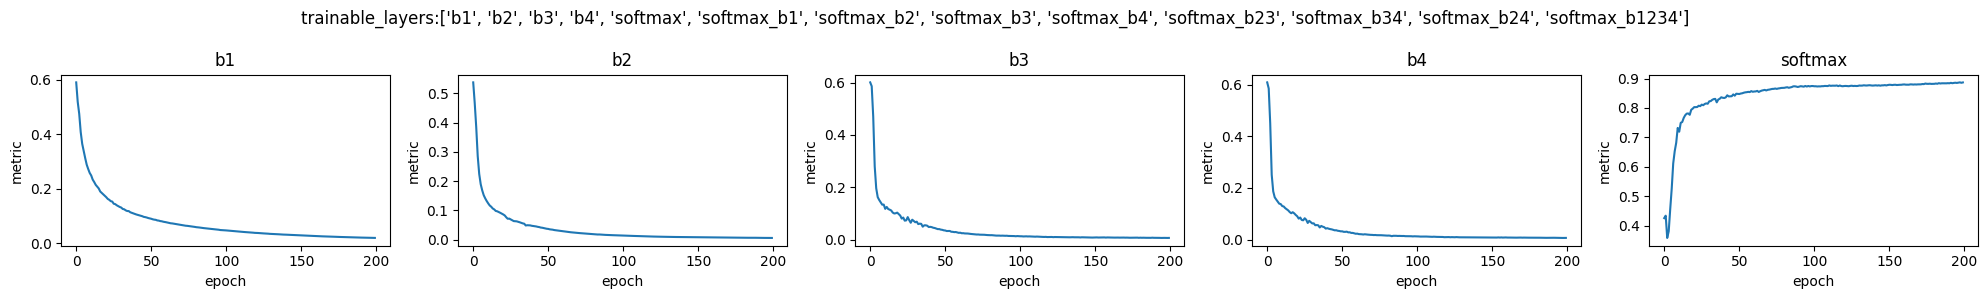

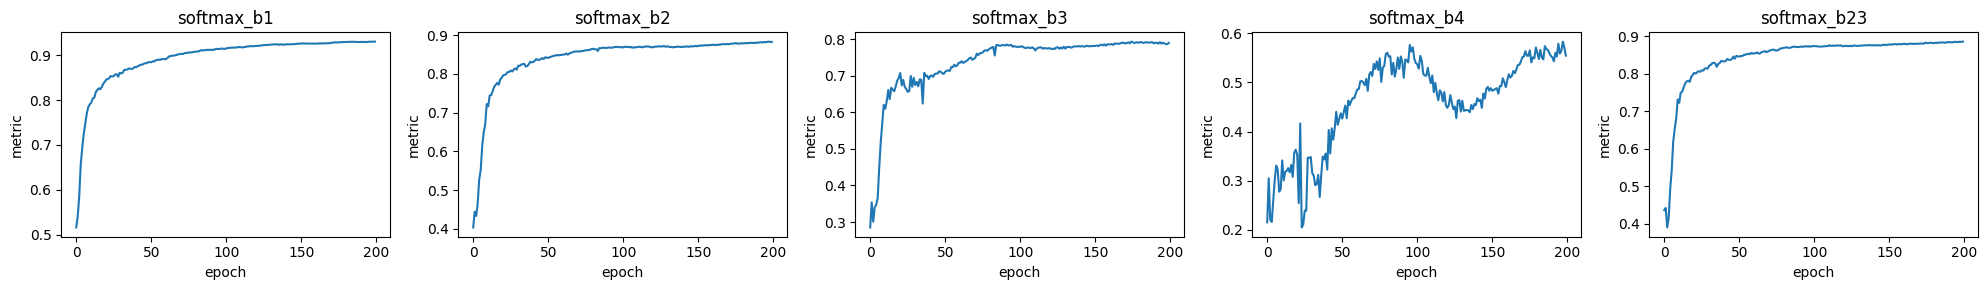

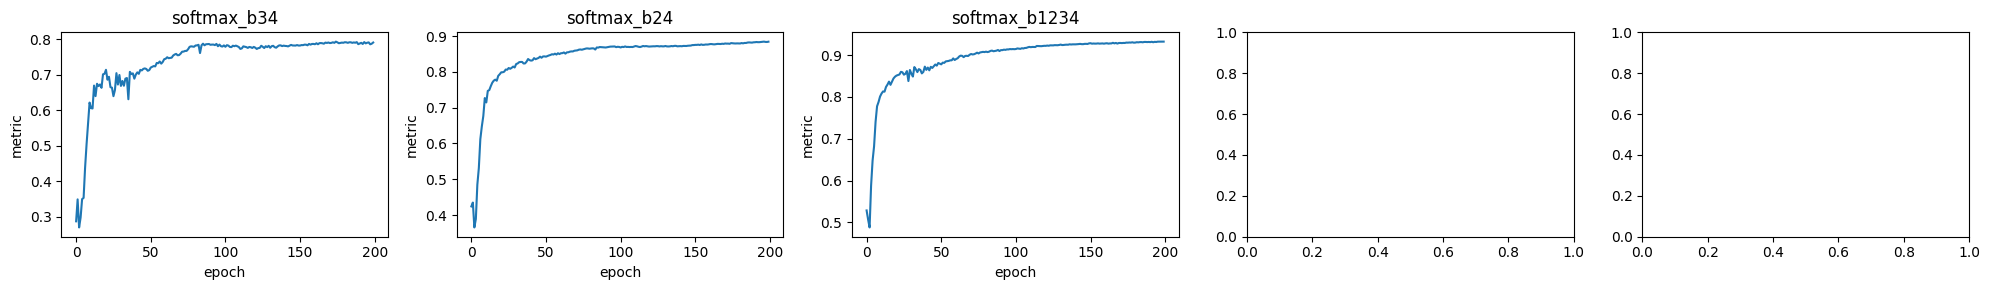

In [4]:
for i in range(10):
    for route_split_mode in ['RandomSplitting', 'NoSplitting']:
        train_mgr0 = train_layers(
            units = 200,              # number of units in each hidden layer
            is_supervised_ff = False, # unsupervised-FF
            batch_size = 256,         # batch size
            data_shuffle_seed = 10,   # Set this to None for no shuffling, otherwise will reshuffle every epoch
            trainable_layers_list = [
                [['b1', 'b2', 'b3', 'b4', 'softmax', 
                  'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4', 
                 ], 200], # 200 epochs of training listed layers
            ],
            show_metrics_max = ['softmax', 'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4'], # show maximum softmax so far
            route_seed = i*2,
            route_split_mode = route_split_mode,
        )

# 4. generate graphs for `units = 200` results

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [6]:
results = '''200/200 [==============================] - 981s 5s/step - b1: 0.0471 - b2: 0.0410 - b3: 0.0670 - b4: 0.0809 - softmax: 0.9431 - softmax_b1: 0.9520 - softmax_b2: 0.9376 - softmax_b3: 0.9364 - softmax_b4: 0.9307 - softmax_b23: 0.9436 - softmax_b34: 0.9372 - softmax_b24: 0.9422 - softmax_b1234: 0.9521 - best_softmax: 0.9433 - best_softmax_b1: 0.9523 - best_softmax_b2: 0.9411 - best_softmax_b3: 0.9364 - best_softmax_b4: 0.9332 - best_softmax_b23: 0.9436 - best_softmax_b34: 0.9377 - best_softmax_b24: 0.9426 - best_softmax_b1234: 0.9530
200/200 [==============================] - 975s 5s/step - b1: 0.0471 - b2: 0.0134 - b3: 0.0153 - b4: 0.0149 - softmax: 0.9267 - softmax_b1: 0.9520 - softmax_b2: 0.9252 - softmax_b3: 0.8528 - softmax_b4: 0.7047 - softmax_b23: 0.9256 - softmax_b34: 0.8539 - softmax_b24: 0.9247 - softmax_b1234: 0.9520 - best_softmax: 0.9267 - best_softmax_b1: 0.9523 - best_softmax_b2: 0.9259 - best_softmax_b3: 0.8711 - best_softmax_b4: 0.7652 - best_softmax_b23: 0.9268 - best_softmax_b34: 0.8685 - best_softmax_b24: 0.9262 - best_softmax_b1234: 0.9526

200/200 [==============================] - 975s 5s/step - b1: 0.0457 - b2: 0.0440 - b3: 0.0568 - b4: 0.0479 - softmax: 0.9475 - softmax_b1: 0.9501 - softmax_b2: 0.9437 - softmax_b3: 0.9379 - softmax_b4: 0.9197 - softmax_b23: 0.9479 - softmax_b34: 0.9378 - softmax_b24: 0.9448 - softmax_b1234: 0.9514 - best_softmax: 0.9478 - best_softmax_b1: 0.9509 - best_softmax_b2: 0.9440 - best_softmax_b3: 0.9379 - best_softmax_b4: 0.9197 - best_softmax_b23: 0.9479 - best_softmax_b34: 0.9378 - best_softmax_b24: 0.9452 - best_softmax_b1234: 0.9514
200/200 [==============================] - 980s 5s/step - b1: 0.0457 - b2: 0.0148 - b3: 0.0166 - b4: 0.0156 - softmax: 0.9249 - softmax_b1: 0.9501 - softmax_b2: 0.9235 - softmax_b3: 0.8777 - softmax_b4: 0.7134 - softmax_b23: 0.9252 - softmax_b34: 0.8788 - softmax_b24: 0.9239 - softmax_b1234: 0.9493 - best_softmax: 0.9317 - best_softmax_b1: 0.9509 - best_softmax_b2: 0.9319 - best_softmax_b3: 0.8996 - best_softmax_b4: 0.7774 - best_softmax_b23: 0.9318 - best_softmax_b34: 0.8986 - best_softmax_b24: 0.9312 - best_softmax_b1234: 0.9493

200/200 [==============================] - 983s 5s/step - b1: 0.0150 - b2: 0.0512 - b3: 0.1586 - b4: 0.1225 - softmax: 0.8941 - softmax_b1: 0.9123 - softmax_b2: 0.8775 - softmax_b3: 0.8739 - softmax_b4: 0.8557 - softmax_b23: 0.8935 - softmax_b34: 0.8766 - softmax_b24: 0.8933 - softmax_b1234: 0.9253 - best_softmax: 0.8941 - best_softmax_b1: 0.9133 - best_softmax_b2: 0.8784 - best_softmax_b3: 0.8745 - best_softmax_b4: 0.8557 - best_softmax_b23: 0.8943 - best_softmax_b34: 0.8768 - best_softmax_b24: 0.8935 - best_softmax_b1234: 0.9254
200/200 [==============================] - 987s 5s/step - b1: 0.0150 - b2: 0.0049 - b3: 0.0057 - b4: 0.0052 - softmax: 0.8703 - softmax_b1: 0.9123 - softmax_b2: 0.8667 - softmax_b3: 0.7867 - softmax_b4: 0.5949 - softmax_b23: 0.8704 - softmax_b34: 0.7879 - softmax_b24: 0.8679 - softmax_b1234: 0.9128 - best_softmax: 0.8703 - best_softmax_b1: 0.9133 - best_softmax_b2: 0.8671 - best_softmax_b3: 0.7872 - best_softmax_b4: 0.6241 - best_softmax_b23: 0.8704 - best_softmax_b34: 0.7879 - best_softmax_b24: 0.8692 - best_softmax_b1234: 0.9138

200/200 [==============================] - 987s 5s/step - b1: 0.0382 - b2: 0.0467 - b3: 0.0782 - b4: 0.0594 - softmax: 0.9417 - softmax_b1: 0.9494 - softmax_b2: 0.9362 - softmax_b3: 0.9379 - softmax_b4: 0.9347 - softmax_b23: 0.9416 - softmax_b34: 0.9390 - softmax_b24: 0.9392 - softmax_b1234: 0.9499 - best_softmax: 0.9423 - best_softmax_b1: 0.9495 - best_softmax_b2: 0.9373 - best_softmax_b3: 0.9379 - best_softmax_b4: 0.9350 - best_softmax_b23: 0.9423 - best_softmax_b34: 0.9396 - best_softmax_b24: 0.9405 - best_softmax_b1234: 0.9509
200/200 [==============================] - 977s 5s/step - b1: 0.0382 - b2: 0.0111 - b3: 0.0133 - b4: 0.0130 - softmax: 0.9217 - softmax_b1: 0.9494 - softmax_b2: 0.9187 - softmax_b3: 0.8694 - softmax_b4: 0.7517 - softmax_b23: 0.9211 - softmax_b34: 0.8720 - softmax_b24: 0.9185 - softmax_b1234: 0.9483 - best_softmax: 0.9218 - best_softmax_b1: 0.9495 - best_softmax_b2: 0.9213 - best_softmax_b3: 0.8759 - best_softmax_b4: 0.7744 - best_softmax_b23: 0.9224 - best_softmax_b34: 0.8758 - best_softmax_b24: 0.9216 - best_softmax_b1234: 0.9484

200/200 [==============================] - 976s 5s/step - b1: 0.0289 - b2: 0.0568 - b3: 0.0637 - b4: 0.0892 - softmax: 0.9341 - softmax_b1: 0.9403 - softmax_b2: 0.9333 - softmax_b3: 0.9211 - softmax_b4: 0.9225 - softmax_b23: 0.9349 - softmax_b34: 0.9259 - softmax_b24: 0.9352 - softmax_b1234: 0.9441 - best_softmax: 0.9368 - best_softmax_b1: 0.9406 - best_softmax_b2: 0.9343 - best_softmax_b3: 0.9230 - best_softmax_b4: 0.9233 - best_softmax_b23: 0.9377 - best_softmax_b34: 0.9261 - best_softmax_b24: 0.9358 - best_softmax_b1234: 0.9462
200/200 [==============================] - 980s 5s/step - b1: 0.0289 - b2: 0.0093 - b3: 0.0109 - b4: 0.0103 - softmax: 0.9090 - softmax_b1: 0.9403 - softmax_b2: 0.9048 - softmax_b3: 0.8483 - softmax_b4: 0.7088 - softmax_b23: 0.9087 - softmax_b34: 0.8488 - softmax_b24: 0.9059 - softmax_b1234: 0.9394 - best_softmax: 0.9090 - best_softmax_b1: 0.9406 - best_softmax_b2: 0.9054 - best_softmax_b3: 0.8586 - best_softmax_b4: 0.7477 - best_softmax_b23: 0.9090 - best_softmax_b34: 0.8618 - best_softmax_b24: 0.9064 - best_softmax_b1234: 0.9403

200/200 [==============================] - 975s 5s/step - b1: 0.0166 - b2: 0.0841 - b3: 0.0096 - b4: 0.1391 - softmax: 0.8933 - softmax_b1: 0.9005 - softmax_b2: 0.8826 - softmax_b3: 0.8536 - softmax_b4: 0.8404 - softmax_b23: 0.8929 - softmax_b34: 0.8683 - softmax_b24: 0.8917 - softmax_b1234: 0.9153 - best_softmax: 0.8941 - best_softmax_b1: 0.9012 - best_softmax_b2: 0.8826 - best_softmax_b3: 0.8537 - best_softmax_b4: 0.8422 - best_softmax_b23: 0.8940 - best_softmax_b34: 0.8683 - best_softmax_b24: 0.8919 - best_softmax_b1234: 0.9156
200/200 [==============================] - 983s 5s/step - b1: 0.0166 - b2: 0.0062 - b3: 0.0075 - b4: 0.0063 - softmax: 0.8439 - softmax_b1: 0.9005 - softmax_b2: 0.8398 - softmax_b3: 0.7332 - softmax_b4: 0.6383 - softmax_b23: 0.8427 - softmax_b34: 0.7411 - softmax_b24: 0.8413 - softmax_b1234: 0.9005 - best_softmax: 0.8439 - best_softmax_b1: 0.9012 - best_softmax_b2: 0.8409 - best_softmax_b3: 0.7393 - best_softmax_b4: 0.6489 - best_softmax_b23: 0.8436 - best_softmax_b34: 0.7416 - best_softmax_b24: 0.8427 - best_softmax_b1234: 0.9012

200/200 [==============================] - 979s 5s/step - b1: 0.0231 - b2: 0.0374 - b3: 0.1824 - b4: 0.1709 - softmax: 0.8928 - softmax_b1: 0.9169 - softmax_b2: 0.8874 - softmax_b3: 0.8605 - softmax_b4: 0.8609 - softmax_b23: 0.8952 - softmax_b34: 0.8703 - softmax_b24: 0.8919 - softmax_b1234: 0.9254 - best_softmax: 0.8931 - best_softmax_b1: 0.9187 - best_softmax_b2: 0.8889 - best_softmax_b3: 0.8619 - best_softmax_b4: 0.8620 - best_softmax_b23: 0.8952 - best_softmax_b34: 0.8708 - best_softmax_b24: 0.8928 - best_softmax_b1234: 0.9259
200/200 [==============================] - 975s 5s/step - b1: 0.0231 - b2: 0.0069 - b3: 0.0078 - b4: 0.0068 - softmax: 0.8767 - softmax_b1: 0.9169 - softmax_b2: 0.8717 - softmax_b3: 0.7760 - softmax_b4: 0.5788 - softmax_b23: 0.8767 - softmax_b34: 0.7751 - softmax_b24: 0.8732 - softmax_b1234: 0.9189 - best_softmax: 0.8767 - best_softmax_b1: 0.9187 - best_softmax_b2: 0.8718 - best_softmax_b3: 0.7786 - best_softmax_b4: 0.6314 - best_softmax_b23: 0.8767 - best_softmax_b34: 0.7800 - best_softmax_b24: 0.8732 - best_softmax_b1234: 0.9192

200/200 [==============================] - 978s 5s/step - b1: 0.0378 - b2: 0.0417 - b3: 0.0839 - b4: 0.0820 - softmax: 0.9369 - softmax_b1: 0.9456 - softmax_b2: 0.9317 - softmax_b3: 0.9304 - softmax_b4: 0.9267 - softmax_b23: 0.9373 - softmax_b34: 0.9330 - softmax_b24: 0.9355 - softmax_b1234: 0.9506 - best_softmax: 0.9379 - best_softmax_b1: 0.9468 - best_softmax_b2: 0.9332 - best_softmax_b3: 0.9318 - best_softmax_b4: 0.9295 - best_softmax_b23: 0.9376 - best_softmax_b34: 0.9330 - best_softmax_b24: 0.9364 - best_softmax_b1234: 0.9514
200/200 [==============================] - 978s 5s/step - b1: 0.0378 - b2: 0.0103 - b3: 0.0121 - b4: 0.0110 - softmax: 0.9222 - softmax_b1: 0.9456 - softmax_b2: 0.9182 - softmax_b3: 0.8470 - softmax_b4: 0.6651 - softmax_b23: 0.9209 - softmax_b34: 0.8477 - softmax_b24: 0.9197 - softmax_b1234: 0.9468 - best_softmax: 0.9223 - best_softmax_b1: 0.9468 - best_softmax_b2: 0.9187 - best_softmax_b3: 0.8672 - best_softmax_b4: 0.7371 - best_softmax_b23: 0.9223 - best_softmax_b34: 0.8643 - best_softmax_b24: 0.9197 - best_softmax_b1234: 0.9473

200/200 [==============================] - 976s 5s/step - b1: 0.0454 - b2: 0.0529 - b3: 0.0455 - b4: 0.0900 - softmax: 0.9421 - softmax_b1: 0.9459 - softmax_b2: 0.9411 - softmax_b3: 0.9313 - softmax_b4: 0.9289 - softmax_b23: 0.9421 - softmax_b34: 0.9338 - softmax_b24: 0.9406 - softmax_b1234: 0.9474 - best_softmax: 0.9421 - best_softmax_b1: 0.9465 - best_softmax_b2: 0.9411 - best_softmax_b3: 0.9317 - best_softmax_b4: 0.9291 - best_softmax_b23: 0.9422 - best_softmax_b34: 0.9342 - best_softmax_b24: 0.9409 - best_softmax_b1234: 0.9484
200/200 [==============================] - 980s 5s/step - b1: 0.0454 - b2: 0.0113 - b3: 0.0140 - b4: 0.0124 - softmax: 0.9137 - softmax_b1: 0.9459 - softmax_b2: 0.9121 - softmax_b3: 0.8346 - softmax_b4: 0.7226 - softmax_b23: 0.9130 - softmax_b34: 0.8372 - softmax_b24: 0.9121 - softmax_b1234: 0.9458 - best_softmax: 0.9160 - best_softmax_b1: 0.9465 - best_softmax_b2: 0.9149 - best_softmax_b3: 0.8613 - best_softmax_b4: 0.7731 - best_softmax_b23: 0.9160 - best_softmax_b34: 0.8603 - best_softmax_b24: 0.9149 - best_softmax_b1234: 0.9465

200/200 [==============================] - 1192s 6s/step - b1: 0.0200 - b2: 0.0682 - b3: 0.0768 - b4: 0.0898 - softmax: 0.9283 - softmax_b1: 0.9306 - softmax_b2: 0.9193 - softmax_b3: 0.9195 - softmax_b4: 0.9164 - softmax_b23: 0.9260 - softmax_b34: 0.9205 - softmax_b24: 0.9241 - softmax_b1234: 0.9401 - best_softmax: 0.9283 - best_softmax_b1: 0.9306 - best_softmax_b2: 0.9194 - best_softmax_b3: 0.9195 - best_softmax_b4: 0.9164 - best_softmax_b23: 0.9266 - best_softmax_b34: 0.9210 - best_softmax_b24: 0.9241 - best_softmax_b1234: 0.9403
200/200 [==============================] - 1542s 8s/step - b1: 0.0200 - b2: 0.0060 - b3: 0.0070 - b4: 0.0064 - softmax: 0.8869 - softmax_b1: 0.9306 - softmax_b2: 0.8827 - softmax_b3: 0.7901 - softmax_b4: 0.5548 - softmax_b23: 0.8860 - softmax_b34: 0.7904 - softmax_b24: 0.8844 - softmax_b1234: 0.9325 - best_softmax: 0.8871 - best_softmax_b1: 0.9306 - best_softmax_b2: 0.8834 - best_softmax_b3: 0.7937 - best_softmax_b4: 0.5832 - best_softmax_b23: 0.8860 - best_softmax_b34: 0.7929 - best_softmax_b24: 0.8846 - best_softmax_b1234: 0.9325'''

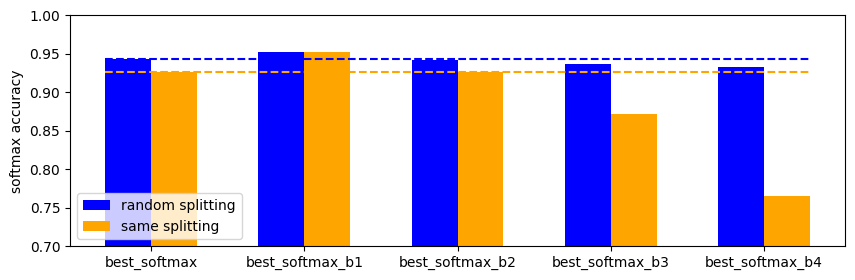

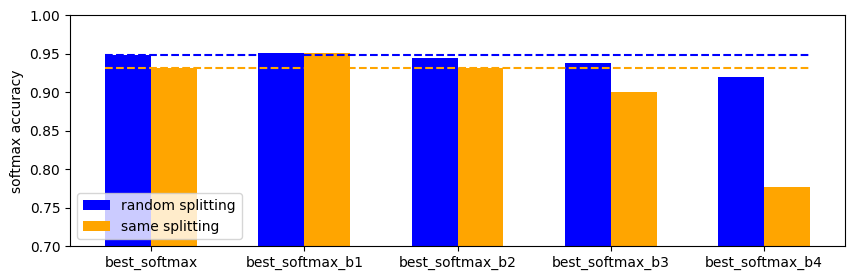

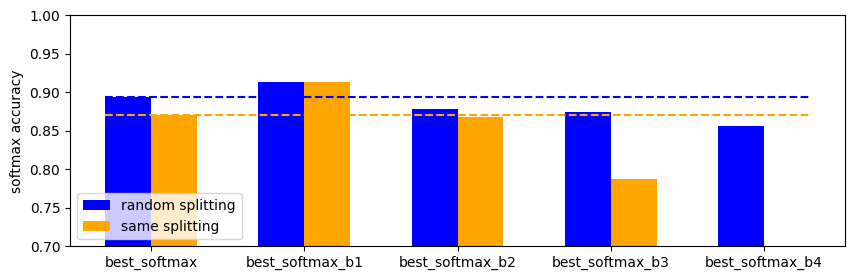

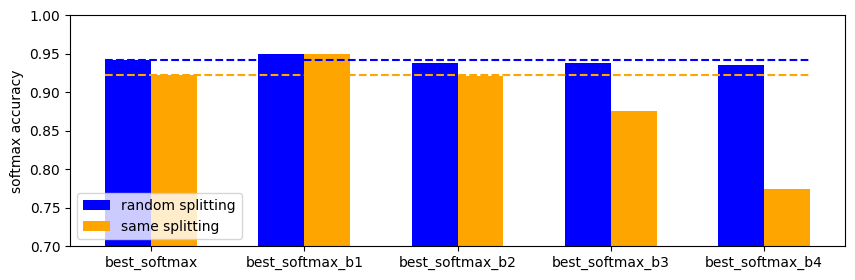

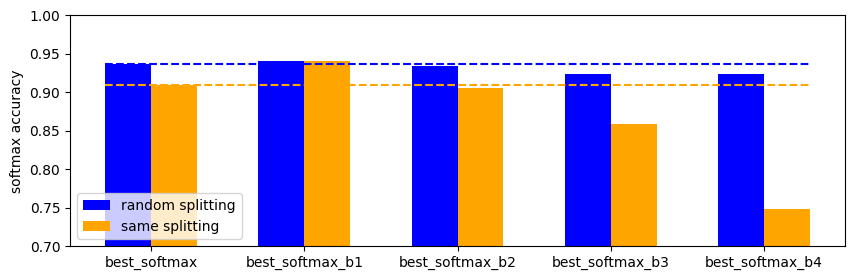

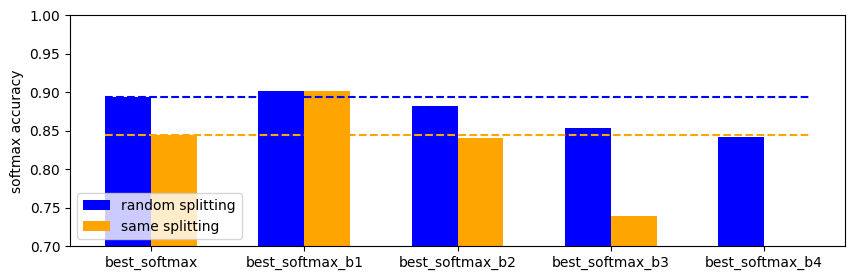

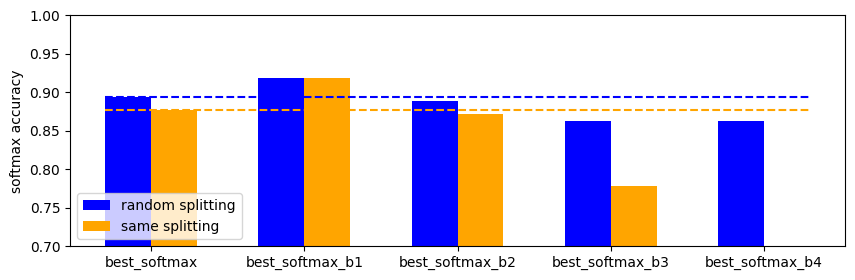

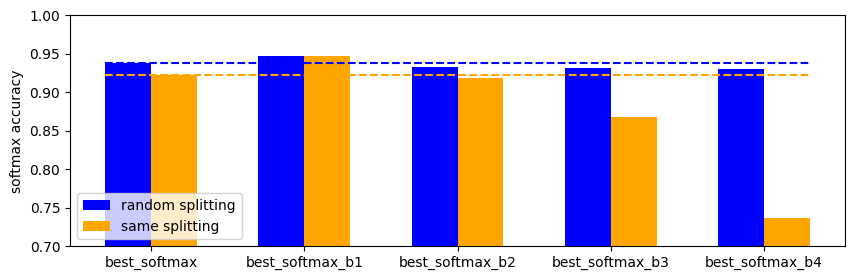

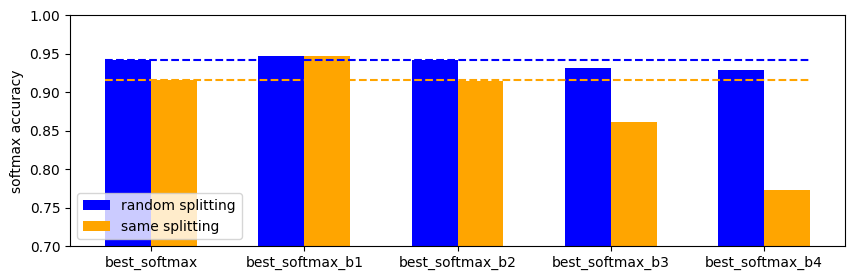

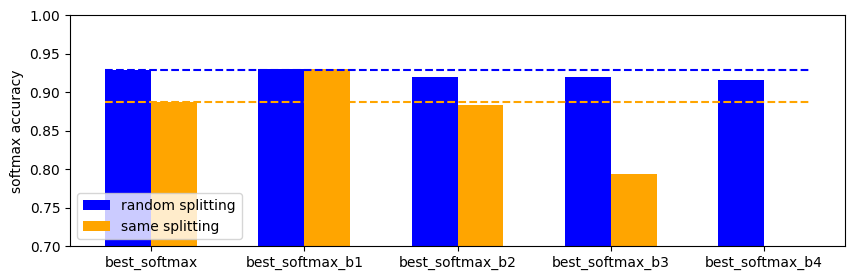

In [7]:
df = pd.DataFrame(
    dict([item.split(': ') for item in l.split(' - ') if ': ' in item])
        for l in results.splitlines() if l
).astype(float)[['best_softmax', 'best_softmax_b1', 'best_softmax_b2', 'best_softmax_b3', 'best_softmax_b4']]

for i, _df in df.groupby(df.index//2):
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    ax.bar(1.0 + np.arange(5) - 0.15, _df.iloc[0], 0.3, label='random splitting', color='blue')
    ax.bar(1.0 + np.arange(5) + 0.15, _df.iloc[1], 0.3, label='same splitting', color='orange')
    ax.set_xticks(ticks=1.0 + np.arange(5), labels=_df.columns)
    ax.set_ylim(0.7, 1.0)
    ax.set_ylabel('softmax accuracy')
    ax.hlines(_df.iloc[0]['best_softmax'], 1 - 0.3 , 5 + 0.3, linestyles='dashed', color='blue')
    ax.hlines(_df.iloc[1]['best_softmax'], 1 - 0.3 , 5 + 0.3, linestyles='dashed', color='orange')
    plt.legend(loc='lower left')
    plt.show()

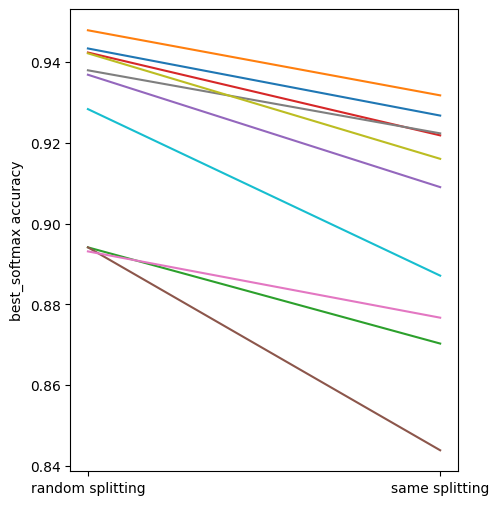

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5,6))

for i, _df in df.groupby(df.index//2):
    ax.plot(1.0 + np.arange(2), _df['best_softmax'])
    ax.set_xticks(ticks=1.0 + np.arange(2), labels=['random splitting', 'same splitting'])
ax.set_ylabel('best_softmax accuracy')
plt.show()